<a href="https://colab.research.google.com/github/surajsrivathsa/image_registration/blob/main/SCG_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preamble

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install voxelmorph 

     |████████████████████████████████| 81kB 8.0MB/s 
     |████████████████████████████████| 92kB 10.7MB/s 


In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import neurite as ne
import nibabel as nb
import os, sys, glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import gc
import skimage.transform as skt
from random import randint, seed
seed(1)

In [ ]:
print("nibabel version: {}".format(nb.__version__))
print("pytorch version: {}".format(torch.__version__))
print("numpy version: {}".format(np.__version__))

nibabel version: 3.0.2
pytorch version: 1.8.1+cu101
numpy version: 1.19.5


In [ ]:
data_path_t1 = "/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/T1_Train_200_Reg_downsampled_znm/"
data_path_t2 = "/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/T1_Train_200_Reg_downsampled_znm/"
#data_path_t1 = "/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/Voxelmorph_dataset_downsampled/"
#data_path_t2 = "/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/Voxelmorph_dataset_downsampled/"
file_names_t1 = sorted(glob.glob(os.path.join(data_path_t1, "*.nii.gz")))
file_names_t2 = sorted(glob.glob(os.path.join(data_path_t2, "*.nii.gz")))

# Dataset Creation

In [ ]:
def load_4D(name):
    model_np = np.zeros(shape=(128, 128, 128))
    X_nb = nb.load(name)
    X_np = X_nb.dataobj
    #print("Oreintation: {}".format(nb.aff2axcodes(X_nb.affine)))
    #model_np[:, :, 0:X_np.shape[2]] = X_np[0:128, 0:128, :]
    #model_np = np.reshape(model_np, (1,)+ model_np.shape)
    model_np = np.reshape(X_np, (1,)+ X_np.shape)
    return model_np

def load_4D_200(name):
        resamplng_shape = (128, 128, 128)
        X_nb = nb.load(name)
        X_np = X_nb.dataobj
       
        min_pixel_value = np.min(X_np)   # getting minimum pixel value which is -1 in my case.
        model_np = np.full(shape=(128, 128, 128),fill_value=min_pixel_value)
        x_dim, y_dim, z_dim = X_np.shape
        x_ltail = (resamplng_shape[0] - x_dim)//2 
        y_ltail = (resamplng_shape[1] - y_dim)//2
        z_ltail = (resamplng_shape[2] - z_dim)//2

        x_rtail = resamplng_shape[0] - x_ltail - 1
        y_rtail = resamplng_shape[1] - y_ltail - 1
        z_rtail = resamplng_shape[2] - z_ltail - 1
        model_np[x_ltail:x_rtail, y_ltail:y_rtail, z_ltail:z_rtail] = X_np[:, :, :]
        model_np = np.reshape(model_np, (1,)+ model_np.shape)
        return model_np

def imgnorm(N_I,index1=0.0001,index2=0.0001):
    I_sort = np.sort(N_I.flatten())
    I_min = I_sort[int(index1*len(I_sort))]
    I_max = I_sort[-int(index2*len(I_sort))]
    N_I =1.0*(N_I-I_min)/(I_max-I_min)
    N_I[N_I>1.0]=1.0
    N_I[N_I<0.0]=0.0
    N_I2 = N_I.astype(np.float32)
    return N_I2

def Norm_Zscore(img):
    img= (img-np.mean(img))/np.std(img) 
    return img

def downsample(img):
    dimg = skt.resize(img, (1, 64, 64, 64), 3)
    return dimg

In [ ]:
class Dataset(Data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, t1_filenames, t2_filenames, iterations=1,norm=True):
        'Initialization'
        self.t1_filenames = t1_filenames
        self.t2_filenames = t2_filenames
        self.norm = norm
        self.iterations = iterations
  def __len__(self):
        'Denotes the total number of samples'
        return len(self.t1_filenames) * self.iterations

  def __getitem__(self, idx):
        'Generates one sample of data'
        A_idx = randint(0, len(self.t1_filenames)-1)
        B_idx = randint(0, len(self.t1_filenames)-1)
        if (A_idx == B_idx):
          B_idx = (B_idx + 1) % (len(self.t1_filenames)-1)

        #img_A = load_4D(self.t1_filenames[idx])
        #img_B = load_4D(self.t1_filenames[(idx + 4) % len(self.t1_filenames)])

        img_A = load_4D_200(self.t1_filenames[A_idx])
        img_B = load_4D_200(self.t1_filenames[B_idx])

        #print(A_idx, B_idx)
                       
        if self.norm:
            #return  Norm_Zscore(imgnorm(img_A)) , Norm_Zscore(imgnorm(img_B))
            full_img_A = imgnorm(img_A) 
            full_img_B = imgnorm(img_B)
            return  full_img_A , full_img_B
        else:
            return img_A, img_B

In [ ]:
class ValidationDataset(Data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, t1_filenames, t2_filenames, iterations=1,norm=True):
        'Initialization'
        self.t1_filenames = t1_filenames
        self.t2_filenames = t2_filenames
        self.norm = norm
        self.iterations = iterations
  def __len__(self):
        'Denotes the total number of samples'
        return len(self.t1_filenames) * self.iterations

  def __getitem__(self, idx):
        """
        A_idx = randint(0, len(self.t1_filenames)-1)
        B_idx = randint(0, len(self.t1_filenames)-1)
        if (A_idx == B_idx):
          B_idx = (B_idx + 1) % (len(self.t1_filenames)-1)
        
        """

        img_A = load_4D_200(self.t1_filenames[idx])
        img_B = load_4D_200(self.t1_filenames[(idx + 4) % len(self.t1_filenames)])

        #img_A = load_4D(self.t1_filenames[A_idx])
        #img_B = load_4D(self.t1_filenames[B_idx])

        #print(A_idx, B_idx)
                       
        if self.norm:
            #return  Norm_Zscore(imgnorm(img_A)) , Norm_Zscore(imgnorm(img_B))
            full_img_A = imgnorm(img_A) 
            full_img_B = imgnorm(img_B)
            return  full_img_A , full_img_B
        else:
            return img_A, img_B

In [ ]:
training_generator = Data.DataLoader(Dataset(file_names_t1, file_names_t2,norm=True), batch_size=5, shuffle=False)

In [ ]:
validation_generator = Data.DataLoader(ValidationDataset(file_names_t1, file_names_t2,norm=True), batch_size=1, shuffle=False)

In [ ]:
for X,Y in training_generator:
  print(X.shape)
  print(Y.shape)
  print(torch.max(X), torch.min(X))
  del X, Y
  break

torch.Size([5, 1, 128, 128, 128])
torch.Size([5, 1, 128, 128, 128])
tensor(1.) tensor(0.)


# Feature Extractor Model Creation

In [ ]:
class Feature_Extractor(nn.Module):
  def __init__(self,in_channel, n_classes, start_channel):
        self.in_channel = in_channel
        self.n_classes = n_classes
        self.start_channel = start_channel
        super(Feature_Extractor, self).__init__()
        self.en0 = self.encoder(self.in_channel, self.start_channel, bias=False)

        self.en1 = self.encoder(self.start_channel * 1, self.start_channel * 2, stride=2, bias=True)
        self.en2 = self.encoder(self.start_channel * 2, self.start_channel * 3, stride=2, bias=True)
        self.en3 = self.encoder(self.start_channel * 3, self.start_channel * 4, stride=2, bias=True)
        self.en4 = self.encoder(self.start_channel * 4, self.start_channel * 5, stride=2, bias=True)
        self.en5 = self.encoder(self.start_channel * 5, self.start_channel * 6, stride=2, bias=True)

  def encoder(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
    layer = nn.Sequential(
                nn.Conv3d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=bias),
                nn.BatchNorm3d(out_channels),
                nn.LeakyReLU(0.2))
    return layer

  def forward(self, x,y):
        # print("x,y", x.shape, "  ", y.shape)
        x_in=torch.cat((x, y), 1)  
        enc_op_1 = self.en0(x_in)
        enc_op = self.en1(enc_op_1)
        enc_op_p = self.en2(enc_op)
        enc_op = self.en3(enc_op_p) # 16
        #enc_op = self.en4(enc_op) # 8

        # Last encoders latent space 1/32 times original dim , 4
        #enc_op = self.en5(enc_op)

        return enc_op, enc_op_p, enc_op_1

In [ ]:
class Feature_Extractor2(nn.Module):
  def __init__(self,in_channel, start_channel):
        self.in_channel = in_channel
        self.start_channel = start_channel
        super(Feature_Extractor2, self).__init__()
        self.en0 = self.encoder(self.in_channel, self.start_channel, bias=False)

        self.en1 = self.encoder(self.start_channel * 1, self.start_channel * 2, stride=2, bias=True)
        self.en2 = self.encoder(self.start_channel * 2, self.start_channel * 3, stride=2, bias=True)
        self.en3 = self.encoder(self.start_channel * 3, self.start_channel * 4, stride=2, bias=True)
        self.en4 = self.encoder(self.start_channel * 4, self.start_channel * 5, stride=2, bias=True)
        self.en5 = self.encoder(self.start_channel * 5, self.start_channel * 6, stride=2, bias=True)

  def encoder(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
    layer = nn.Sequential(
                nn.Conv3d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=bias),
                nn.BatchNorm3d(out_channels),
                nn.LeakyReLU(0.2))
    return layer

  def forward(self, x):
        # print("x,y", x.shape, "  ", y.shape)
        x_in=x 
        enc_op = self.en0(x_in)
        enc_op = self.en1(enc_op)
        enc_op = self.en2(enc_op)
        enc_op = self.en3(enc_op) # 16
        #enc_op = self.en4(enc_op) # 8

        # Last encoders latent space 1/32 times original dim , 4
        #enc_op = self.en5(enc_op)

        return enc_op

In [ ]:
class Feature_Extractor3(nn.Module):
  def __init__(self,in_channel, n_classes, start_channel):
        self.in_channel = in_channel
        self.n_classes = n_classes
        self.start_channel = start_channel
        super(Feature_Extractor3, self).__init__()
        self.en0 = self.encoder(self.in_channel, self.start_channel, bias=False)

        self.en1 = self.encoder(self.start_channel * 1, self.start_channel * 2, stride=2, bias=True)
        self.en2 = self.encoder(self.start_channel * 2, self.start_channel * 3, stride=2, bias=True)
        self.en3 = self.encoder(self.start_channel * 3, self.start_channel * 4, stride=2, bias=True)
        self.en4 = self.encoder(self.start_channel * 4, self.start_channel * 5, stride=2, bias=True)
        self.en5 = self.encoder(self.start_channel * 5, self.start_channel * 6, stride=2, bias=True)

  def encoder(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
    layer = nn.Sequential(
                nn.Conv3d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=bias),
                nn.BatchNorm3d(out_channels),
                nn.LeakyReLU(0.2))
    return layer

  def forward(self, x,y):
        # print("x,y", x.shape, "  ", y.shape)
        x_in=torch.cat((x, y), 1)  
        enc_1 = self.en0(x_in)
        enc_2 = self.en1(enc_1)
        enc_3 = self.en2(enc_2)
        enc_4 = self.en3(enc_3) # 16
        #enc_op = self.en4(enc_op) # 8

        # Last encoders latent space 1/32 times original dim , 4
        #enc_op = self.en5(enc_op)

        return enc_1, enc_2, enc_3, enc_4

In [ ]:
model = Feature_Extractor(2,3,8)

In [ ]:
count = 0
for X, Y in training_generator:
  feature_extractor_op = model(X, Y)
  print(feature_extractor_op.shape)
  del feature_extractor_op
  if (count > 2):
    break
  
  count = count+ 1
  

NameError: ignored

# Upsampler Model creation

In [ ]:
class Upsampler_net(nn.Module):
  def __init__(self, in_channel ):
        
        self.in_channel = in_channel
        super(Upsampler_net, self).__init__()
        
        self.up0 = self.decoder(self.in_channel*4, self.in_channel*3)
        self.up1 = self.decoder(3, 3)
        self.up2 = self.decoder(self.in_channel*2, self.in_channel*1)

        self.conv1X1_1 = self.conv1X1(24, 3)


        #self.dc4 = self.output(self.start_channel, self.n_classes,kernel_size=1,bias=False)

  def decoder(self, in_channels, out_channels, kernel_size=2, stride=2, padding=0,
                output_padding=0, bias=True):
    layer = nn.Sequential(
                nn.ConvTranspose3d(in_channels, out_channels, kernel_size, stride=stride,
                               padding=padding, output_padding=output_padding, bias=bias),
                                nn.LeakyReLU(0.2))
    return layer
       
  def output(self, in_channels, out_channels, kernel_size=3, padding=1, bias=False, batchnorm=False):
    layer = nn.Sequential(nn.Conv3d(in_channels, out_channels, kernel_size, bias=bias, padding=padding),)
    return layer

  def conv1X1(self, in_channels, out_channels, kernel_size=1, padding=0, bias=False, batchnorm=False):
    layer = nn.Sequential(nn.Conv3d(in_channels, out_channels, kernel_size, bias=bias, padding=padding),)
    return layer

  def forward(self, latent_space_feats, additional_encoder_feats1 ):

        d0 = torch.add(self.up1(latent_space_feats), self.conv1X1_1(additional_encoder_feats1))
        
        return d0

In [ ]:
class Upsampler_net2(nn.Module):
  def __init__(self, in_channel ):
        
        self.in_channel = in_channel
        super(Upsampler_net2, self).__init__()

        self.conv1X1_1 = self.conv1X1(self.in_channel, 3)
        self.op = self.output(3, 3)

  def decoder(self, in_channels, out_channels, kernel_size=2, stride=2, padding=0,
                output_padding=0, bias=True):
    layer = nn.Sequential(
                nn.ConvTranspose3d(in_channels, out_channels, kernel_size, stride=stride,
                               padding=padding, output_padding=output_padding, bias=bias),
                                nn.LeakyReLU(0.2))
    return layer
       
  def output(self, in_channels, out_channels, kernel_size=3, padding=1, bias=True, batchnorm=True):
    layer = nn.Sequential(nn.Conv3d(in_channels, out_channels, kernel_size, bias=bias, padding=padding),)
    return layer

  def conv1X1(self, in_channels, out_channels, kernel_size=1, padding=0, bias=False, batchnorm=False):
    layer = nn.Sequential(nn.Conv3d(in_channels, out_channels, kernel_size, bias=bias, padding=padding),)
    return layer

  def forward(self, latent_space_feats, additional_encoder_feats1 ):
        c11 = self.conv1X1_1(additional_encoder_feats1)
        ad = torch.add(latent_space_feats, c11)
        d0 = self.op(ad )
        
        return d0

In [ ]:
class Upsampler_net3(nn.Module):
  def __init__(self, encoder_in_channel, factor, decoder_in_channel, out_channel=3 ):
        
        self.encoder_in_channel = encoder_in_channel
        self.decoder_in_channel = decoder_in_channel
        self.out_channel = out_channel
        self.factor = factor
        super(Upsampler_net3, self).__init__()

        #self.conv1X1_1 = self.conv1X1(self.in_channel, 3)
        #self.op = self.output(3, 3)
        self.op = self.output(self.encoder_in_channel * self.factor + self.decoder_in_channel, self.out_channel)

  def decoder(self, in_channels, out_channels, kernel_size=2, stride=2, padding=0,
                output_padding=0, bias=True):
    layer = nn.Sequential(
                nn.ConvTranspose3d(in_channels, out_channels, kernel_size, stride=stride,
                               padding=padding, output_padding=output_padding, bias=bias),
                                nn.LeakyReLU(0.2))
    return layer
       
  def output(self, in_channels, out_channels, kernel_size=3, padding=1, bias=True, batchnorm=True):
    layer = nn.Sequential(nn.Conv3d(in_channels, out_channels, kernel_size, bias=bias, padding=padding),)
    return layer

  def conv1X1(self, in_channels, out_channels, kernel_size=1, padding=0, bias=False, batchnorm=False):
    layer = nn.Sequential(nn.Conv3d(in_channels, out_channels, kernel_size, bias=bias, padding=padding),)
    return layer

  def forward(self, interpolation_feats, encoder_feats ):
        c11 = torch.cat((interpolation_feats, encoder_feats), 1)
        #c11 = self.conv1X1_1(additional_encoder_feats1)
        #ad = torch.add(latent_space_feats, c11)
        d0 = self.op(c11)
        return d0

In [ ]:
class Upsampler_net4(nn.Module):
  def __init__(self, in_channel, out_channel=3 ):
        
        self.in_channel = in_channel
        self.out_channel = out_channel
        super(Upsampler_net4, self).__init__()
        self.op = self.output(self.in_channel, self.out_channel)
       
  def output(self, in_channels, out_channels, kernel_size=3, padding=1, bias=True, batchnorm=True):
    layer = nn.Sequential(nn.Conv3d(in_channels, out_channels, kernel_size, bias=bias, padding=padding),)
    return layer

  def conv1X1(self, in_channels, out_channels, kernel_size=1, padding=0, bias=False, batchnorm=False):
    layer = nn.Sequential(nn.Conv3d(in_channels, out_channels, kernel_size, bias=bias, padding=padding),)
    return layer

  def forward(self, latent_feats):
        return self.op(latent_feats)

In [ ]:
class Upsampler_net5(nn.Module):
  def __init__(self, encoder_in_channel, factor, decoder_in_channel, out_channel=3 ):
        
        self.encoder_in_channel = encoder_in_channel
        self.decoder_in_channel = decoder_in_channel
        self.out_channel = out_channel
        self.factor = factor
        super(Upsampler_net5, self).__init__()
        self.op = self.output(self.encoder_in_channel * self.factor + self.decoder_in_channel, self.out_channel)
        self.op = self.decoder(self.encoder_in_channel * self.factor + self.decoder_in_channel, self.out_channel)

  def decoder(self, in_channels, out_channels, kernel_size=2, stride=2, padding=0,
                output_padding=0, bias=True):
    layer = nn.Sequential(nn.ConvTranspose3d(in_channels, out_channels, kernel_size, stride=stride,
                          padding=padding, output_padding=output_padding, bias=bias), nn.LeakyReLU(0.2))
    return layer
       
  def output(self, in_channels, out_channels, kernel_size=3, padding=1, bias=True, batchnorm=True):
    layer = nn.Sequential(nn.Conv3d(in_channels, out_channels, kernel_size, bias=bias, padding=padding),)
    return layer

  def conv1X1(self, in_channels, out_channels, kernel_size=1, padding=0, bias=False, batchnorm=False):
    layer = nn.Sequential(nn.Conv3d(in_channels, out_channels, kernel_size, bias=bias, padding=padding),)
    return layer

  def forward(self, interpolation_feats, encoder_feats ):
        c11 = torch.cat((interpolation_feats, encoder_feats), 1)
        d0 = self.op(c11)
        return d0

In [ ]:
encoder_op = torch.randn(size=(3, 32, 16, 16, 16))
latent_spcafe_feats = torch.randn(size=(3, 3, 16, 16, 16))
upsampler_model = Upsampler_net2(32)

In [ ]:
umo = upsampler_model(latent_spcafe_feats, encoder_op)

In [ ]:
encoder_op = torch.randn(size=(3, 8, 128, 128, 128))
latent_space_feats = torch.randn(size=(3, 3, 128, 128, 128))
upsampler_model2 = Upsampler_net2(8)

In [ ]:
umo = upsampler_model2(latent_space_feats, encoder_op)

In [ ]:
del umo, encoder_op, latent_space_feats, upsampler_model2

In [ ]:
upsampler_model = Upsampler_net(8)
latent_feats_tnsr = torch.randn(size=(5, 3, 16, 16, 16))
encoder_feats_tnsr = torch.randn(size=(5, 24, 32, 32, 32))

In [ ]:
umo = upsampler_model(latent_feats_tnsr, encoder_feats_tnsr)

In [ ]:
del encoder_feats_tnsr, latent_feats_tnsr

In [ ]:
upsampler_model = Upsampler_net3(8, 3, 9)
latent_feats_tnsr = torch.randn(size=(5, 9, 32, 32, 32))
encoder_feats_tnsr = torch.randn(size=(5, 24, 32, 32, 32))

In [ ]:
umo = upsampler_model(latent_feats_tnsr, encoder_feats_tnsr)

In [ ]:
del encoder_feats_tnsr, latent_feats_tnsr, umo

In [ ]:
upsampler_model = Upsampler_net4(9, 3)
latent_feats_tnsr = torch.randn(size=(5, 9, 32, 32, 32))

In [ ]:
umo = upsampler_model(latent_feats_tnsr)

In [ ]:
del latent_feats_tnsr, umo

# SCG Model Creation

In [ ]:
class SCG_block(nn.Module):
    def __init__(self, in_ch, hidden_ch=9, node_size=(8, 8, 8), add_diag=True, dropout=0.2):
        super(SCG_block, self).__init__()
        self.node_size = node_size
        self.hidden = hidden_ch
        self.nodes = node_size[0]*node_size[1]*node_size[2]
        self.add_diag = add_diag
        self.pool = nn.AdaptiveAvgPool3d(node_size)
        self.lkrelu = nn.LeakyReLU(0.2)

        self.mu = nn.Sequential(
            nn.Conv3d(in_ch, hidden_ch, 3, padding=1, bias=True),
            nn.Dropout(dropout),
        )

        self.logvar = nn.Sequential(
            nn.Conv3d(in_ch, hidden_ch, 1, 1, bias=True),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        B, C, H, W, D = x.size()
        gx = self.pool(x)

        mu, log_var = self.mu(gx), self.logvar(gx)

        if self.training:
            std = torch.exp(log_var.reshape(B, self.nodes, self.hidden))
            eps = torch.randn_like(std)
            z = mu.reshape(B, self.nodes, self.hidden) + std*eps
        else:
            z = mu.reshape(B, self.nodes, self.hidden)

        A = torch.matmul(z, z.permute(0, 2, 1))
        #A = torch.relu(A)
        A = self.lkrelu(A)

        Ad = torch.diagonal(A, dim1=1, dim2=2)
        mean = torch.mean(Ad, dim=1)
        gama = torch.sqrt(1 + 1.0 / mean).unsqueeze(-1).unsqueeze(-1)

        dl_loss = gama.mean() * torch.log(Ad[Ad<1]+ 1.e-7).sum() / (A.size(0) * A.size(1) * A.size(2))

        kl_loss = -0.5 / self.nodes * torch.mean(
            torch.sum(1 + 2 * log_var - mu.pow(2) - log_var.exp().pow(2), 1)
        )

        loss = kl_loss - dl_loss

        if self.add_diag:
            diag = []
            for i in range(Ad.shape[0]):
                diag.append(torch.diag(Ad[i, :]).unsqueeze(0))

            A = A + gama * torch.cat(diag, 0)
            # A = A + A * (gama * torch.eye(A.size(-1), device=A.device).unsqueeze(0))

        # A = laplacian_matrix(A, self_loop=True)
        A = self.laplacian_matrix(A, self_loop=True)
        # A = laplacian_batch(A.unsqueeze(3), True).squeeze()

        z_hat = gama.mean() * \
                mu.reshape(B, self.nodes, self.hidden) * \
                (1. - log_var.reshape(B, self.nodes, self.hidden))

        return A, gx, loss, z_hat

    @classmethod
    def laplacian_matrix(cls, A, self_loop=False):
        '''
        Computes normalized Laplacian matrix: A (B, N, N)
        '''
        if self_loop:
            A = A + torch.eye(A.size(1), device=A.device).unsqueeze(0)
        # deg_inv_sqrt = (A + 1e-5).sum(dim=1).clamp(min=0.001).pow(-0.5)
        deg_inv_sqrt = (torch.sum(A, 1) + 1e-5).pow(-0.5)

        LA = deg_inv_sqrt.unsqueeze(-1) * A * deg_inv_sqrt.unsqueeze(-2)

        return LA



In [ ]:
sb = SCG_block(in_ch=32, hidden_ch=9, node_size=(16, 16, 16))
model = Feature_Extractor(2, 3, 8)

In [ ]:
count = 0
for X, Y in training_generator:

  feature_extractor_op, m, n = model(X, Y)
  print(feature_extractor_op.shape)
  print()

  B, C = feature_extractor_op.shape[0], feature_extractor_op.shape[1] 
  A, gx, loss, z_hat = sb(feature_extractor_op)
  print(A.shape, gx.shape, loss.shape, z_hat.shape)
  print(loss)
  torch.bmm(A, (gx.reshape(B, -1, C)))
  print("============= =============== ===========")

  del feature_extractor_op, A, gx, loss, z_hat
  if (count > 1):
    break
  
  count = count+ 1

torch.Size([5, 32, 16, 16, 16])

torch.Size([5, 4096, 4096]) torch.Size([5, 32, 16, 16, 16]) torch.Size([]) torch.Size([5, 4096, 9])
tensor(0.0062, grad_fn=<SubBackward0>)
============= =============== ===========
torch.Size([5, 32, 16, 16, 16])

torch.Size([5, 4096, 4096]) torch.Size([5, 32, 16, 16, 16]) torch.Size([]) torch.Size([5, 4096, 9])
tensor(0.0102, grad_fn=<SubBackward0>)
============= =============== ===========
torch.Size([5, 32, 16, 16, 16])

torch.Size([5, 4096, 4096]) torch.Size([5, 32, 16, 16, 16]) torch.Size([]) torch.Size([5, 4096, 9])
tensor(0.0098, grad_fn=<SubBackward0>)
============= =============== ===========


In [ ]:
class GCN_Layer(nn.Module):
    def __init__(self, in_features, out_features, bnorm=True, activation=nn.LeakyReLU(0.2), dropout=None):
        super(GCN_Layer, self).__init__()
        self.bnorm = bnorm
        fc = [nn.Linear(in_features, out_features)]
        if bnorm:
            fc.append(BatchNorm_GCN(out_features))
        if activation is not None:
            fc.append(activation)
        if dropout is not None:
            fc.append(nn.Dropout(dropout))
        self.fc = nn.Sequential(*fc)

    def forward(self, data):
        x, A = data
        tbmm = torch.bmm(A, x)
        
        y = self.fc(tbmm)

        return [y, A]


In [ ]:
def weight_xavier_init(*models):
    for model in models:
        for module in model.modules():
            if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
                # nn.init.xavier_normal_(module.weight)
                nn.init.orthogonal_(module.weight)
                # nn.init.kaiming_normal_(module.weight)
                if module.bias is not None:
                    module.bias.data.zero_()
            elif isinstance(module, nn.BatchNorm2d):
                module.weight.data.fill_(1)
                module.bias.data.zero_()


In [ ]:
class BatchNorm_GCN(nn.BatchNorm1d):
    '''Batch normalization over GCN features'''

    def __init__(self, num_features):
        super(BatchNorm_GCN, self).__init__(num_features)

    def forward(self, x):
        return super(BatchNorm_GCN, self).forward(x.permute(0, 2, 1)).permute(0, 2, 1)


In [ ]:
graph_layers1 = GCN_Layer(32, 16, bnorm=True, activation=nn.ReLU(True), dropout=0.1)

graph_layers2 = GCN_Layer(16, 9, bnorm=False, activation=None)

In [ ]:
weight_xavier_init(graph_layers1, graph_layers2, sb)

In [ ]:
count = 0
for X, Y in training_generator:
  x_size = X.size()

  feature_extractor_op,_,_ = model(X, Y)
  print(feature_extractor_op.shape)
  print()

  A, gx, loss, z_hat = sb(feature_extractor_op)
  
  B, C, H, W, D = feature_extractor_op.size()
  print(A.shape, gx.shape, loss.shape, z_hat.shape, gx.reshape(B, -1, C).shape)
  print(loss)
  print()

  gop_layers1, A_layers1 = graph_layers1((gx.reshape(B, -1, C), A))
  print(gop_layers1.shape, A_layers1.shape)
  print()
  
  gop_layers2, A_layers2 = graph_layers2((gop_layers1, A_layers1))
  print(gop_layers2.shape, A_layers2.shape)

  gop_layers2 = gop_layers2 + z_hat

  gx = gop_layers2.reshape(B, 9, 16, 16, 16)

  

  gx = F.interpolate(gx, (H, W, D), mode='trilinear', align_corners=False)
  print(gx.shape)

  gx = F.interpolate(gx, x_size[2:], mode='trilinear', align_corners=False)
  print(gx.shape)


  print("============= =============== ===========")

  del feature_extractor_op, A, gx, loss, z_hat, gop_layers1, A_layers1, gop_layers2, A_layers2


  if (count > 1):
    break
  
  count = count+ 1

torch.Size([5, 32, 16, 16, 16])

torch.Size([5, 4096, 4096]) torch.Size([5, 32, 16, 16, 16]) torch.Size([]) torch.Size([5, 4096, 9]) torch.Size([5, 4096, 32])
tensor(0.0062, grad_fn=<SubBackward0>)

torch.Size([5, 4096, 16]) torch.Size([5, 4096, 4096])

torch.Size([5, 4096, 9]) torch.Size([5, 4096, 4096])
torch.Size([5, 9, 16, 16, 16])
torch.Size([5, 9, 128, 128, 128])
============= =============== ===========
torch.Size([5, 32, 16, 16, 16])

torch.Size([5, 4096, 4096]) torch.Size([5, 32, 16, 16, 16]) torch.Size([]) torch.Size([5, 4096, 9]) torch.Size([5, 4096, 32])
tensor(0.0055, grad_fn=<SubBackward0>)

torch.Size([5, 4096, 16]) torch.Size([5, 4096, 4096])

torch.Size([5, 4096, 9]) torch.Size([5, 4096, 4096])
torch.Size([5, 9, 16, 16, 16])
torch.Size([5, 9, 128, 128, 128])
============= =============== ===========
torch.Size([5, 32, 16, 16, 16])

torch.Size([5, 4096, 4096]) torch.Size([5, 32, 16, 16, 16]) torch.Size([]) torch.Size([5, 4096, 9]) torch.Size([5, 4096, 32])
tensor(0.0059

# Spatial Transformer

In [ ]:
class SpatialTransformer(nn.Module):
    """
    N-D Spatial Transformer
    """

    def __init__(self, size, is_affine=False, theta = None, mode='bilinear', affine_image_size =  (2, 1, 128, 128, 128)):
        super().__init__()

        self.mode = mode
        self.isaffine = is_affine
        self.theta = theta
        self.affine_image_size =  affine_image_size
        # create sampling grid
        # registering the grid as a buffer cleanly moves it to the GPU, but it also
        # adds it to the state dict. this is annoying since everything in the state dict
        # is included when saving weights to disk, so the model files are way bigger
        # than they need to be. so far, there does not appear to be an elegant solution.
        # see: https://discuss.pytorch.org/t/how-to-register-buffer-without-polluting-state-dict

        if (self.isaffine):
          grid = F.affine_grid(self.theta, self.affine_image_size, align_corners=False)
          #grid = grid.permute(0, 4, 1, 2, 3)
          self.register_buffer('grid', grid)
        else:
          vectors = [torch.arange(0, s) for s in size]
          grids = torch.meshgrid(vectors)
          grid = torch.stack(grids)
          grid = torch.unsqueeze(grid, 0)
          grid = grid.type(torch.FloatTensor)
          self.register_buffer('grid', grid)

    def forward(self, src, flow=None):      
      if (self.isaffine):
        grid = F.affine_grid(self.theta, self.affine_image_size)        
        warped_image = F.grid_sample(src, grid)
        #warped_image = warped_image.permute(0, 4, 1, 2, 3)
        return warped_image
      else:
        # new locations
        new_locs = self.grid + flow
        shape = flow.shape[2:]

        # need to normalize grid values to [-1, 1] for resampler
        for i in range(len(shape)):
            new_locs[:, i, ...] = 2 * (new_locs[:, i, ...] / (shape[i] - 1) - 0.5)

        # move channels dim to last position
        # also not sure why, but the channels need to be reversed
        if len(shape) == 2:
            new_locs = new_locs.permute(0, 2, 3, 1)
            new_locs = new_locs[..., [1, 0]]
        elif len(shape) == 3:
            new_locs = new_locs.permute(0, 2, 3, 4, 1)
            new_locs = new_locs[..., [2, 1, 0]]

        return F.grid_sample(src, new_locs, align_corners=True, mode=self.mode)

# Losses

In [ ]:
def normalized_cross_correlation(x, y, return_map, reduction='mean', eps=1e-8):
    """ N-dimensional normalized cross correlation (NCC)
    Args:
        x (~torch.Tensor): Input tensor.
        y (~torch.Tensor): Input tensor.
        return_map (bool): If True, also return the correlation map.
        reduction (str, optional): Specifies the reduction to apply to the output:
            ``'mean'`` | ``'sum'``. Defaults to ``'sum'``.
        eps (float, optional): Epsilon value for numerical stability. Defaults to 1e-8.
    Returns:
        ~torch.Tensor: Output scalar
        ~torch.Tensor: Output tensor
    """

    shape = x.shape
    b = shape[0]

    # reshape
    x = x.view(b, -1)
    y = y.view(b, -1)

    # mean
    x_mean = torch.mean(x, dim=1, keepdim=True)
    y_mean = torch.mean(y, dim=1, keepdim=True)

    # deviation
    x = x - x_mean
    y = y - y_mean

    dev_xy = torch.mul(x,y)
    dev_xx = torch.mul(x,x)
    dev_yy = torch.mul(y,y)

    dev_xx_sum = torch.sum(dev_xx, dim=1, keepdim=True)
    dev_yy_sum = torch.sum(dev_yy, dim=1, keepdim=True)

    ncc = torch.div(dev_xy + eps / dev_xy.shape[1],
                    torch.sqrt( torch.mul(dev_xx_sum, dev_yy_sum)) + eps)
    ncc_map = ncc.view(b, *shape[1:])

    # reduce
    if reduction == 'mean':
        ncc = torch.mean(torch.sum(ncc, dim=1))
    elif reduction == 'sum':
        ncc = torch.sum(ncc)
    else:
        raise KeyError('unsupported reduction type: %s' % reduction)

    if not return_map:
        return ncc
    
    if (torch.isclose(torch.tensor([-1.0]).to("cuda"), ncc).any()):
      ncc = ncc + torch.tensor([0.01]).to("cuda")

    elif (torch.isclose(torch.tensor([1.0]).to("cuda"), ncc).any()):
      ncc = ncc - torch.tensor([0.01]).to("cuda")

    return ncc, ncc_map


In [ ]:
class NormalizedCrossCorrelation(nn.Module):
    """ N-dimensional normalized cross correlation (NCC)
    Args:
        eps (float, optional): Epsilon value for numerical stability. Defaults to 1e-8.
        return_map (bool, optional): If True, also return the correlation map. Defaults to False.
        reduction (str, optional): Specifies the reduction to apply to the output:
            ``'mean'`` | ``'sum'``. Defaults to ``'mean'``.
    """
    def __init__(self,
                 eps=1e-8,
                 return_map=False,
                 reduction='mean'):

        super(NormalizedCrossCorrelation, self).__init__()

        self._eps = eps
        self._return_map = return_map
        self._reduction = reduction

    def forward(self, x, y):

        return normalized_cross_correlation(x, y,self._return_map, self._reduction, self._eps)

# Regularizer

In [ ]:
def smoothness_regularizer( input_tensor=None):
  if(input_tensor == None):
    dvf_tensor = torch.randn(size=(4, 3, 128, 128, 128)).cuda()
  else:
    dvf_tensor = input_tensor
  
  dvf_x = dvf_tensor[:, 0:1, ...]
  dvf_y = dvf_tensor[:, 1:2, ...]
  dvf_z = dvf_tensor[:, 2:3, ...]

  sobel_z = torch.FloatTensor( [ [ [ [ [1,2,1], [2,4,2], [1,2,1] ], [ [0,0,0], [0,0,0], [0,0,0] ], [ [-1,-2,-1], [-2,-4,-2], [-1,-2,-1] ] ] ] ] ).cuda()
  sobel_y = torch.FloatTensor( [ [ [ [ [1,2,1], [0,0,0], [-1,-2,-1] ], [ [2,4,2], [0,0,0], [-2,-4,-2] ], [ [1,2,1], [0,0,0], [-1,-2,-1] ] ] ] ] ).cuda()
  sobel_x = torch.FloatTensor( [ [ [ [ [1,0,-1], [2,0,-2], [1,0,-1] ], [ [2,0,-2], [4,0,-4], [2,0,-2] ], [ [1,0,-1], [2,0,-2], [1,0,-1] ] ] ] ] ).cuda()

  edges_x = F.conv3d(input=dvf_x, weight=sobel_x , stride=1, padding=1)
  edges_y = F.conv3d(input=dvf_y, weight=sobel_y , stride=1, padding=1)
  edges_z = F.conv3d(input=dvf_z, weight=sobel_z , stride=1, padding=1)

  magnitude_of_edges_along_x = torch.norm(edges_x)
  magnitude_of_edges_along_y = torch.norm(edges_y)
  magnitude_of_edges_along_z = torch.norm(edges_z)
  #print("Magnitudes of gradients along x, y and z are {}, {} and {}".format(magnitude_of_edges_along_x, magnitude_of_edges_along_y, magnitude_of_edges_along_z))

  return magnitude_of_edges_along_x + magnitude_of_edges_along_y + magnitude_of_edges_along_z

In [ ]:
class Smoothnessloss(nn.Module):
    def __init__(self):

        super(Smoothnessloss, self).__init__()
        
    def forward(self, x):
        smth_loss = smoothness_regularizer( x)
        return torch.sqrt(smth_loss)

# SCG without Encoder information Training

In [ ]:
feature_extractor_training = Feature_Extractor(2,3,8).to("cuda")

scg_training = SCG_block(in_ch=32, hidden_ch=9, node_size=(16, 16, 16)).to("cuda")

#upsampler1_training = Upsampler_net2(32).to("cuda")

#upsampler2_training = Upsampler_net2(8).to("cuda")

upsampler1_training = Upsampler_net4(9, 6).to("cuda")

upsampler2_training = Upsampler_net4(6, 3).to("cuda")

graph_layers1_training = GCN_Layer(32, 16, bnorm=True, activation=nn.LeakyReLU(0.2), dropout=0.1).to("cuda")

graph_layers2_training = GCN_Layer(16, 9, bnorm=True, activation=nn.LeakyReLU(0.2), dropout=0.1).to("cuda")

stn_deformable = SpatialTransformer(size=(128, 128, 128), is_affine=False).to("cuda")

weight_xavier_init(graph_layers1_training, graph_layers2_training, scg_training)

for param in stn_deformable.parameters():
  param.requires_grad = False
  param.volatile=True

In [ ]:
similarity_loss = NormalizedCrossCorrelation().to("cuda")
smoothness_loss = Smoothnessloss().to("cuda")
lr=1e-4

In [ ]:
optimizer = torch.optim.Adam( list( feature_extractor_training.parameters()) + list( scg_training.parameters() ) + 
                             list(upsampler1_training.parameters()) + list(upsampler2_training.parameters()) + 
                             list( graph_layers1_training.parameters()) + list( graph_layers2_training.parameters()), lr=lr ) 
model_dir = '/content/drive/My Drive/Image_Registration_Project/scgnet_changed'

if not os.path.isdir(model_dir):
  os.mkdir(model_dir)

In [ ]:
def fullmodel_one_epoch_run(epoch=1):
  example_number = 0
  cc_loss_lst = []
  smoothness_loss_lst = []
  scg_loss_lst = []
  for X,Y in training_generator:

    X = X.float().to("cuda")
    Y = Y.float().to("cuda")

    x_size = X.size()

    feature_extractor_op, feature_extractor_op_p, enc_op_1 = feature_extractor_training(X, Y)
    #print(feature_extractor_op.shape)
    #print()

    A, gx, scg_loss, z_hat = scg_training(feature_extractor_op)
    
    B, C, H, W, D = feature_extractor_op.size()
    #print(A.shape, gx.shape, loss.shape, z_hat.shape, gx.reshape(B, -1, C).shape)
    #print(loss)
    #print()

    gop_layers1, A_layers1 = graph_layers1_training((gx.reshape(B, -1, C), A))
    #print(gop_layers1.shape, A_layers1.shape)
    #print()
    
    gop_layers2, A_layers2 = graph_layers2_training((gop_layers1, A_layers1))
    #print(gop_layers2.shape, A_layers2.shape)

    #gop_layers3, A_layers3 = graph_layers3_training((gop_layers2, A_layers2))

    gop_layers2 = gop_layers2 + z_hat

    gx = gop_layers2.reshape(B, 9, 16, 16, 16)

    gx = F.interpolate(gx, (H, W, D), mode='trilinear', align_corners=False)
    #print(gx.shape)

    # Adding information from feature extractor directly to latent space info, this could provide a path for gradients to move faster
    gx = upsampler1_training(gx)

    gx = F.interpolate(gx, x_size[2:], mode='trilinear', align_corners=False)

    dvf = upsampler2_training(gx)


    #print(gx.shape)

    fully_warped_image =  stn_deformable(Y, dvf)

    cc_loss = similarity_loss(X, fully_warped_image)
    sm_loss = smoothness_loss(dvf)

    total_loss = -100.0 * cc_loss + 100.0 * scg_loss + 0.001 * sm_loss

    optimizer.zero_grad()          
    total_loss.backward() 
    optimizer.step()

    cc_loss_lst.append(cc_loss.detach().cpu().numpy().item())
    smoothness_loss_lst.append(sm_loss.detach().cpu().numpy().item())
    scg_loss_lst.append(scg_loss.detach().cpu().numpy().item())
    #print("============= =============== ===========")

    del X, Y, feature_extractor_op, feature_extractor_op_p, enc_op_1, A, gx, z_hat, gop_layers1, A_layers1, gop_layers2, A_layers2, dvf, fully_warped_image
    torch.cuda.empty_cache() 
   
    example_number = example_number + 1
    


  if (epoch%2 == 0):
    modelname = model_dir + '/' + "scgnet_without_upsampling_" + str(epoch+64) + '.pth'
    torch.save({"feature_extractor_training": feature_extractor_training.state_dict(), "scg_training": scg_training.state_dict(), "upsampler1_training": upsampler1_training.state_dict(),
                "upsampler2_training": upsampler2_training.state_dict(), "graph_layers1_training": graph_layers1_training.state_dict(), 
                "graph_layers2_training": graph_layers2_training.state_dict()}, modelname)
    print("epoch: {}".format(epoch+64))
    print("Losses: {}, {} {} and {}".format(cc_loss * -100.0, scg_loss * 100.0, 0.001 * sm_loss, total_loss))
    print("Average Losses: {}, {} {}".format(sum(cc_loss_lst)/len(cc_loss_lst), sum(abs(x) for x in smoothness_loss_lst)/len(smoothness_loss_lst) ,
                                            sum(abs(x) for x in scg_loss_lst)/len(scg_loss_lst) ) )
    print("Saving model checkpoints")
    print("======= =============== ===========")
    print()
  
  return cc_loss_lst, smoothness_loss_lst, scg_loss_lst

In [ ]:
epochs = 31
a = []
b = []
c = []
for e in range(epochs):
  m,n,o = fullmodel_one_epoch_run(epoch=e)
  a.append(m)
  b.append(n)
  c.append(o)

epoch: 64
Losses: -94.24478149414062, 0.050888292491436005 0.24714292585849762 and -93.94674682617188
Average Losses: 0.9450313165783882, 233.85597229003906 0.0004952621369739063
Saving model checkpoints
======= =============== ===========

epoch: 66
Losses: -94.00984954833984, 0.04972105845808983 0.23078183829784393 and -93.7293472290039
Average Losses: 0.9468756571412087, 231.28425712585448 0.0004850766767049208
Saving model checkpoints
======= =============== ===========

epoch: 68
Losses: -94.48715209960938, 0.05044309049844742 0.24001461267471313 and -94.19669342041016
Average Losses: 0.944640077650547, 237.3346305847168 0.0004961940067005344
Saving model checkpoints
======= =============== ===========

epoch: 70
Losses: -94.0493392944336, 0.048493485897779465 0.2400045543909073 and -93.7608413696289
Average Losses: 0.9426528483629226, 239.3595272064209 0.0004912251191854011
Saving model checkpoints
======= =============== ===========

epoch: 72
Losses: -95.15708923339844, 0.04557

# SCG without Encoder information Validation

In [ ]:
del  feature_extractor_inference, upsampler1_inference, upsampler2_inference, scg_inference, graph_layers1_inference, graph_layers2_inference, stn_deformable_inference
torch.cuda.empty_cache()

NameError: ignored

In [ ]:
feature_extractor_inference = Feature_Extractor(2,3,8).to("cuda")

scg_inference = SCG_block(in_ch=32, hidden_ch=9, node_size=(16, 16, 16)).to("cuda")

graph_layers1_inference = GCN_Layer(32, 16, bnorm=True, activation=nn.LeakyReLU(0.2), dropout=0.0).to("cuda")

graph_layers2_inference = GCN_Layer(16, 9, bnorm=True, activation=nn.LeakyReLU(0.2), dropout=0.0).to("cuda")

graph_layers3_inference= GCN_Layer(8, 3, bnorm=False, activation=None).to("cuda")

# upsampler1_inference = Upsampler_net2(32).to("cuda")

# upsampler2_inference = Upsampler_net2(8).to("cuda")

upsampler1_inference = Upsampler_net4(9, 6).to("cuda")

upsampler2_inference = Upsampler_net4(6, 3).to("cuda")

stn_deformable_inference = SpatialTransformer(size=(128, 128, 128), is_affine=False).to("cuda")

for param in stn_deformable_inference.parameters():
  param.requires_grad = False
  param.volatile=True

In [ ]:
checkpoint = torch.load('/content/drive/My Drive/Image_Registration_Project/scgnet_changed/scgnet_without_upsampling_90.pth')

feature_extractor_inference.load_state_dict(checkpoint['feature_extractor_training'])
scg_inference.load_state_dict(checkpoint['scg_training'])
graph_layers1_inference.load_state_dict(checkpoint['graph_layers1_training'])
graph_layers2_inference.load_state_dict(checkpoint['graph_layers2_training'])

upsampler1_inference.load_state_dict(checkpoint["upsampler1_training"])
upsampler2_inference.load_state_dict(checkpoint["upsampler2_training"])

feature_extractor_inference.eval()
upsampler1_inference.eval()
upsampler2_inference.eval()
scg_inference.eval()
graph_layers1_inference.eval()
graph_layers2_inference.eval()

GCN_Layer(
  (fc): Sequential(
    (0): Linear(in_features=16, out_features=9, bias=True)
    (1): BatchNorm_GCN(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Dropout(p=0.0, inplace=False)
  )
)

In [ ]:
def fullmodel_inference_loop(epoch=1):
  example_number = 0
  counter = 0
  for X,Y in validation_generator:

    X = X.float().to("cuda")
    Y = Y.float().to("cuda")

    x_size = X.size()

    feature_extractor_op, feature_extractor_op_p, enc_op_1 = feature_extractor_inference(X, Y)

    A, gx, scg_loss, z_hat = scg_inference(feature_extractor_op)
    
    B, C, H, W, D = feature_extractor_op.size()

    gop_layers1, A_layers1 = graph_layers1_inference((gx.reshape(B, -1, C), A))

    gop_layers2, A_layers2 = graph_layers2_inference((gop_layers1, A_layers1))

    #gop_layers3, A_layers3 = graph_layers3_inference((gop_layers2, A_layers2))

    gop_layers2 = gop_layers2 + z_hat

    gx = gop_layers2.reshape(B, 9, 16, 16, 16)

    gx = F.interpolate(gx, (H, W, D), mode='trilinear', align_corners=False)

    # Adding information from feature extractor directly to latent space info, this could provide a path for gradients to move faster
    gx = upsampler1_inference(gx)

    gx = F.interpolate(gx, x_size[2:], mode='trilinear', align_corners=False)

    dvf = upsampler2_inference(gx)

    #dvf = F.interpolate(gx, x_size[2:], mode='trilinear', align_corners=False)

    fully_warped_image =  stn_deformable_inference(Y, dvf)

    full_warped_np = fully_warped_image.detach().to("cpu").numpy()
    full_warped_nb = nb.Nifti1Image(full_warped_np[0,0,:,:,:], np.eye(4)) 
    nb.save(full_warped_nb, '/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/warped_images/' +  'scgnet_16_full_warped_nb_' + str(counter) + '.nii.gz')

    counter = counter + 1
    print(counter)
    del feature_extractor_op, feature_extractor_op_p, enc_op_1, A, gx, z_hat, gop_layers1, A_layers1, gop_layers2, A_layers2, fully_warped_image, dvf
   
    if(counter > 3):
      break;
    

In [ ]:
fullmodel_inference_loop()

1
2
3
4


In [ ]:
fully_warped_img = nb.load("/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/warped_images/scgnet_16_full_warped_nb_0.nii.gz")
warped_img_np = fully_warped_img.dataobj

mynb_np1 = imgnorm(load_4D_200(file_names_t1[0]))
mynb_np1 = mynb_np1[0,:,:,:]
mynb_np2 = imgnorm(load_4D_200(file_names_t1[4]))
mynb_np2 = imgnorm(mynb_np2[0,:,:,:])
vol_shape = (128, 128, 128)

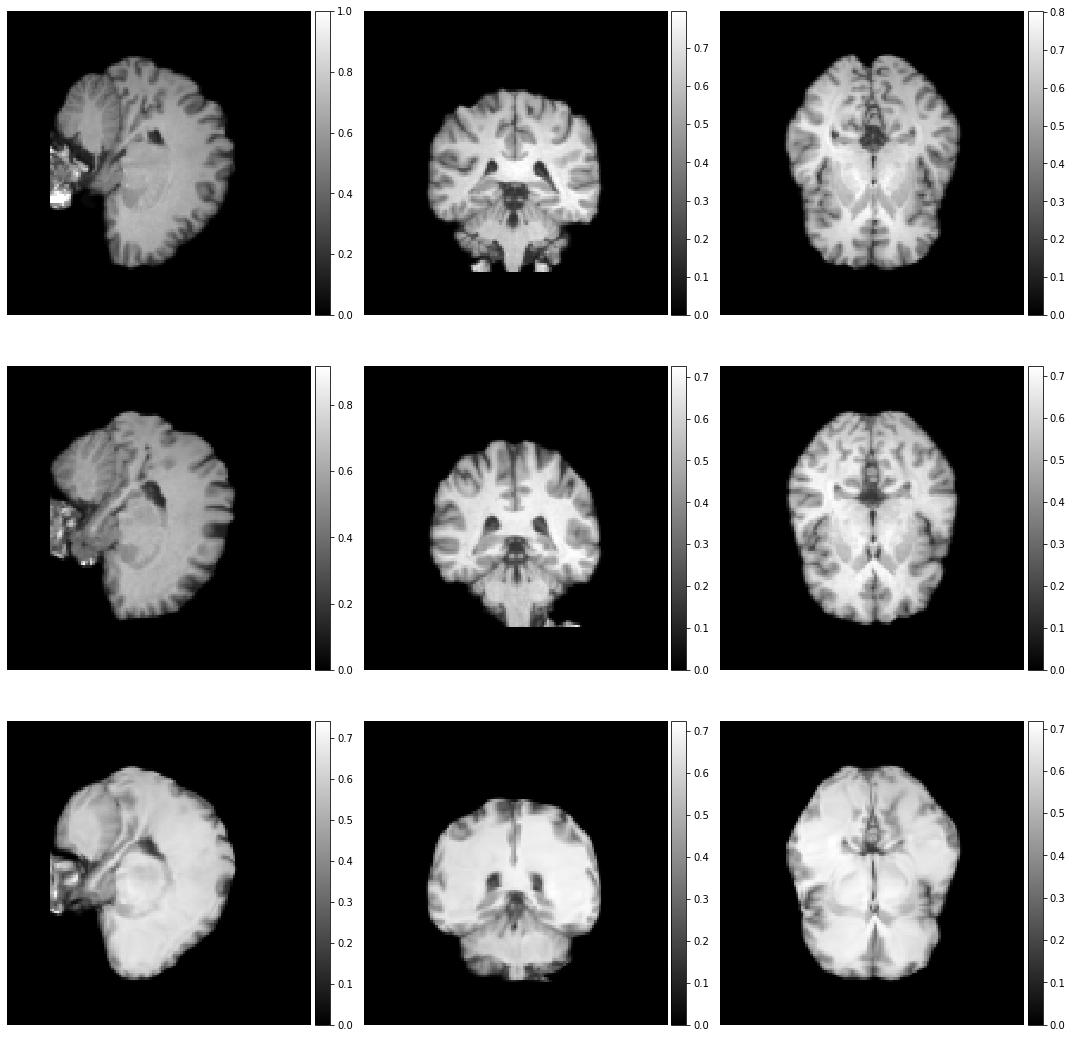

In [ ]:
mid_slices_fixed = [np.take(mynb_np1, 53, axis=d) for d in range(3)]
mid_slices_fixed[1] = np.rot90(mid_slices_fixed[1], 1)
mid_slices_fixed[2] = np.rot90(mid_slices_fixed[2], -1)

mid_slices_moving = [np.take(mynb_np2, 53, axis=d) for d in range(3)]
mid_slices_moving[1] = np.rot90(mid_slices_moving[1], 1)
mid_slices_moving[2] = np.rot90(mid_slices_moving[2], -1)

mid_slices_pred = [np.take(warped_img_np, 53, axis=d) for d in range(3)]
mid_slices_pred[1] = np.rot90(mid_slices_pred[1], 1)
mid_slices_pred[2] = np.rot90(mid_slices_pred[2], -1)
ne.plot.slices(mid_slices_fixed + mid_slices_moving + mid_slices_pred, cmaps=['gray'], do_colorbars=True, grid=[3,3]);

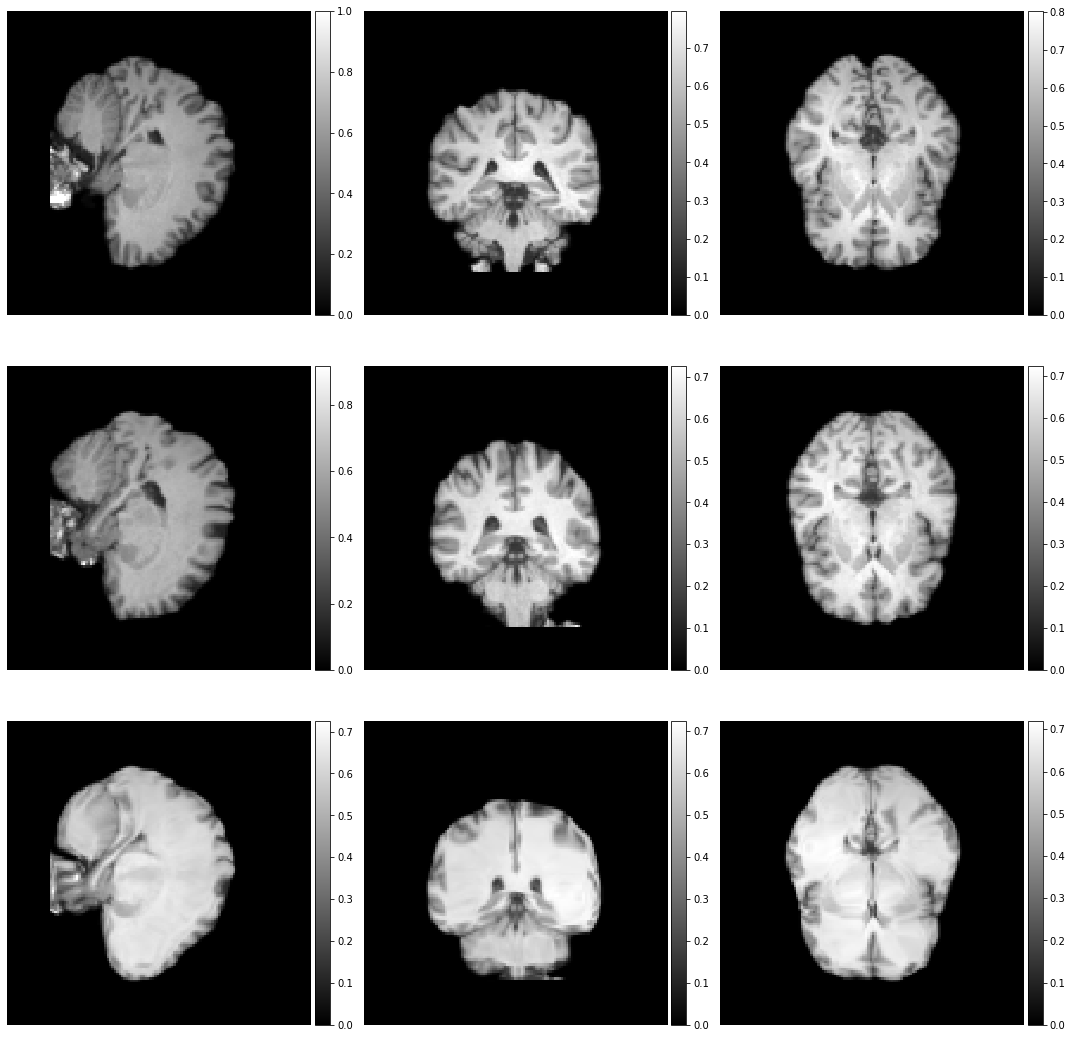

In [ ]:
mid_slices_fixed = [np.take(mynb_np1, 53, axis=d) for d in range(3)]
mid_slices_fixed[1] = np.rot90(mid_slices_fixed[1], 1)
mid_slices_fixed[2] = np.rot90(mid_slices_fixed[2], -1)

mid_slices_moving = [np.take(mynb_np2, 53, axis=d) for d in range(3)]
mid_slices_moving[1] = np.rot90(mid_slices_moving[1], 1)
mid_slices_moving[2] = np.rot90(mid_slices_moving[2], -1)

mid_slices_pred = [np.take(warped_img_np, 53, axis=d) for d in range(3)]
mid_slices_pred[1] = np.rot90(mid_slices_pred[1], 1)
mid_slices_pred[2] = np.rot90(mid_slices_pred[2], -1)
ne.plot.slices(mid_slices_fixed + mid_slices_moving + mid_slices_pred, cmaps=['gray'], do_colorbars=True, grid=[3,3]);

# SCG Concat Training

In [ ]:
del feature_extractor_training, scg_training, upsampler1_training, upsampler2_training, graph_layers1_training, graph_layers2_training, stn_deformable
torch.cuda.empty_cache()

In [ ]:
feature_extractor_training = Feature_Extractor3(2,3,8).to("cuda")

scg_training = SCG_block(in_ch=32, hidden_ch=9, node_size=(16, 16, 16)).to("cuda")

#upsampler1_training = Upsampler_net2(32).to("cuda")

#upsampler2_training = Upsampler_net2(8).to("cuda")

# upsampler1_training = Upsampler_net3(8, 4, 9, 9).to("cuda")

# upsampler2_training = Upsampler_net3(8, 3, 9, 3).to("cuda")

# upsampler3_training = Upsampler_net3(8, 2, 9, 9).to("cuda")

# upsampler4_training = Upsampler_net3(8, 1, 9, 3).to("cuda")

upsampler1_training = Upsampler_net5(8, 4, 9, 32).to("cuda")

upsampler2_training = Upsampler_net5(8, 3, 32, 16).to("cuda")

upsampler3_training = Upsampler_net5(8, 2, 16, 8).to("cuda")

upsampler4_training = Upsampler_net5(8, 1, 8, 3).to("cuda")

conv_decoder1_training = Upsampler_net4(32, 32).to("cuda")

conv_decoder2_training = Upsampler_net4(16, 16).to("cuda")

conv_decoder3_training = Upsampler_net4(8, 8).to("cuda")

conv_decoder4_training = Upsampler_net4(8, 3).to("cuda")

graph_layers1_training = GCN_Layer(32, 16, bnorm=True, activation=nn.LeakyReLU(0.2), dropout=0.1).to("cuda")

graph_layers2_training = GCN_Layer(16, 9, bnorm=True, activation=nn.LeakyReLU(0.2), dropout=0.1).to("cuda")

stn_deformable = SpatialTransformer(size=(128, 128, 128), is_affine=False).to("cuda")

weight_xavier_init(graph_layers1_training, graph_layers2_training, scg_training)

for param in stn_deformable.parameters():
  param.requires_grad = False
  param.volatile=True

In [ ]:
checkpoint = torch.load('/content/drive/My Drive/Image_Registration_Project/scgnet_changed/scgnet_upsampling_concat_all_50.pth')

feature_extractor_training.load_state_dict(checkpoint['feature_extractor_training'])
scg_training.load_state_dict(checkpoint['scg_training'])
upsampler1_training.load_state_dict(checkpoint["upsampler1_training"])
upsampler2_training.load_state_dict(checkpoint['upsampler2_training'])
upsampler3_training.load_state_dict(checkpoint["upsampler3_training"])
upsampler4_training.load_state_dict(checkpoint['upsampler4_training'])
conv_decoder1_training.load_state_dict(checkpoint["conv_decoder1_training"])
conv_decoder2_training.load_state_dict(checkpoint["conv_decoder2_training"])
conv_decoder3_training.load_state_dict(checkpoint["conv_decoder3_training"])
conv_decoder4_training.load_state_dict(checkpoint["conv_decoder4_training"])
graph_layers1_training.load_state_dict(checkpoint['graph_layers1_training'])
graph_layers2_training.load_state_dict(checkpoint['graph_layers2_training'])

<All keys matched successfully>

In [ ]:
similarity_loss = NormalizedCrossCorrelation().to("cuda")
smoothness_loss = Smoothnessloss().to("cuda")
lr=1e-4

In [ ]:
optimizer = torch.optim.Adam( list( feature_extractor_training.parameters()) + list( scg_training.parameters() ) + 
                             list(upsampler1_training.parameters()) + list(upsampler2_training.parameters()) + 
                             list(upsampler3_training.parameters()) + list(upsampler4_training.parameters()) + 
                             list( graph_layers1_training.parameters()) + list( graph_layers2_training.parameters()) +
                             list(conv_decoder1_training.parameters()) + list(conv_decoder2_training.parameters()) + 
                             list(conv_decoder3_training.parameters()) + list(conv_decoder4_training.parameters()), lr=lr ) 
model_dir = '/content/drive/My Drive/Image_Registration_Project/scgnet_changed'

if not os.path.isdir(model_dir):
  os.mkdir(model_dir)

In [ ]:
mylst = [-0.3, 0.3, -0.2, 0.2]
sum(abs(x) for x in mylst)

1.0

In [ ]:
def fullmodel_one_epoch_run(epoch=1):
  example_number = 0
  cc_loss_lst = []
  smoothness_loss_lst = []
  scg_loss_lst = []
  for X,Y in training_generator:

    X = X.float().to("cuda")
    Y = Y.float().to("cuda")

    x_size = X.size()

    enc_1, enc_2, enc_3, enc_4 = feature_extractor_training(X, Y)
    #print(feature_extractor_op.shape)
    #print()

    A, gx, scg_loss, z_hat = scg_training(enc_4)
    
    B, C, H, W, D = enc_4.size()
    #print(A.shape, gx.shape, loss.shape, z_hat.shape, gx.reshape(B, -1, C).shape)
    #print(loss)
    #print()

    gop_layers1, A_layers1 = graph_layers1_training((gx.reshape(B, -1, C), A))
    #print(gop_layers1.shape, A_layers1.shape)
    #print()
    
    gop_layers2, A_layers2 = graph_layers2_training((gop_layers1, A_layers1))
    #print(gop_layers2.shape, A_layers2.shape)

    #gop_layers3, A_layers3 = graph_layers3_training((gop_layers2, A_layers2))

    gop_layers2 = gop_layers2 + z_hat

    gx = gop_layers2.reshape(B, 9, 16, 16, 16)

    gx = F.interpolate(gx, (H, W, D), mode='trilinear', align_corners=False)
    #print(gx.shape)

    # Adding information from feature extractor directly to latent space info, this could provide a path for gradients to move faster
    gx = upsampler1_training(gx, enc_4)
    gx = conv_decoder1_training(gx)
    #print(gx.shape)

    #gx = F.interpolate(gx, (64, 64, 64), mode='trilinear', align_corners=False)

    gx = upsampler2_training(gx, enc_3)
    gx = conv_decoder2_training(gx)

    dvf = upsampler3_training(gx, enc_2)
    dvf = conv_decoder3_training(dvf)
    dvf = conv_decoder4_training(dvf)
    #print(gx.shape)

    #gx = F.interpolate(gx, x_size[2:], mode='trilinear', align_corners=False)

    #dvf = upsampler4_training(gx, enc_1)
    #print(dvf.shape)

    fully_warped_image =  stn_deformable(Y, dvf)

    cc_loss = similarity_loss(X, fully_warped_image)
    sm_loss = smoothness_loss(dvf)

    total_loss = -3.0 * cc_loss + 10.0 * scg_loss + 0.001 * sm_loss

    optimizer.zero_grad()          
    total_loss.backward() 
    optimizer.step()

    cc_loss_lst.append(cc_loss.detach().cpu().numpy().item())
    smoothness_loss_lst.append(sm_loss.detach().cpu().numpy().item())
    scg_loss_lst.append(scg_loss.detach().cpu().numpy().item())
    #print("============= =============== ===========")

    del X, Y, enc_1, enc_2, enc_3, enc_4, A, gx, z_hat, gop_layers1, A_layers1, gop_layers2, A_layers2, dvf, fully_warped_image
    torch.cuda.empty_cache() 
   
    example_number = example_number + 1
    


  if (epoch%2 == 0):
    modelname = model_dir + '/' + "scgnet_upsampling_concat_deconv_new_" + str(epoch+32) + '.pth'
    torch.save({"feature_extractor_training": feature_extractor_training.state_dict(), "scg_training": scg_training.state_dict(), 
                "upsampler1_training": upsampler1_training.state_dict(), "upsampler2_training": upsampler2_training.state_dict(),
                "upsampler3_training": upsampler3_training.state_dict(), "upsampler4_training": upsampler4_training.state_dict(), 
                "graph_layers1_training": graph_layers1_training.state_dict(), "graph_layers2_training": graph_layers2_training.state_dict(),
                "conv_decoder1_training": conv_decoder1_training.state_dict(), "conv_decoder2_training": conv_decoder2_training.state_dict(),
                "conv_decoder3_training": conv_decoder3_training.state_dict(), "conv_decoder4_training": conv_decoder4_training.state_dict()}, modelname)
    print("epoch: {}".format(epoch+32))
    print("Losses: {}, {} {} and {}".format(cc_loss * -1.0, scg_loss * 10.0, 0.00001 * sm_loss, total_loss))
    print("Average Losses: {}, {} {}".format(sum(cc_loss_lst)/len(cc_loss_lst), sum(abs(x) for x in smoothness_loss_lst)/len(smoothness_loss_lst) ,
                                            sum(abs(x) for x in scg_loss_lst)/len(scg_loss_lst) ) )
    print("Saving model checkpoints")
    print("======= =============== ===========")
    print()
  
  return cc_loss_lst, smoothness_loss_lst, scg_loss_lst

In [ ]:
epochs = 31
a = []
b = []
c = []
for e in range(epochs):
  m,n,o = fullmodel_one_epoch_run(epoch=e)
  a.append(m)
  b.append(n)
  c.append(o)

epoch: 32
Losses: -0.9200097918510437, 0.0006647073314525187 0.0019491013372316957 and -2.5644545555114746
Average Losses: 0.9474317699670791, 211.55943794250487 7.153804672270781e-05
Saving model checkpoints
======= =============== ===========

epoch: 34
Losses: -0.9679490327835083, 0.0006770280888304114 0.0016376451821997762 and -2.739405632019043
Average Losses: 0.946327543258667, 170.0313465118408 7.205012680060463e-05
Saving model checkpoints
======= =============== ===========

epoch: 36
Losses: -0.9448356032371521, 0.0007170707685872912 0.0017227260395884514 and -2.6615169048309326
Average Losses: 0.9477474346756936, 161.6432735443115 6.601600452995626e-05
Saving model checkpoints
======= =============== ===========

epoch: 38
Losses: -0.9331548810005188, 0.0006733344634994864 0.0016244857106357813 and -2.636342763900757
Average Losses: 0.9475928515195846, 158.4365390777588 6.82688012602739e-05
Saving model checkpoints
======= =============== ===========

epoch: 40
Losses: -0.94

# SCG Concat Validation

In [ ]:
del  feature_extractor_inference, upsampler1_inference, upsampler2_inference, scg_inference, graph_layers1_inference, graph_layers2_inference, stn_deformable_inference
torch.cuda.empty_cache()

In [ ]:
feature_extractor_inference = Feature_Extractor3(2,3,8).to("cuda")

scg_inference = SCG_block(in_ch=32, hidden_ch=9, node_size=(16, 16, 16)).to("cuda")

graph_layers1_inference = GCN_Layer(32, 16, bnorm=True, activation=nn.LeakyReLU(0.2), dropout=0.0).to("cuda")

graph_layers2_inference = GCN_Layer(16, 9, bnorm=True, activation=nn.LeakyReLU(0.2), dropout=0.0).to("cuda")

graph_layers3_inference= GCN_Layer(8, 3, bnorm=False, activation=None).to("cuda")

# upsampler1_inference = Upsampler_net2(32).to("cuda")

# upsampler2_inference = Upsampler_net2(8).to("cuda")

# upsampler1_inference = Upsampler_net3(8, 4, 9, 9).to("cuda")

# upsampler2_inference = Upsampler_net3(8, 1, 9, 3).to("cuda")

# upsampler1_inference = Upsampler_net3(8, 4, 9, 9).to("cuda")

# upsampler2_inference = Upsampler_net3(8, 3, 9, 3).to("cuda")

# upsampler3_inference = Upsampler_net3(8, 2, 9, 9).to("cuda")

# upsampler4_inference = Upsampler_net3(8, 1, 9, 3).to("cuda")

# upsampler1_inference = Upsampler_net5(8, 4, 9, 32).to("cuda")

# upsampler2_inference = Upsampler_net5(8, 3, 32, 16).to("cuda")

# upsampler3_inference = Upsampler_net5(8, 2, 16, 3).to("cuda")

# upsampler4_inference = Upsampler_net5(8, 1, 8, 3).to("cuda")

upsampler1_inference = Upsampler_net5(8, 4, 9, 32).to("cuda")

upsampler2_inference = Upsampler_net5(8, 3, 32, 16).to("cuda")

upsampler3_inference = Upsampler_net5(8, 2, 16, 8).to("cuda")

upsampler4_inference = Upsampler_net5(8, 1, 8, 3).to("cuda")

conv_decoder1_inference = Upsampler_net4(32, 32).to("cuda")

conv_decoder2_inference = Upsampler_net4(16, 16).to("cuda")

conv_decoder3_inference = Upsampler_net4(8, 8).to("cuda")

conv_decoder4_inference = Upsampler_net4(8, 3).to("cuda")

stn_deformable_inference = SpatialTransformer(size=(128, 128, 128), is_affine=False).to("cuda")

for param in stn_deformable_inference.parameters():
  param.requires_grad = False
  param.volatile=True

In [ ]:
checkpoint = torch.load('/content/drive/My Drive/Image_Registration_Project/scgnet_changed/scgnet_upsampling_concat_deconv_new_28.pth')

feature_extractor_inference.load_state_dict(checkpoint['feature_extractor_training'])
scg_inference.load_state_dict(checkpoint['scg_training'])
graph_layers1_inference.load_state_dict(checkpoint['graph_layers1_training'])
graph_layers2_inference.load_state_dict(checkpoint['graph_layers2_training'])

upsampler1_inference.load_state_dict(checkpoint["upsampler1_training"])
upsampler2_inference.load_state_dict(checkpoint["upsampler2_training"])
upsampler3_inference.load_state_dict(checkpoint["upsampler3_training"])
upsampler4_inference.load_state_dict(checkpoint["upsampler4_training"])

conv_decoder1_inference.load_state_dict(checkpoint["conv_decoder1_training"])
conv_decoder2_inference.load_state_dict(checkpoint["conv_decoder2_training"])
conv_decoder3_inference.load_state_dict(checkpoint["conv_decoder3_training"])
conv_decoder4_inference.load_state_dict(checkpoint["conv_decoder4_training"])

feature_extractor_inference.eval()
upsampler1_inference.eval()
upsampler2_inference.eval()
upsampler3_inference.eval()
upsampler4_inference.eval()
conv_decoder1_inference.eval()
conv_decoder2_inference.eval()
conv_decoder3_inference.eval()
conv_decoder4_inference.eval()
scg_inference.eval()
graph_layers1_inference.eval()
graph_layers2_inference.eval()


GCN_Layer(
  (fc): Sequential(
    (0): Linear(in_features=16, out_features=9, bias=True)
    (1): BatchNorm_GCN(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Dropout(p=0.0, inplace=False)
  )
)

In [ ]:
def fullmodel_inference_loop(epoch=1):
  example_number = 0
  counter = 0
  for X,Y in validation_generator:

    X = X.float().to("cuda")
    Y = Y.float().to("cuda")

    x_size = X.size()

    enc_1, enc_2, enc_3, enc_4 = feature_extractor_inference(X, Y)

    A, gx, scg_loss, z_hat = scg_inference(enc_4)
    
    B, C, H, W, D = enc_4.size()

    gop_layers1, A_layers1 = graph_layers1_inference((gx.reshape(B, -1, C), A))

    gop_layers2, A_layers2 = graph_layers2_inference((gop_layers1, A_layers1))

    #gop_layers3, A_layers3 = graph_layers3_inference((gop_layers2, A_layers2))

    gop_layers2 = gop_layers2 + z_hat

    gx = gop_layers2.reshape(B, 9, 16, 16, 16)

    gx = F.interpolate(gx, (H, W, D), mode='trilinear', align_corners=False)

    # Adding information from feature extractor directly to latent space info, this could provide a path for gradients to move faster
    gx = upsampler1_inference(gx, enc_4)
    gx = conv_decoder1_inference(gx)
    #gx = F.interpolate(gx, (64, 64, 64), mode='trilinear', align_corners=False)
    gx = upsampler2_inference(gx, enc_3)
    gx = conv_decoder2_inference(gx)

    dvf = upsampler3_inference(gx, enc_2)
    dvf = conv_decoder3_inference(dvf)
    dvf = conv_decoder4_inference(dvf)

    #gx = F.interpolate(gx, x_size[2:], mode='trilinear', align_corners=False)

    #dvf = upsampler4_inference(gx, enc_1)

    #dvf = F.interpolate(gx, x_size[2:], mode='trilinear', align_corners=False)

    fully_warped_image =  stn_deformable_inference(Y, dvf)

    full_warped_np = fully_warped_image.detach().to("cpu").numpy()
    full_warped_nb = nb.Nifti1Image(full_warped_np[0,0,:,:,:], np.eye(4)) 
    nb.save(full_warped_nb, '/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/warped_images/' +  'scgnet_16_full_warped_nb_' + str(counter) + '.nii.gz')

    counter = counter + 1
    print(counter)
    del enc_1, enc_2, enc_3, enc_4, A, gx, z_hat, gop_layers1, A_layers1, gop_layers2, A_layers2, fully_warped_image, dvf
   
    if(counter > 3):
      break;
    

In [ ]:
fullmodel_inference_loop()

1
2
3
4


In [ ]:
fully_warped_img = nb.load("/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/warped_images/scgnet_16_full_warped_nb_0.nii.gz")
warped_img_np = fully_warped_img.dataobj

mynb_np1 = imgnorm(load_4D_200(file_names_t1[0]))
mynb_np1 = mynb_np1[0,:,:,:]
mynb_np2 = imgnorm(load_4D_200(file_names_t1[4]))
mynb_np2 = imgnorm(mynb_np2[0,:,:,:])
vol_shape = (128, 128, 128)

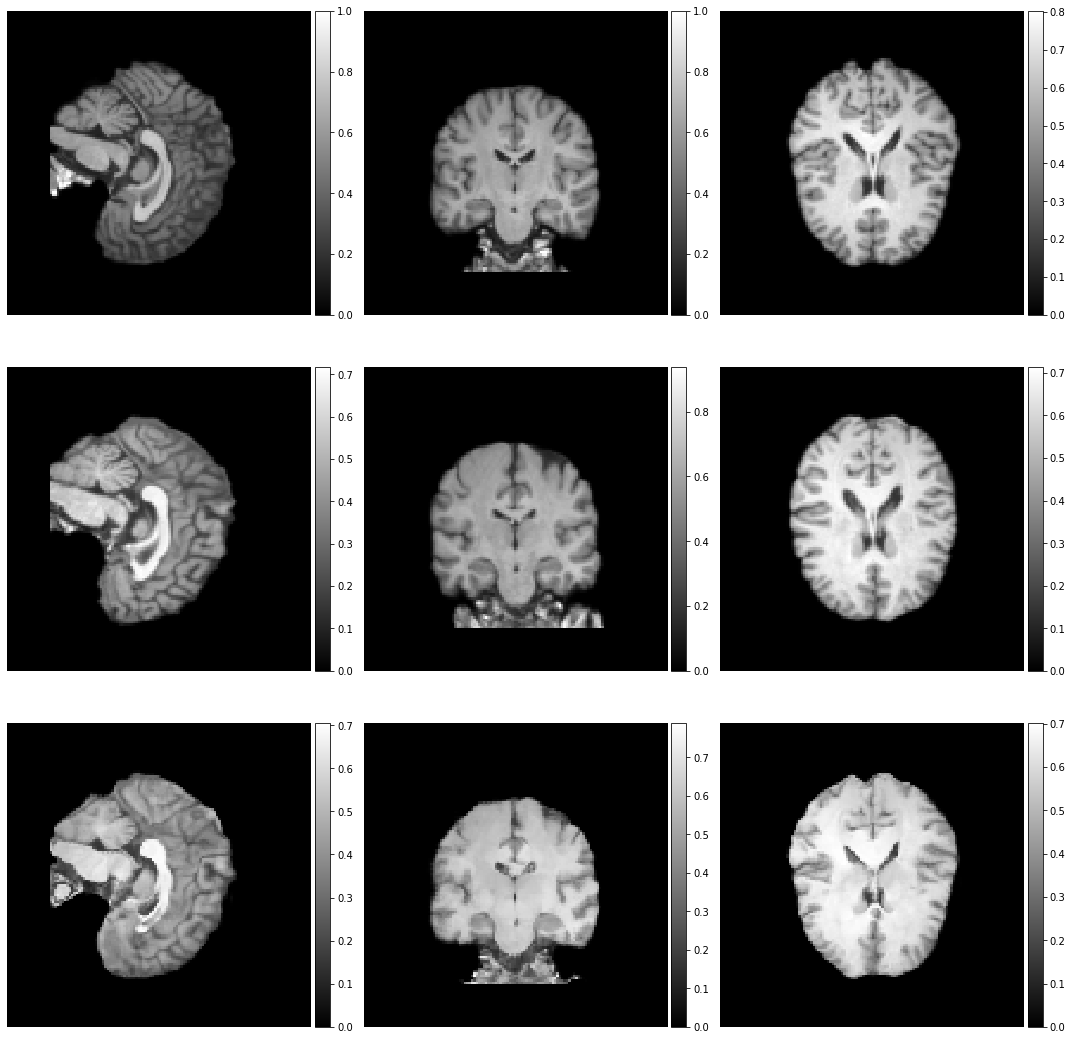

In [ ]:
mid_slices_fixed = [np.take(mynb_np1, 63, axis=d) for d in range(3)]
mid_slices_fixed[1] = np.rot90(mid_slices_fixed[1], 1)
mid_slices_fixed[2] = np.rot90(mid_slices_fixed[2], -1)

mid_slices_moving = [np.take(mynb_np2, 63, axis=d) for d in range(3)]
mid_slices_moving[1] = np.rot90(mid_slices_moving[1], 1)
mid_slices_moving[2] = np.rot90(mid_slices_moving[2], -1)

mid_slices_pred = [np.take(warped_img_np, 63, axis=d) for d in range(3)]
mid_slices_pred[1] = np.rot90(mid_slices_pred[1], 1)
mid_slices_pred[2] = np.rot90(mid_slices_pred[2], -1)
ne.plot.slices(mid_slices_fixed + mid_slices_moving + mid_slices_pred, cmaps=['gray'], do_colorbars=True, grid=[3,3]);

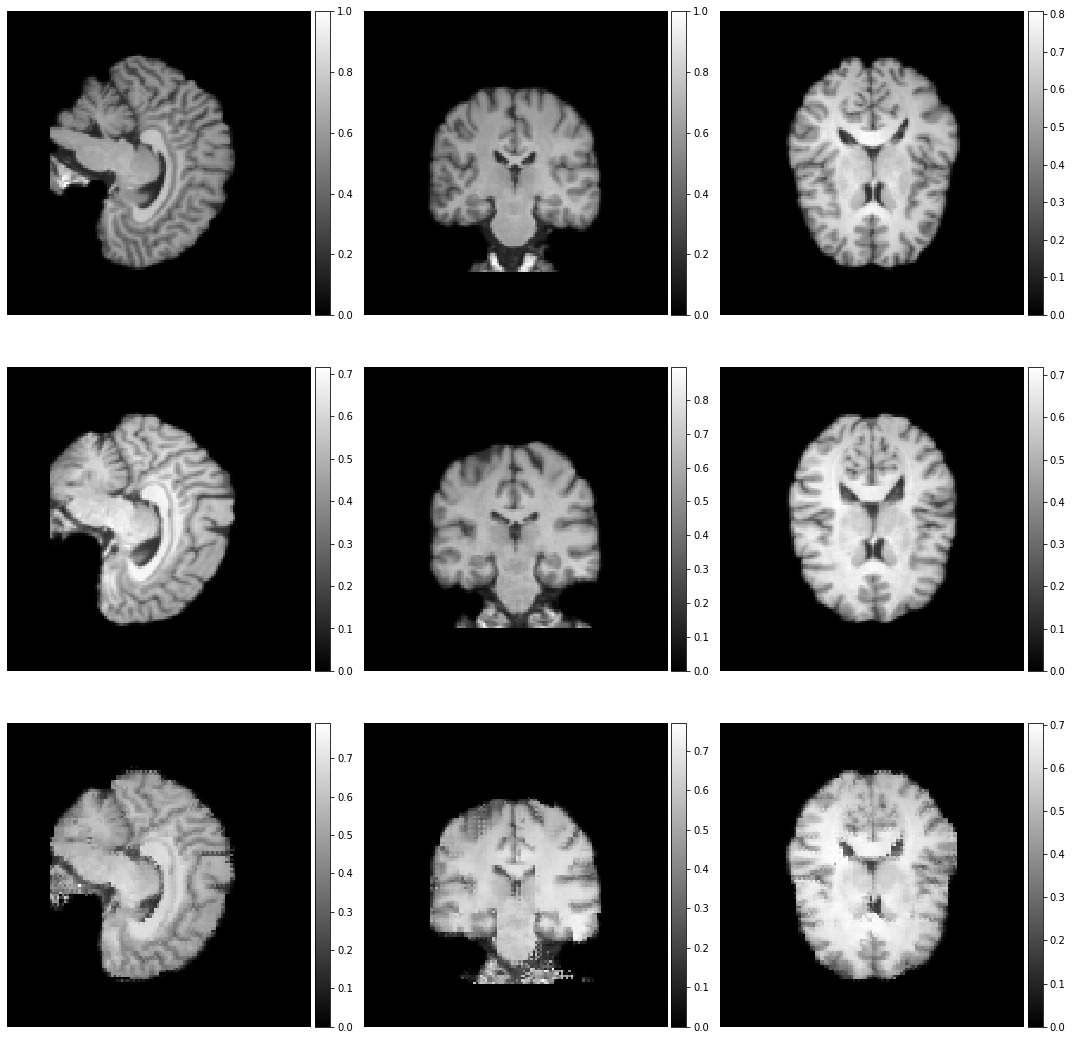

In [ ]:
mid_slices_fixed = [np.take(mynb_np1, 60, axis=d) for d in range(3)]
mid_slices_fixed[1] = np.rot90(mid_slices_fixed[1], 1)
mid_slices_fixed[2] = np.rot90(mid_slices_fixed[2], -1)

mid_slices_moving = [np.take(mynb_np2, 60, axis=d) for d in range(3)]
mid_slices_moving[1] = np.rot90(mid_slices_moving[1], 1)
mid_slices_moving[2] = np.rot90(mid_slices_moving[2], -1)

mid_slices_pred = [np.take(warped_img_np, 60, axis=d) for d in range(3)]
mid_slices_pred[1] = np.rot90(mid_slices_pred[1], 1)
mid_slices_pred[2] = np.rot90(mid_slices_pred[2], -1)
ne.plot.slices(mid_slices_fixed + mid_slices_moving + mid_slices_pred, cmaps=['gray'], do_colorbars=True, grid=[3,3]);

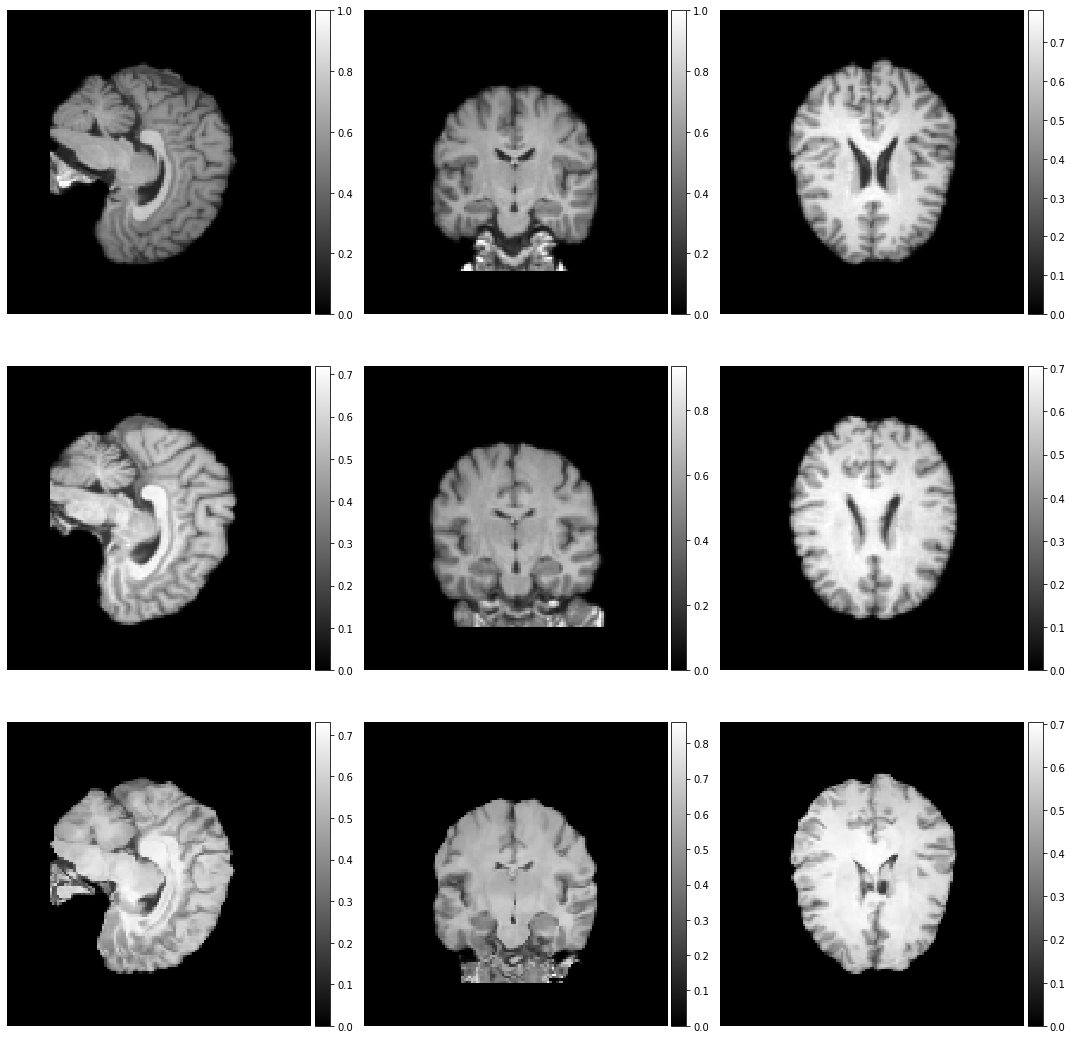

In [ ]:
mid_slices_fixed = [np.take(mynb_np1, 65, axis=d) for d in range(3)]
mid_slices_fixed[1] = np.rot90(mid_slices_fixed[1], 1)
mid_slices_fixed[2] = np.rot90(mid_slices_fixed[2], -1)

mid_slices_moving = [np.take(mynb_np2, 65, axis=d) for d in range(3)]
mid_slices_moving[1] = np.rot90(mid_slices_moving[1], 1)
mid_slices_moving[2] = np.rot90(mid_slices_moving[2], -1)

mid_slices_pred = [np.take(warped_img_np, 65, axis=d) for d in range(3)]
mid_slices_pred[1] = np.rot90(mid_slices_pred[1], 1)
mid_slices_pred[2] = np.rot90(mid_slices_pred[2], -1)
ne.plot.slices(mid_slices_fixed + mid_slices_moving + mid_slices_pred, cmaps=['gray'], do_colorbars=True, grid=[3,3]);

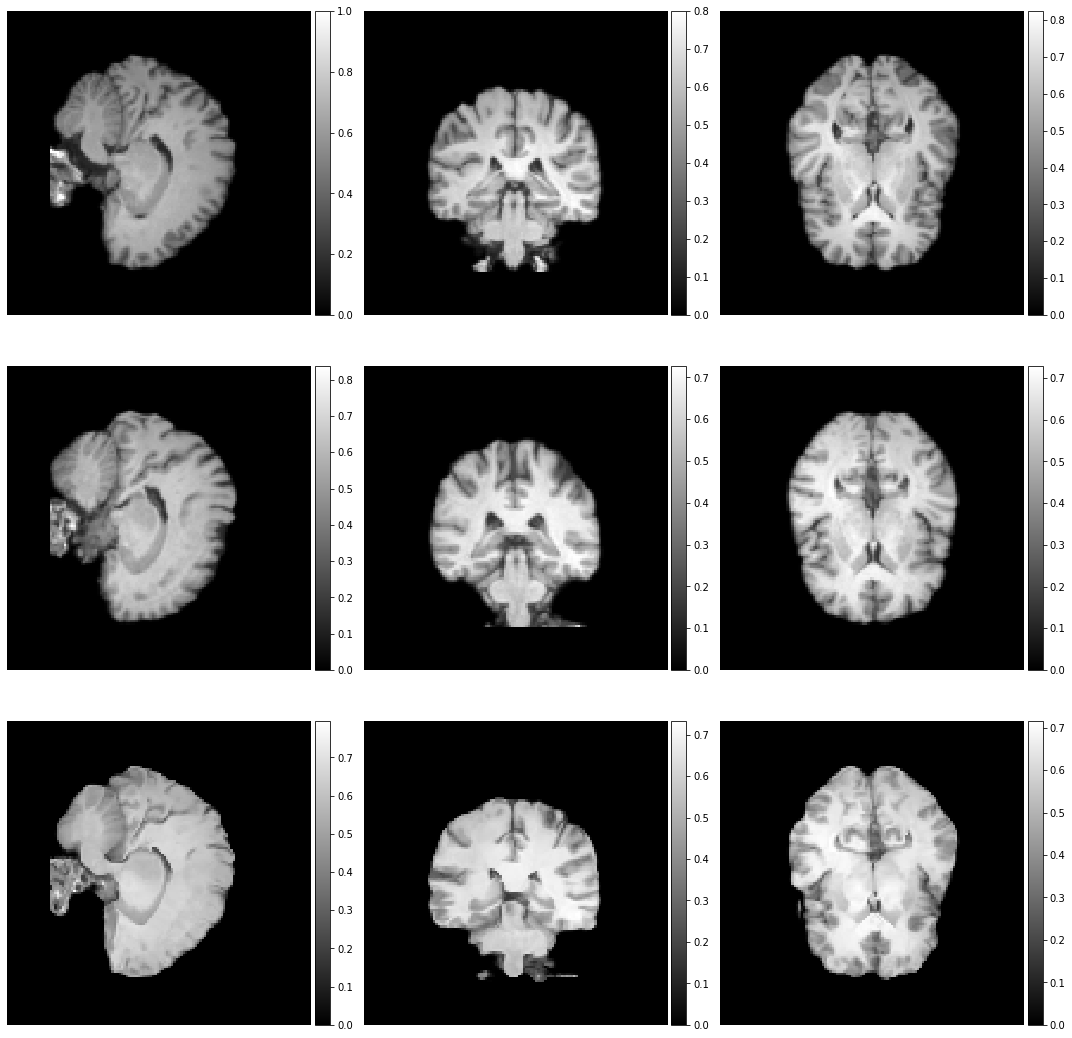

In [ ]:
mid_slices_fixed = [np.take(mynb_np1, 55, axis=d) for d in range(3)]
mid_slices_fixed[1] = np.rot90(mid_slices_fixed[1], 1)
mid_slices_fixed[2] = np.rot90(mid_slices_fixed[2], -1)

mid_slices_moving = [np.take(mynb_np2, 55, axis=d) for d in range(3)]
mid_slices_moving[1] = np.rot90(mid_slices_moving[1], 1)
mid_slices_moving[2] = np.rot90(mid_slices_moving[2], -1)

mid_slices_pred = [np.take(warped_img_np, 55, axis=d) for d in range(3)]
mid_slices_pred[1] = np.rot90(mid_slices_pred[1], 1)
mid_slices_pred[2] = np.rot90(mid_slices_pred[2], -1)
ne.plot.slices(mid_slices_fixed + mid_slices_moving + mid_slices_pred, cmaps=['gray'], do_colorbars=True, grid=[3,3]);

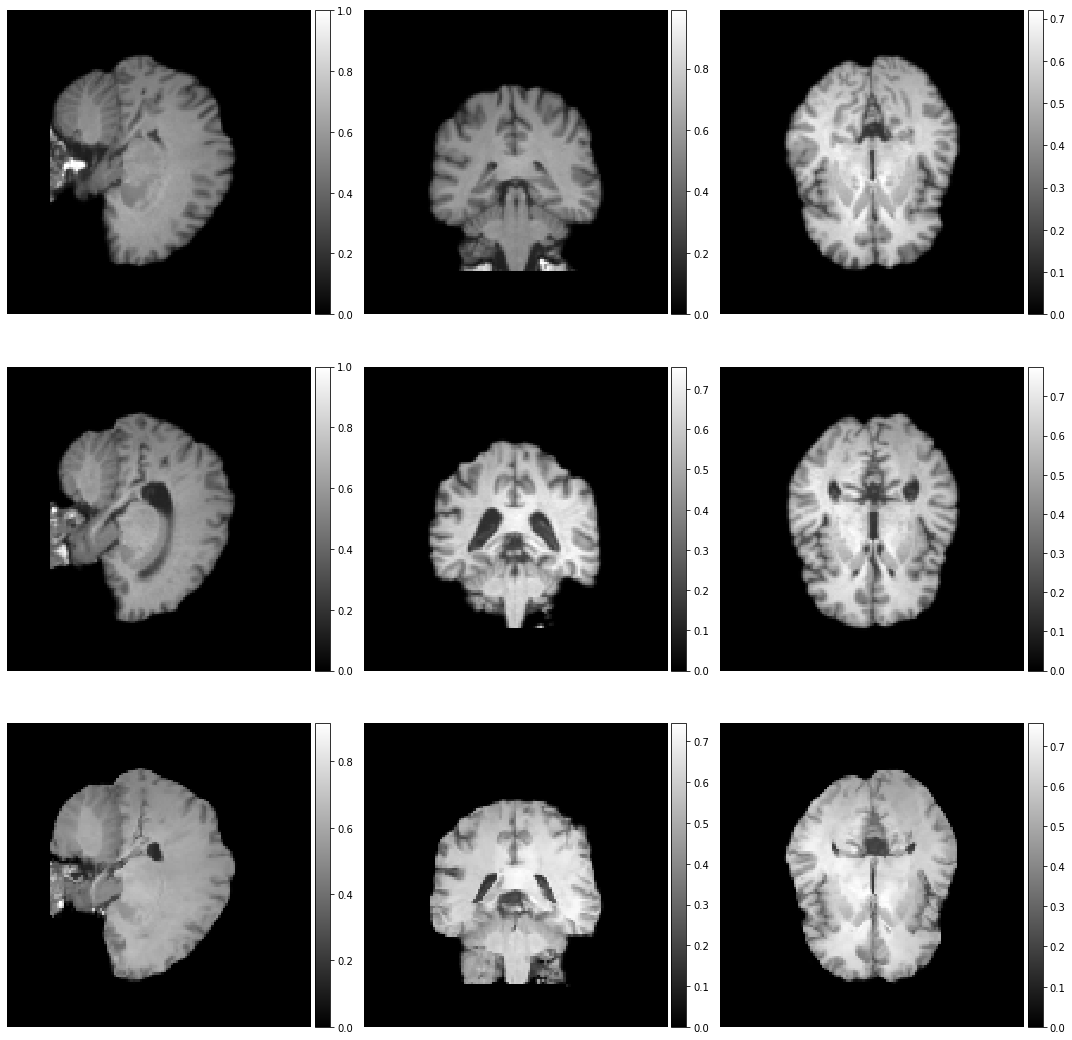

In [ ]:
mid_slices_fixed = [np.take(mynb_np1, 53, axis=d) for d in range(3)]
mid_slices_fixed[1] = np.rot90(mid_slices_fixed[1], 1)
mid_slices_fixed[2] = np.rot90(mid_slices_fixed[2], -1)

mid_slices_moving = [np.take(mynb_np2, 53, axis=d) for d in range(3)]
mid_slices_moving[1] = np.rot90(mid_slices_moving[1], 1)
mid_slices_moving[2] = np.rot90(mid_slices_moving[2], -1)

mid_slices_pred = [np.take(warped_img_np, 53, axis=d) for d in range(3)]
mid_slices_pred[1] = np.rot90(mid_slices_pred[1], 1)
mid_slices_pred[2] = np.rot90(mid_slices_pred[2], -1)
ne.plot.slices(mid_slices_fixed + mid_slices_moving + mid_slices_pred, cmaps=['gray'], do_colorbars=True, grid=[3,3]);

# Training - SCG network with input concatenated and relu batch size of 5 with some variations with/without upsconv

In [ ]:
!nvidia-smi

Thu Apr  8 06:01:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    34W /  70W |   1678MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
del feature_extractor_training, scg_training, upsampler1_training, upsampler2_training, graph_layers1_training, graph_layers2_training, stn_deformable
torch.cuda.empty_cache()

NameError: ignored

In [ ]:
feature_extractor_training = Feature_Extractor(2,3,8).to("cuda")

scg_training = SCG_block(in_ch=32, hidden_ch=3, node_size=(16, 16, 16)).to("cuda")

#upsampler1_training = Upsampler_net2(32).to("cuda")

#upsampler2_training = Upsampler_net2(8).to("cuda")

upsampler1_training = Upsampler_net3(8, 4).to("cuda")

upsampler2_training = Upsampler_net3(8, 1).to("cuda")

graph_layers1_training = GCN_Layer(32, 16, bnorm=True, activation=nn.ReLU(True), dropout=0.1).to("cuda")

graph_layers2_training = GCN_Layer(16, 8, bnorm=True, activation=nn.ReLU(True), dropout=0.1).to("cuda")

graph_layers3_training = GCN_Layer(8, 3, bnorm=False, activation=None).to("cuda")

stn_deformable = SpatialTransformer(size=(128, 128, 128), is_affine=False).to("cuda")

weight_xavier_init(graph_layers1_training, graph_layers2_training, scg_training)

for param in stn_deformable.parameters():
  param.requires_grad = False
  param.volatile=True


In [ ]:
checkpoint = torch.load('/content/drive/My Drive/Image_Registration_Project/scgnet_changed/scgnet_conv_upsampling_62.pth')

feature_extractor_training.load_state_dict(checkpoint['feature_extractor_training'])
scg_training.load_state_dict(checkpoint['scg_training'])
upsampler1_training.load_state_dict(checkpoint["upsampler1_training"])
upsampler2_training.load_state_dict(checkpoint['upsampler2_training'])
graph_layers1_training.load_state_dict(checkpoint['graph_layers1_training'])
graph_layers2_training.load_state_dict(checkpoint['graph_layers2_training'])
graph_layers3_training.load_state_dict(checkpoint['graph_layers3_training'])

<All keys matched successfully>

In [ ]:
similarity_loss = NormalizedCrossCorrelation().to("cuda")
smoothness_loss = Smoothnessloss().to("cuda")
lr=1e-4

In [ ]:
optimizer = torch.optim.Adam( list( feature_extractor_training.parameters()) + list( scg_training.parameters() ) + 
                             list(upsampler1_training.parameters()) + list(upsampler2_training.parameters()) + list( graph_layers1_training.parameters()) +
                             list( graph_layers2_training.parameters()) + list(graph_layers3_training.parameters() ), lr=lr ) 
model_dir = '/content/drive/My Drive/Image_Registration_Project/scgnet_changed'

if not os.path.isdir(model_dir):
  os.mkdir(model_dir)


In [ ]:
# X --> fixed and Y --> moving
def fullmodel_one_epoch_run(epoch=1):
  example_number = 0
  cc_loss_lst = []
  smoothness_loss_lst = []
  scg_loss_lst = []
  for X,Y in training_generator:

    X = X.float().to("cuda")
    Y = Y.float().to("cuda")

    x_size = X.size()

    feature_extractor_op, feature_extractor_op_p, enc_op_1 = feature_extractor_training(X, Y)
    #print(feature_extractor_op.shape)
    #print()

    A, gx, scg_loss, z_hat = scg_training(feature_extractor_op)
    
    B, C, H, W, D = feature_extractor_op.size()
    #print(A.shape, gx.shape, loss.shape, z_hat.shape, gx.reshape(B, -1, C).shape)
    #print(loss)
    #print()

    gop_layers1, A_layers1 = graph_layers1_training((gx.reshape(B, -1, C), A))
    #print(gop_layers1.shape, A_layers1.shape)
    #print()
    
    gop_layers2, A_layers2 = graph_layers2_training((gop_layers1, A_layers1))
    #print(gop_layers2.shape, A_layers2.shape)

    gop_layers3, A_layers3 = graph_layers3_training((gop_layers2, A_layers2))

    gop_layers3 = gop_layers3 + z_hat

    gx = gop_layers3.reshape(B, 3, 16, 16, 16)

    gx = F.interpolate(gx, (H, W, D), mode='trilinear', align_corners=False)
    #print(gx.shape)

    # Adding information from feature extractor directly to latent space info, this could provide a path for gradients to move faster
    gx = upsampler1_training(gx, feature_extractor_op)

    gx = F.interpolate(gx, x_size[2:], mode='trilinear', align_corners=False)

    dvf = upsampler2_training(gx, enc_op_1)
    #print(gx.shape)

    fully_warped_image =  stn_deformable(Y, dvf)

    cc_loss = similarity_loss(X, fully_warped_image)
    sm_loss = smoothness_loss(dvf)

    total_loss = -100.0 * cc_loss + 100.0 * scg_loss + 0.01 * sm_loss

    optimizer.zero_grad()          
    total_loss.backward() 
    optimizer.step()

    cc_loss_lst.append(cc_loss.detach().cpu().numpy().item())
    smoothness_loss_lst.append(sm_loss.detach().cpu().numpy().item())
    scg_loss_lst.append(scg_loss.detach().cpu().numpy().item())
    #print("============= =============== ===========")

    np.save(os.path.join(model_dir, "scgnet_conv_upsampling_0.npy"), np.array( [scg_loss.detach().to("cpu").numpy(), cc_loss.detach().to("cpu").numpy(), total_loss.detach().to("cpu").numpy(), 
                                                                 sm_loss.detach().to("cpu").numpy(), epoch, example_number] ))

    del X, Y, feature_extractor_op, feature_extractor_op_p, enc_op_1, A, gx, z_hat, gop_layers1, A_layers1, gop_layers2, A_layers2, gop_layers3, A_layers3, dvf, fully_warped_image
    torch.cuda.empty_cache() 
   
    example_number = example_number + 1
    


  if (epoch%2 == 0):
    modelname = model_dir + '/' + "scgnet_conv_upsampling_new1_" + str(epoch+44) + '.pth'
    torch.save({"feature_extractor_training": feature_extractor_training.state_dict(), "scg_training": scg_training.state_dict(), "upsampler1_training": upsampler1_training.state_dict(),
                "upsampler2_training": upsampler2_training.state_dict(), "graph_layers1_training": graph_layers1_training.state_dict(), "graph_layers2_training": graph_layers2_training.state_dict(), 
                "graph_layers3_training": graph_layers3_training.state_dict()}, modelname)
    print("epoch: {}".format(epoch+44))
    print("Losses: {}, {} {} and {}".format(cc_loss * -100.0, scg_loss * 100.0, 0.01 * sm_loss, total_loss))
    print("Average Losses: {}, {} {}".format(sum(cc_loss_lst)/len(cc_loss_lst), sum(smoothness_loss_lst)/len(smoothness_loss_lst) ,
                                            sum(scg_loss_lst)/len(scg_loss_lst) ) )
    print("Saving model checkpoints")
    print("======= =============== ===========")
    print()
  
  return cc_loss_lst, smoothness_loss_lst, scg_loss_lst

In [ ]:
epochs = 3
for e in range(epochs):
  fullmodel_one_epoch_run(epoch=e)

epoch: 0
Losses: -85.16380310058594, 0.026153597980737686 1.1059011220932007 and -84.03174591064453
Average Losses: 0.8184259295463562, 108.83757171630859 0.0002289537063916214
Saving model checkpoints
======= =============== ===========

epoch: 2
Losses: -79.44390869140625, 0.03620538488030434 1.2077274322509766 and -78.1999740600586
Average Losses: 0.8328868627548218, 118.1146858215332 0.0003097053908277303
Saving model checkpoints
======= =============== ===========



In [ ]:
epochs = 21
a = []
b = []
c = []
for e in range(epochs):
  m,n,o = fullmodel_one_epoch_run(epoch=e)
  a.append(m)
  b.append(n)
  c.append(o)

epoch: 44
Losses: -95.49295043945312, 0.05711998790502548 1.6572881937026978 and -93.7785415649414
Average Losses: 0.9428785741329193, 168.02131195068358 0.0006155029986985028
Saving model checkpoints
======= =============== ===========

epoch: 46
Losses: -93.91557312011719, 0.07202328741550446 1.7191317081451416 and -92.12442016601562
Average Losses: 0.9410070896148681, 176.31416931152344 0.0006242821866180748
Saving model checkpoints
======= =============== ===========

epoch: 48
Losses: -94.1006851196289, 0.06750266253948212 1.7882331609725952 and -92.24494934082031
Average Losses: 0.9414072215557099, 183.66036376953124 0.0007662499323487282
Saving model checkpoints
======= =============== ===========

epoch: 50
Losses: -92.87039184570312, 0.0905165746808052 1.8690171241760254 and -90.91085815429688
Average Losses: 0.9440623581409454, 182.12844696044922 0.0007115286309272051
Saving model checkpoints
======= =============== ===========

epoch: 52
Losses: -93.50386810302734, 0.0865089

In [ ]:
npm = np.load(os.path.join(model_dir, "scgnet_changed_loss_0.npy"))

# Inference and Visulalization

* As we can see that with just scg net it is causing too much blurring.
* This may be beacuse we need to train more nodes or make two graphs each for fixed and moving image and take a difference between them.

* With 512 nodes and some minor changes to loss function, it seems like we are recieving much better registration


In [ ]:
del  feature_extractor_inference, upsampler1_inference, scg_inference, graph_layers1_inference, graph_layers2_inference, stn_deformable_inference
torch.cuda.empty_cache()

In [ ]:
feature_extractor_inference = Feature_Extractor(2,3,8).to("cuda")

scg_inference = SCG_block(in_ch=32, hidden_ch=3, node_size=(16, 16, 16)).to("cuda")

graph_layers1_inference = GCN_Layer(32, 16, bnorm=True, activation=nn.ReLU(True), dropout=0.1).to("cuda")

graph_layers2_inference = GCN_Layer(16, 8, bnorm=True, activation=nn.ReLU(True), dropout=0.1).to("cuda")

graph_layers3_inference= GCN_Layer(8, 3, bnorm=False, activation=None).to("cuda")

# upsampler1_inference = Upsampler_net2(32).to("cuda")

# upsampler2_inference = Upsampler_net2(8).to("cuda")

upsampler1_inference = Upsampler_net3(8, 4).to("cuda")

upsampler2_inference = Upsampler_net3(8, 1).to("cuda")

stn_deformable_inference = SpatialTransformer(size=(128, 128, 128), is_affine=False).to("cuda")

for param in stn_deformable_inference.parameters():
  param.requires_grad = False
  param.volatile=True

In [ ]:
checkpoint = torch.load('/content/drive/My Drive/Image_Registration_Project/scgnet_changed/scgnet_conv_upsampling_new1_60.pth')

feature_extractor_inference.load_state_dict(checkpoint['feature_extractor_training'])
scg_inference.load_state_dict(checkpoint['scg_training'])
graph_layers1_inference.load_state_dict(checkpoint['graph_layers1_training'])
graph_layers2_inference.load_state_dict(checkpoint['graph_layers2_training'])
graph_layers3_inference.load_state_dict(checkpoint['graph_layers3_training'])
upsampler1_inference.load_state_dict(checkpoint["upsampler1_training"])
upsampler2_inference.load_state_dict(checkpoint["upsampler2_training"])

feature_extractor_inference.eval()
upsampler1_inference.eval()
upsampler2_inference.eval()
scg_inference.eval()
graph_layers1_inference.eval()
graph_layers2_inference.eval()
graph_layers3_inference.eval()

GCN_Layer(
  (fc): Sequential(
    (0): Linear(in_features=8, out_features=3, bias=True)
  )
)

In [ ]:
def fullmodel_inference_loop(epoch=1):
  example_number = 0
  counter = 0
  for X,Y in validation_generator:

    X = X.float().to("cuda")
    Y = Y.float().to("cuda")

    x_size = X.size()

    feature_extractor_op, feature_extractor_op_p, enc_op_1 = feature_extractor_inference(X, Y)

    A, gx, scg_loss, z_hat = scg_inference(feature_extractor_op)
    
    B, C, H, W, D = feature_extractor_op.size()

    gop_layers1, A_layers1 = graph_layers1_inference((gx.reshape(B, -1, C), A))

    gop_layers2, A_layers2 = graph_layers2_inference((gop_layers1, A_layers1))

    gop_layers3, A_layers3 = graph_layers3_inference((gop_layers2, A_layers2))

    gop_layers3 = gop_layers3 + z_hat

    gx = gop_layers3.reshape(B, 3, 16, 16, 16)

    gx = F.interpolate(gx, (H, W, D), mode='trilinear', align_corners=False)

    # Adding information from feature extractor directly to latent space info, this could provide a path for gradients to move faster
    gx = upsampler1_inference(gx, feature_extractor_op)

    gx = F.interpolate(gx, x_size[2:], mode='trilinear', align_corners=False)

    dvf = upsampler2_inference(gx, enc_op_1)

    #dvf = F.interpolate(gx, x_size[2:], mode='trilinear', align_corners=False)

    fully_warped_image =  stn_deformable_inference(Y, dvf)

    full_warped_np = fully_warped_image.detach().to("cpu").numpy()
    full_warped_nb = nb.Nifti1Image(full_warped_np[0,0,:,:,:], np.eye(4)) 
    nb.save(full_warped_nb, '/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/warped_images/' +  'scgnet_16_full_warped_nb_' + str(counter) + '.nii.gz')

    counter = counter + 1
    print(counter)
    del feature_extractor_op, feature_extractor_op_p, enc_op_1, A, gx, z_hat, gop_layers1, A_layers1, gop_layers2, A_layers2, gop_layers3, A_layers3, fully_warped_image, dvf
   
    if(counter > 3):
      break;
    

In [ ]:
fullmodel_inference_loop()

1
2
3
4


In [ ]:
fully_warped_img = nb.load("/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/warped_images/scgnet_16_full_warped_nb_0.nii.gz")
warped_img_np = fully_warped_img.dataobj

mynb_np1 = imgnorm(load_4D(file_names_t1[0]))
mynb_np1 = mynb_np1[0,:,:,:]
mynb_np2 = imgnorm(load_4D(file_names_t1[4]))
mynb_np2 = imgnorm(mynb_np2[0,:,:,:])
vol_shape = (128, 128, 128)

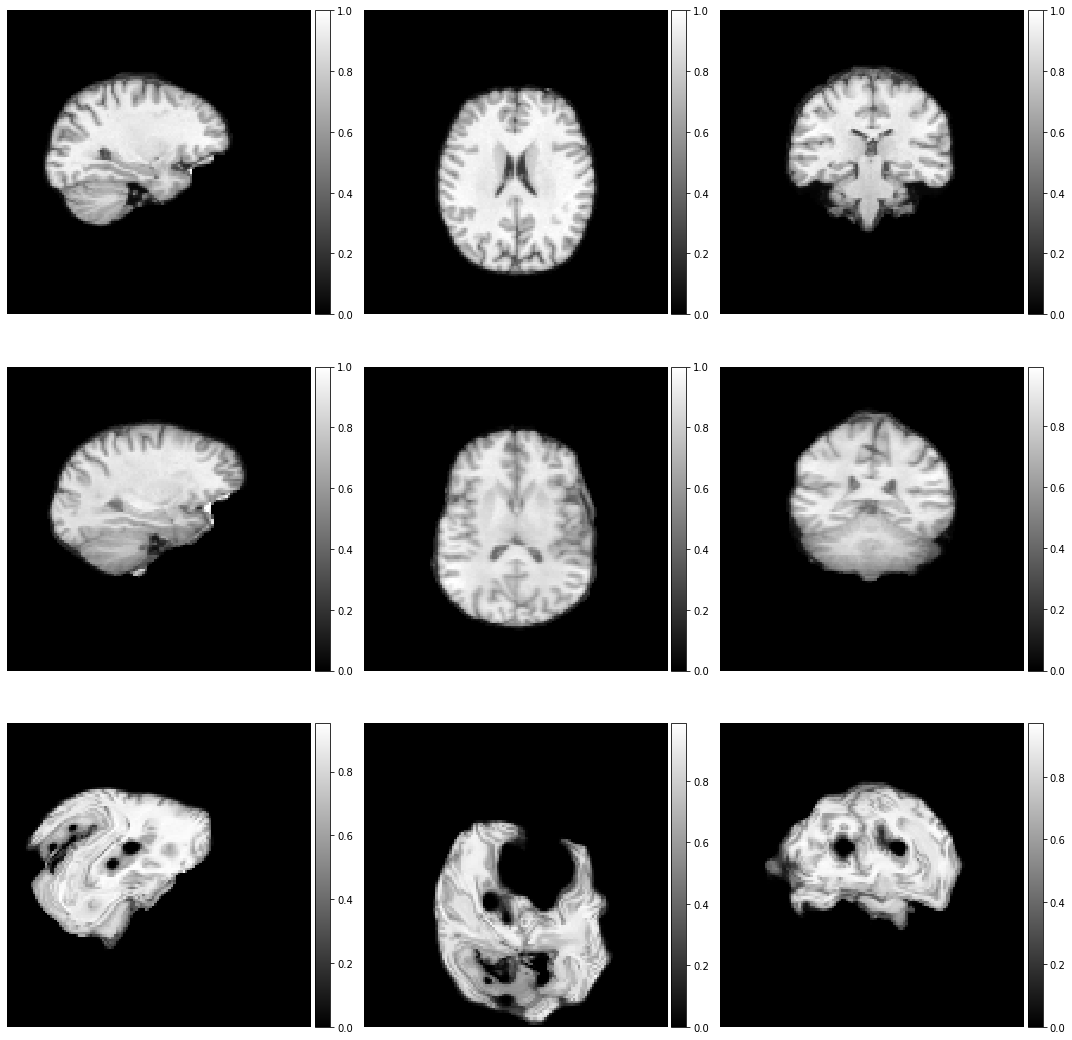

In [ ]:
mid_slices_fixed = [np.take(mynb_np1, 50, axis=d) for d in range(3)]
mid_slices_fixed[1] = np.rot90(mid_slices_fixed[1], 1)
mid_slices_fixed[2] = np.rot90(mid_slices_fixed[2], -1)

mid_slices_moving = [np.take(mynb_np2, 50, axis=d) for d in range(3)]
mid_slices_moving[1] = np.rot90(mid_slices_moving[1], 1)
mid_slices_moving[2] = np.rot90(mid_slices_moving[2], -1)

mid_slices_pred = [np.take(warped_img_np, 50, axis=d) for d in range(3)]
mid_slices_pred[1] = np.rot90(mid_slices_pred[1], 1)
mid_slices_pred[2] = np.rot90(mid_slices_pred[2], -1)
ne.plot.slices(mid_slices_fixed + mid_slices_moving + mid_slices_pred, cmaps=['gray'], do_colorbars=True, grid=[3,3]);

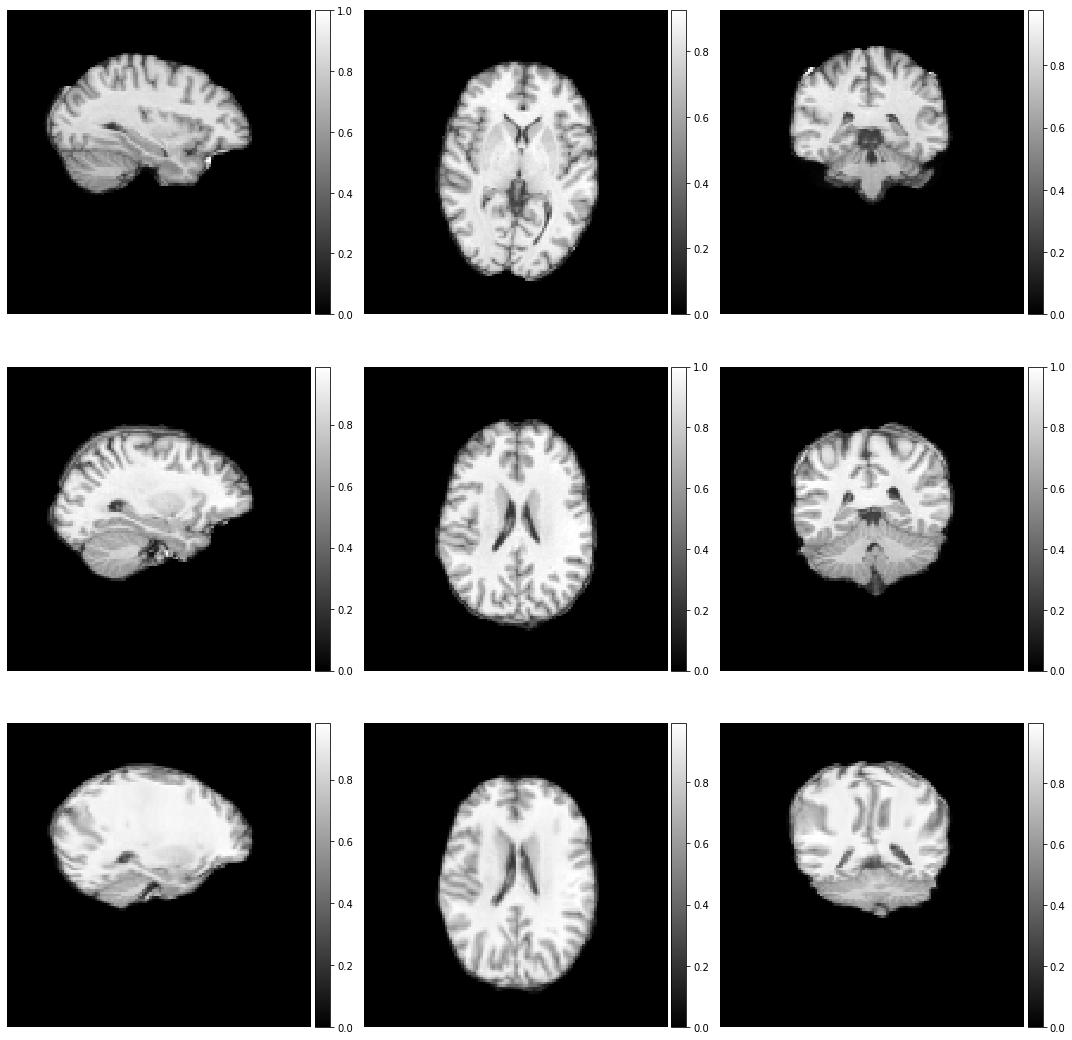

In [ ]:
mid_slices_fixed = [np.take(mynb_np1, 50, axis=d) for d in range(3)]
mid_slices_fixed[1] = np.rot90(mid_slices_fixed[1], 1)
mid_slices_fixed[2] = np.rot90(mid_slices_fixed[2], -1)

mid_slices_moving = [np.take(mynb_np2, 50, axis=d) for d in range(3)]
mid_slices_moving[1] = np.rot90(mid_slices_moving[1], 1)
mid_slices_moving[2] = np.rot90(mid_slices_moving[2], -1)

mid_slices_pred = [np.take(warped_img_np, 50, axis=d) for d in range(3)]
mid_slices_pred[1] = np.rot90(mid_slices_pred[1], 1)
mid_slices_pred[2] = np.rot90(mid_slices_pred[2], -1)
ne.plot.slices(mid_slices_fixed + mid_slices_moving + mid_slices_pred, cmaps=['gray'], do_colorbars=True, grid=[3,3]);

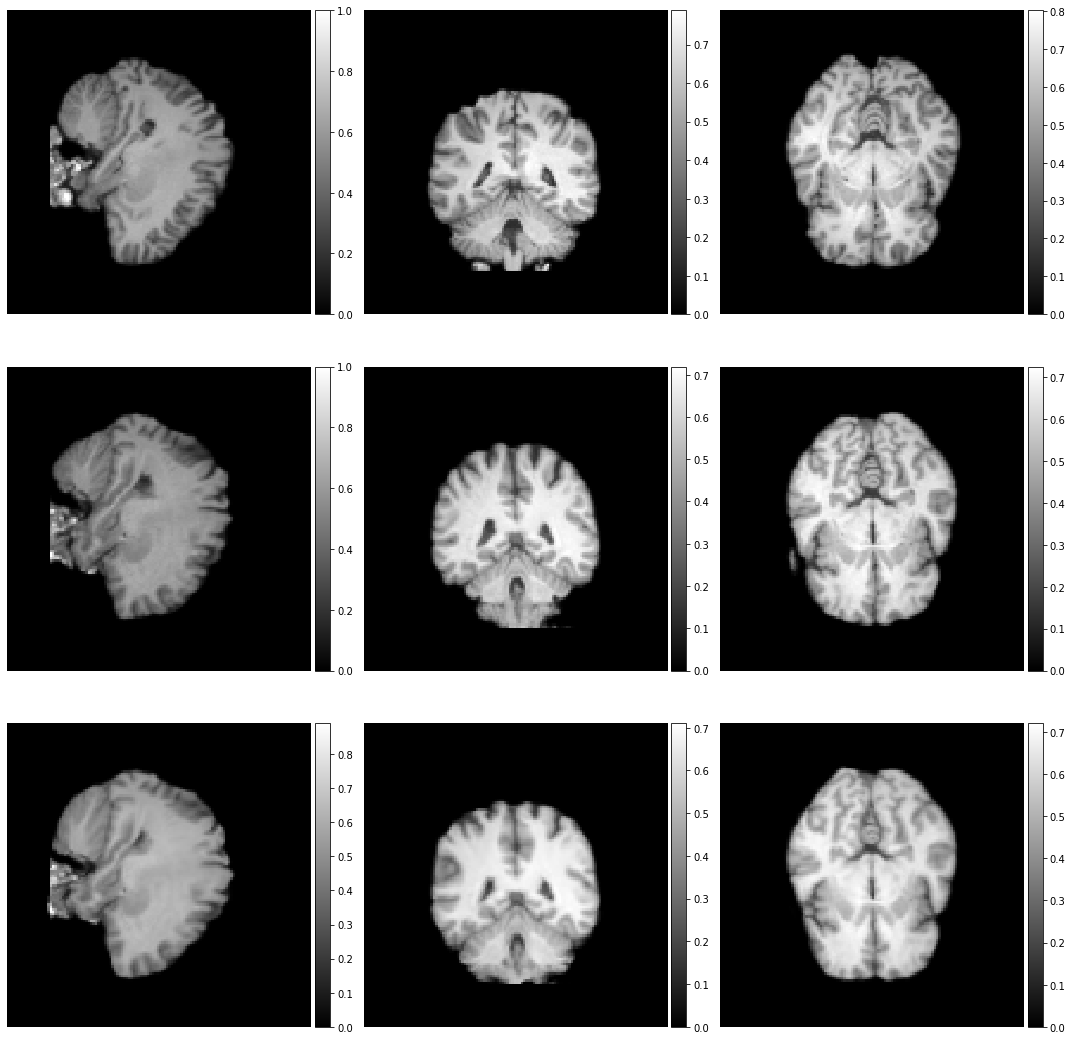

In [ ]:
mid_slices_fixed = [np.take(mynb_np1, 50, axis=d) for d in range(3)]
mid_slices_fixed[1] = np.rot90(mid_slices_fixed[1], 1)
mid_slices_fixed[2] = np.rot90(mid_slices_fixed[2], -1)

mid_slices_moving = [np.take(mynb_np2, 50, axis=d) for d in range(3)]
mid_slices_moving[1] = np.rot90(mid_slices_moving[1], 1)
mid_slices_moving[2] = np.rot90(mid_slices_moving[2], -1)

mid_slices_pred = [np.take(warped_img_np, 50, axis=d) for d in range(3)]
mid_slices_pred[1] = np.rot90(mid_slices_pred[1], 1)
mid_slices_pred[2] = np.rot90(mid_slices_pred[2], -1)
ne.plot.slices(mid_slices_fixed + mid_slices_moving + mid_slices_pred, cmaps=['gray'], do_colorbars=True, grid=[3,3]);

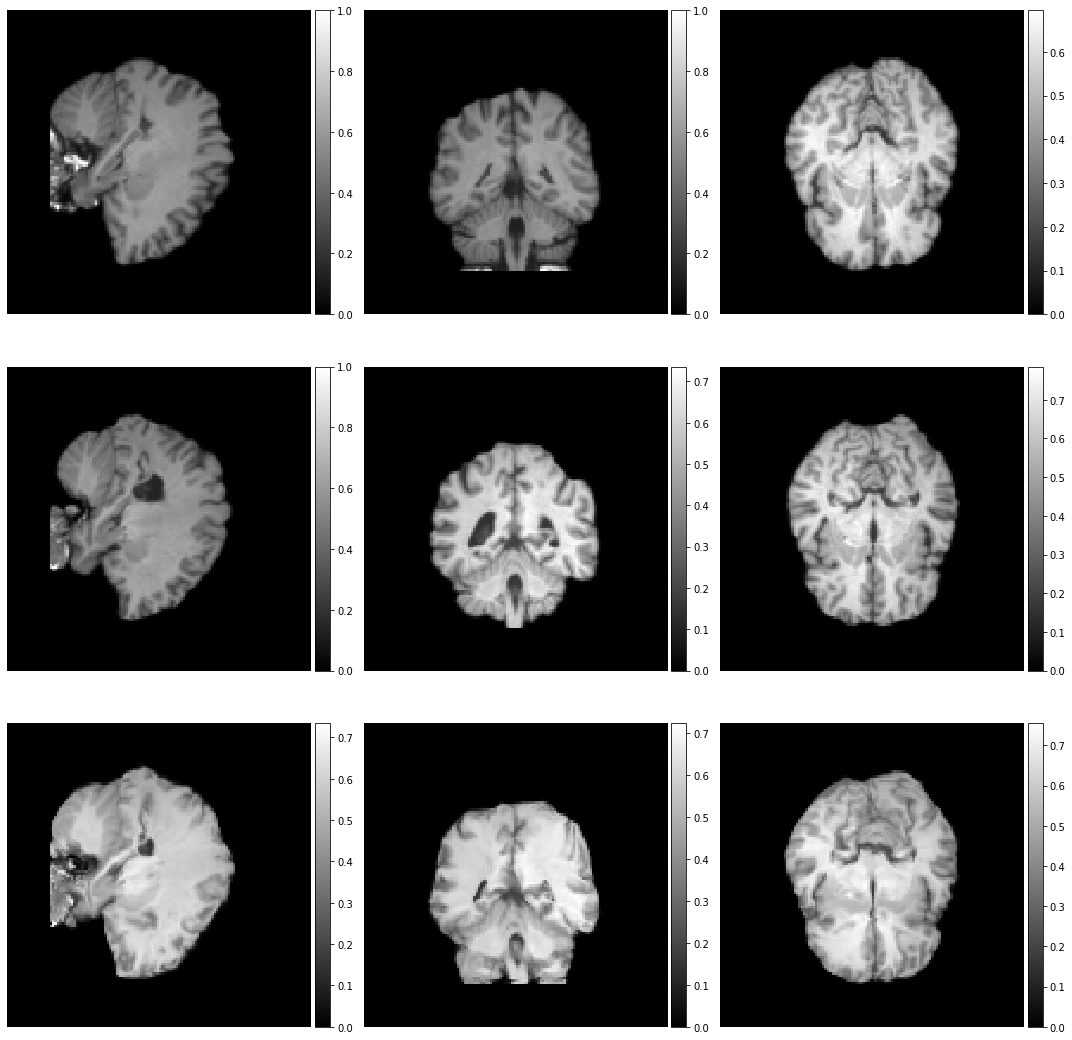

In [ ]:
mid_slices_fixed = [np.take(mynb_np1, 50, axis=d) for d in range(3)]
mid_slices_fixed[1] = np.rot90(mid_slices_fixed[1], 1)
mid_slices_fixed[2] = np.rot90(mid_slices_fixed[2], -1)

mid_slices_moving = [np.take(mynb_np2, 50, axis=d) for d in range(3)]
mid_slices_moving[1] = np.rot90(mid_slices_moving[1], 1)
mid_slices_moving[2] = np.rot90(mid_slices_moving[2], -1)

mid_slices_pred = [np.take(warped_img_np, 50, axis=d) for d in range(3)]
mid_slices_pred[1] = np.rot90(mid_slices_pred[1], 1)
mid_slices_pred[2] = np.rot90(mid_slices_pred[2], -1)
ne.plot.slices(mid_slices_fixed + mid_slices_moving + mid_slices_pred, cmaps=['gray'], do_colorbars=True, grid=[3,3]);

3 gcn layer 200 epoch

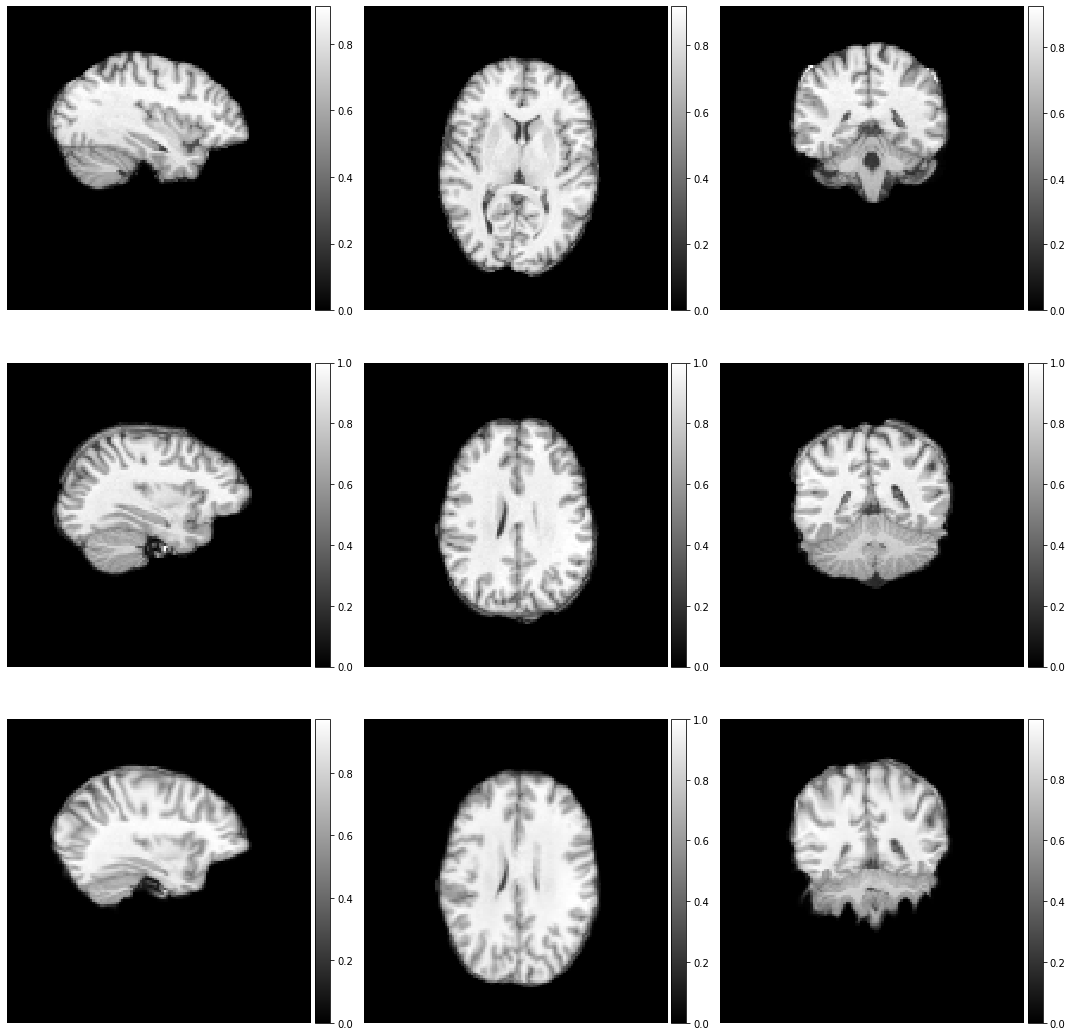

In [ ]:
mid_slices_fixed = [np.take(mynb_np1, 48, axis=d) for d in range(3)]
mid_slices_fixed[1] = np.rot90(mid_slices_fixed[1], 1)
mid_slices_fixed[2] = np.rot90(mid_slices_fixed[2], -1)

mid_slices_moving = [np.take(mynb_np2, 48, axis=d) for d in range(3)]
mid_slices_moving[1] = np.rot90(mid_slices_moving[1], 1)
mid_slices_moving[2] = np.rot90(mid_slices_moving[2], -1)

mid_slices_pred = [np.take(warped_img_np, 48, axis=d) for d in range(3)]
mid_slices_pred[1] = np.rot90(mid_slices_pred[1], 1)
mid_slices_pred[2] = np.rot90(mid_slices_pred[2], -1)
ne.plot.slices(mid_slices_fixed + mid_slices_moving + mid_slices_pred, cmaps=['gray'], do_colorbars=True, grid=[3,3]);

3 gcn layers 200 epochs

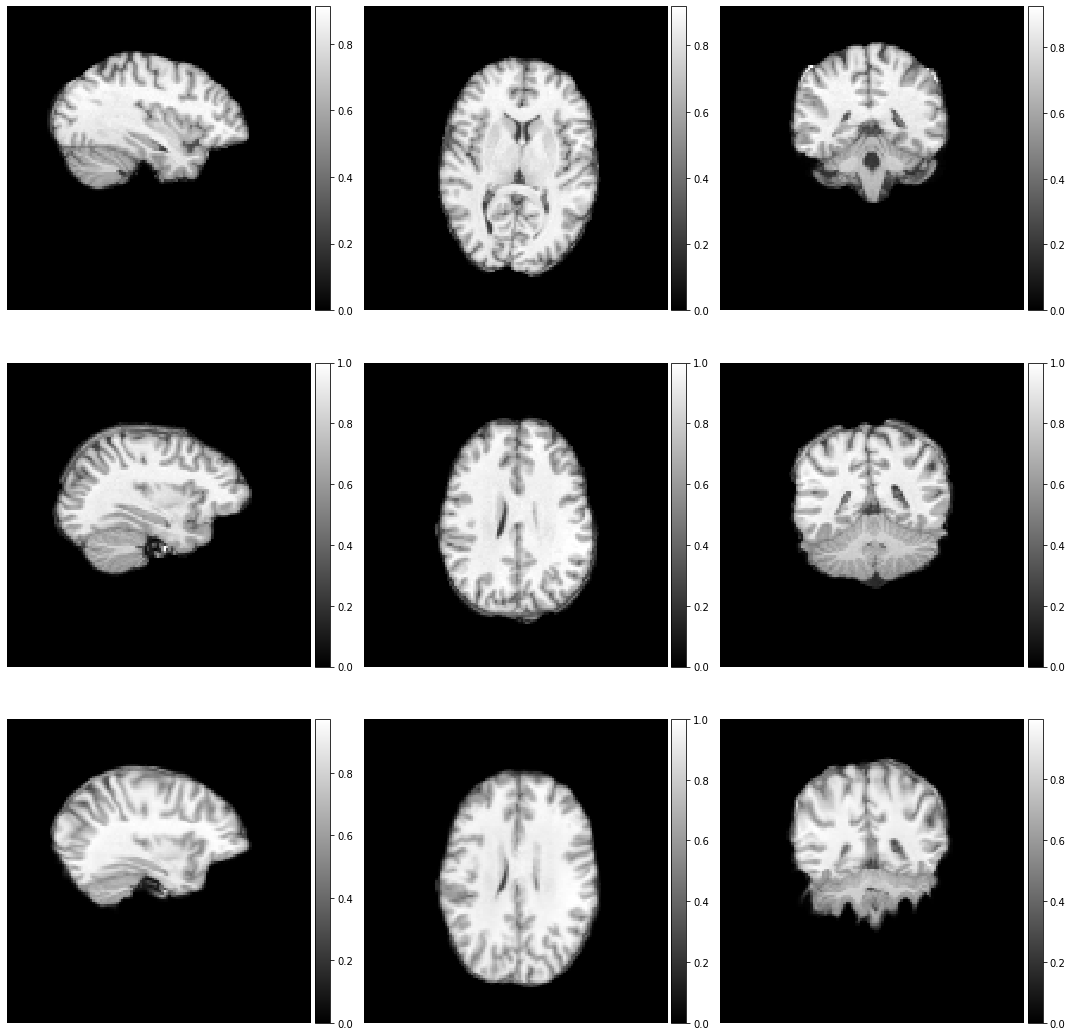

In [ ]:
mid_slices_fixed = [np.take(mynb_np1, 48, axis=d) for d in range(3)]
mid_slices_fixed[1] = np.rot90(mid_slices_fixed[1], 1)
mid_slices_fixed[2] = np.rot90(mid_slices_fixed[2], -1)

mid_slices_moving = [np.take(mynb_np2, 48, axis=d) for d in range(3)]
mid_slices_moving[1] = np.rot90(mid_slices_moving[1], 1)
mid_slices_moving[2] = np.rot90(mid_slices_moving[2], -1)

mid_slices_pred = [np.take(warped_img_np, 48, axis=d) for d in range(3)]
mid_slices_pred[1] = np.rot90(mid_slices_pred[1], 1)
mid_slices_pred[2] = np.rot90(mid_slices_pred[2], -1)
ne.plot.slices(mid_slices_fixed + mid_slices_moving + mid_slices_pred, cmaps=['gray'], do_colorbars=True, grid=[3,3]);

3 gcn layers 150 epochs

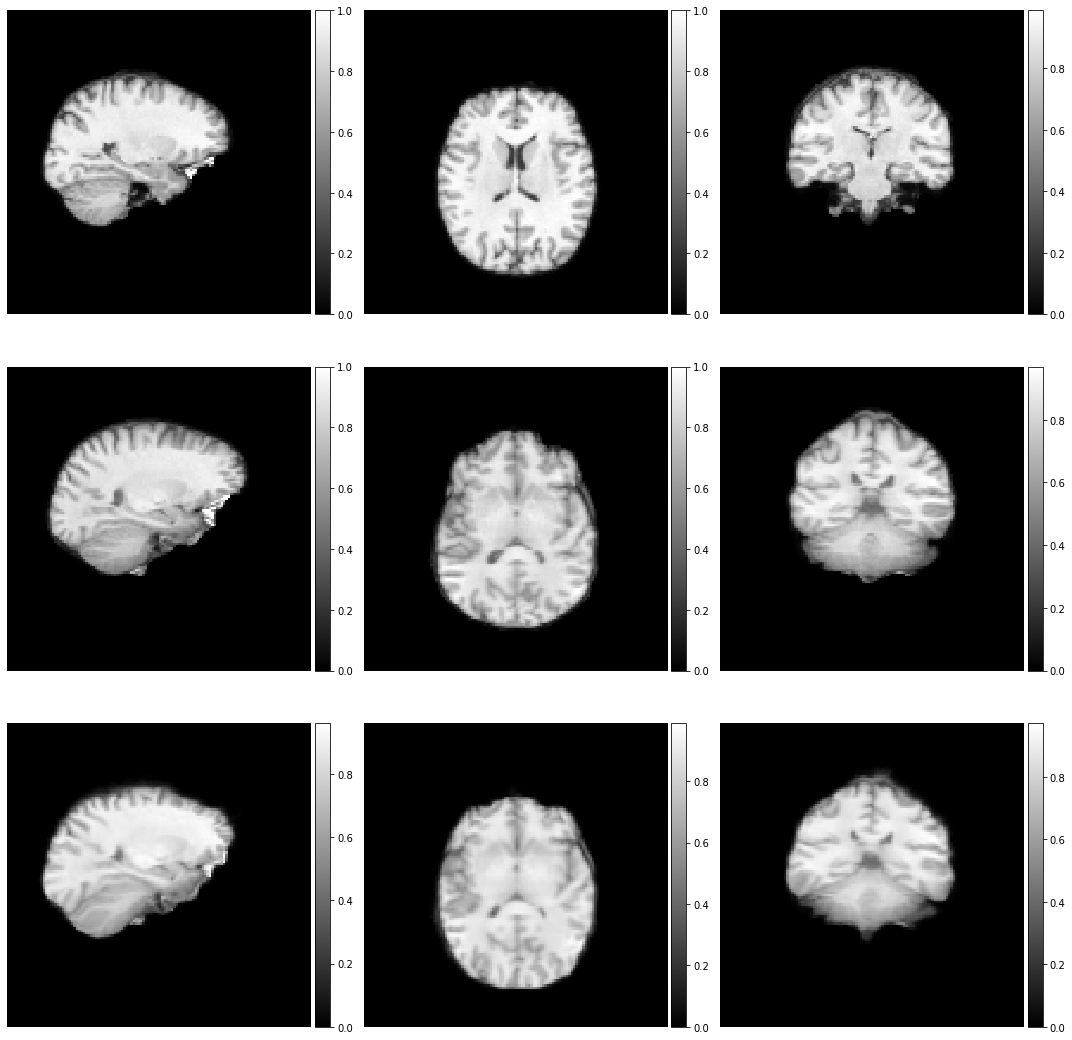

In [ ]:
mid_slices_fixed = [np.take(mynb_np1, 52, axis=d) for d in range(3)]
mid_slices_fixed[1] = np.rot90(mid_slices_fixed[1], 1)
mid_slices_fixed[2] = np.rot90(mid_slices_fixed[2], -1)

mid_slices_moving = [np.take(mynb_np2, 52, axis=d) for d in range(3)]
mid_slices_moving[1] = np.rot90(mid_slices_moving[1], 1)
mid_slices_moving[2] = np.rot90(mid_slices_moving[2], -1)

mid_slices_pred = [np.take(warped_img_np, 52, axis=d) for d in range(3)]
mid_slices_pred[1] = np.rot90(mid_slices_pred[1], 1)
mid_slices_pred[2] = np.rot90(mid_slices_pred[2], -1)
ne.plot.slices(mid_slices_fixed + mid_slices_moving + mid_slices_pred, cmaps=['gray'], do_colorbars=True, grid=[3,3]);

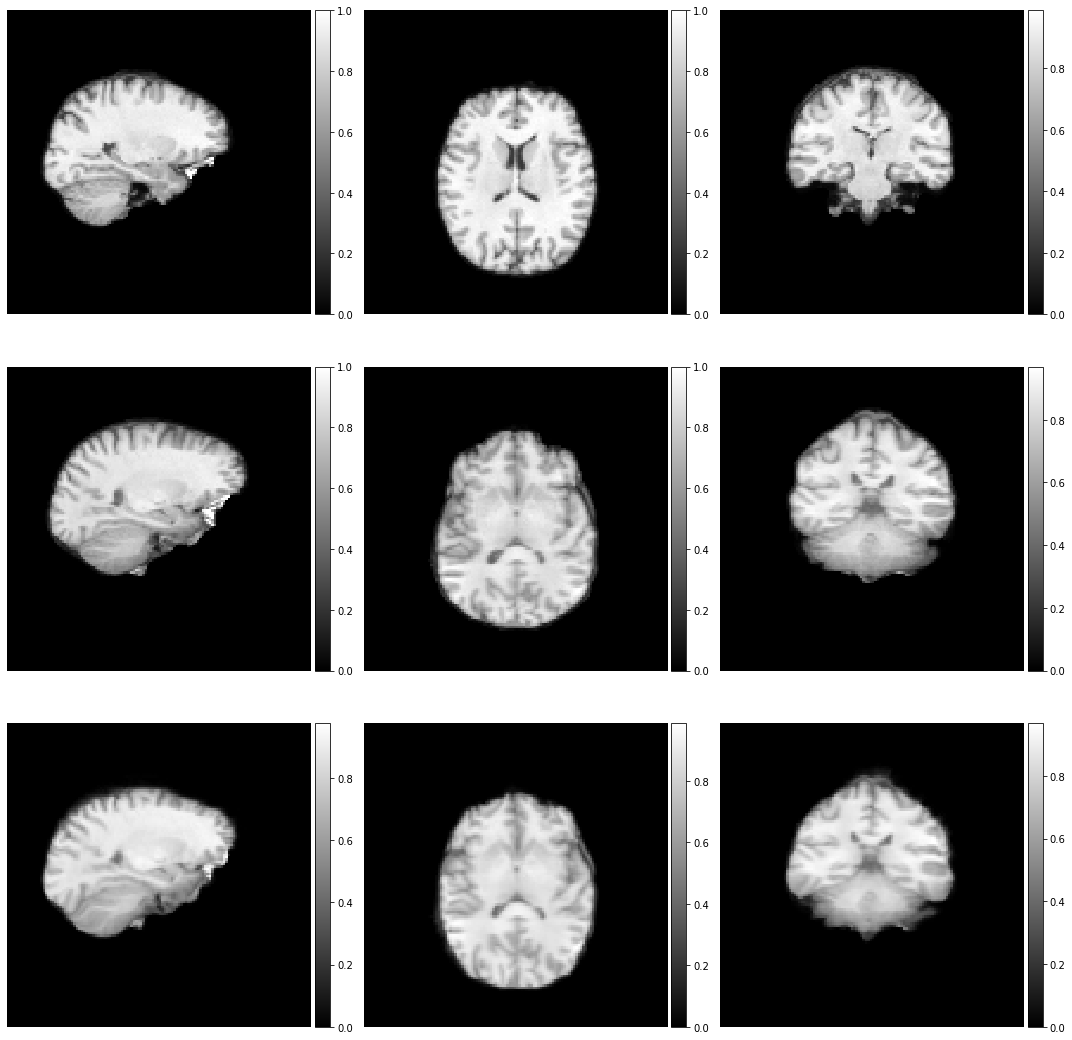

In [ ]:
mid_slices_fixed = [np.take(mynb_np1, 52, axis=d) for d in range(3)]
mid_slices_fixed[1] = np.rot90(mid_slices_fixed[1], 1)
mid_slices_fixed[2] = np.rot90(mid_slices_fixed[2], -1)

mid_slices_moving = [np.take(mynb_np2, 52, axis=d) for d in range(3)]
mid_slices_moving[1] = np.rot90(mid_slices_moving[1], 1)
mid_slices_moving[2] = np.rot90(mid_slices_moving[2], -1)

mid_slices_pred = [np.take(warped_img_np, 52, axis=d) for d in range(3)]
mid_slices_pred[1] = np.rot90(mid_slices_pred[1], 1)
mid_slices_pred[2] = np.rot90(mid_slices_pred[2], -1)
ne.plot.slices(mid_slices_fixed + mid_slices_moving + mid_slices_pred, cmaps=['gray'], do_colorbars=True, grid=[3,3]);

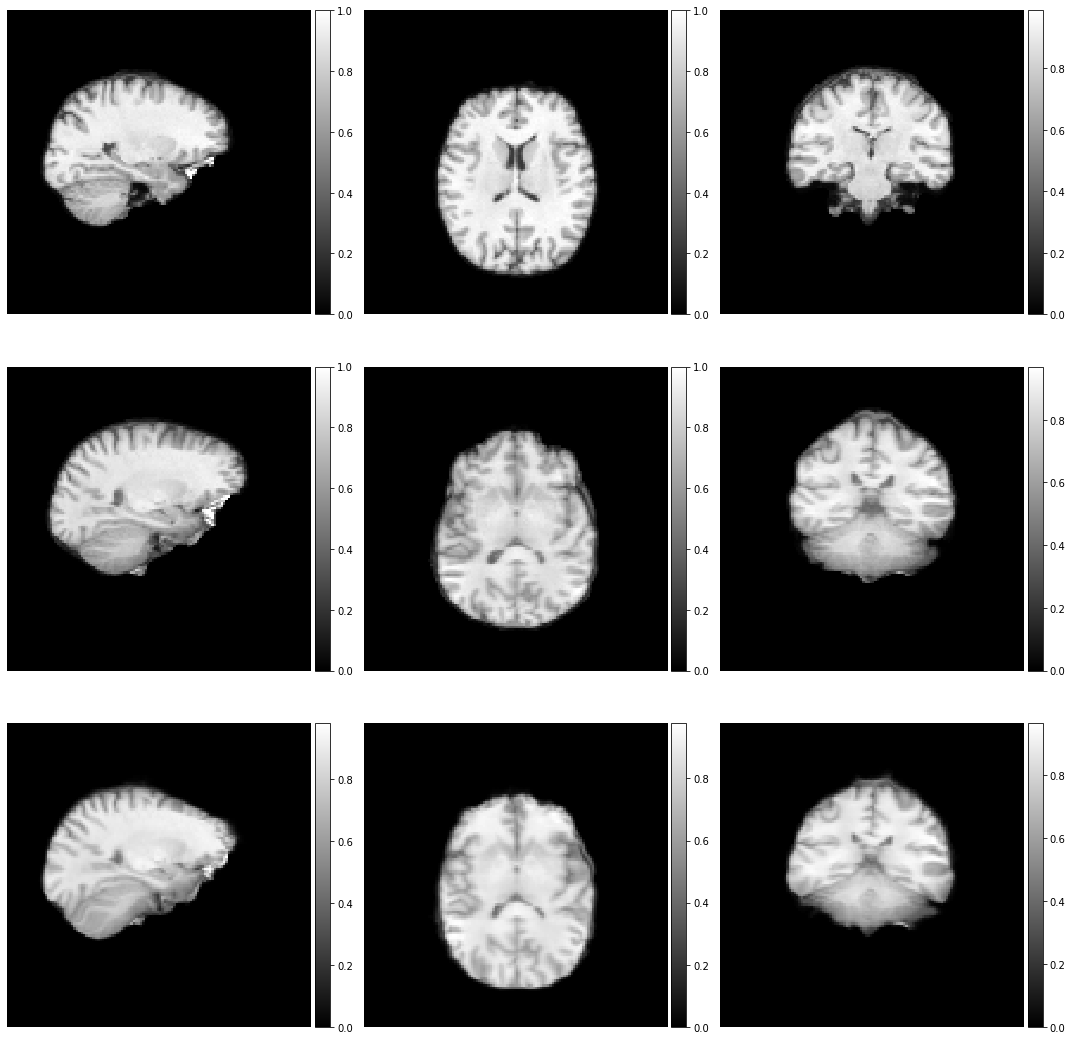

In [ ]:
mid_slices_fixed = [np.take(mynb_np1, 52, axis=d) for d in range(3)]
mid_slices_fixed[1] = np.rot90(mid_slices_fixed[1], 1)
mid_slices_fixed[2] = np.rot90(mid_slices_fixed[2], -1)

mid_slices_moving = [np.take(mynb_np2, 52, axis=d) for d in range(3)]
mid_slices_moving[1] = np.rot90(mid_slices_moving[1], 1)
mid_slices_moving[2] = np.rot90(mid_slices_moving[2], -1)

mid_slices_pred = [np.take(warped_img_np, 52, axis=d) for d in range(3)]
mid_slices_pred[1] = np.rot90(mid_slices_pred[1], 1)
mid_slices_pred[2] = np.rot90(mid_slices_pred[2], -1)
ne.plot.slices(mid_slices_fixed + mid_slices_moving + mid_slices_pred, cmaps=['gray'], do_colorbars=True, grid=[3,3]);

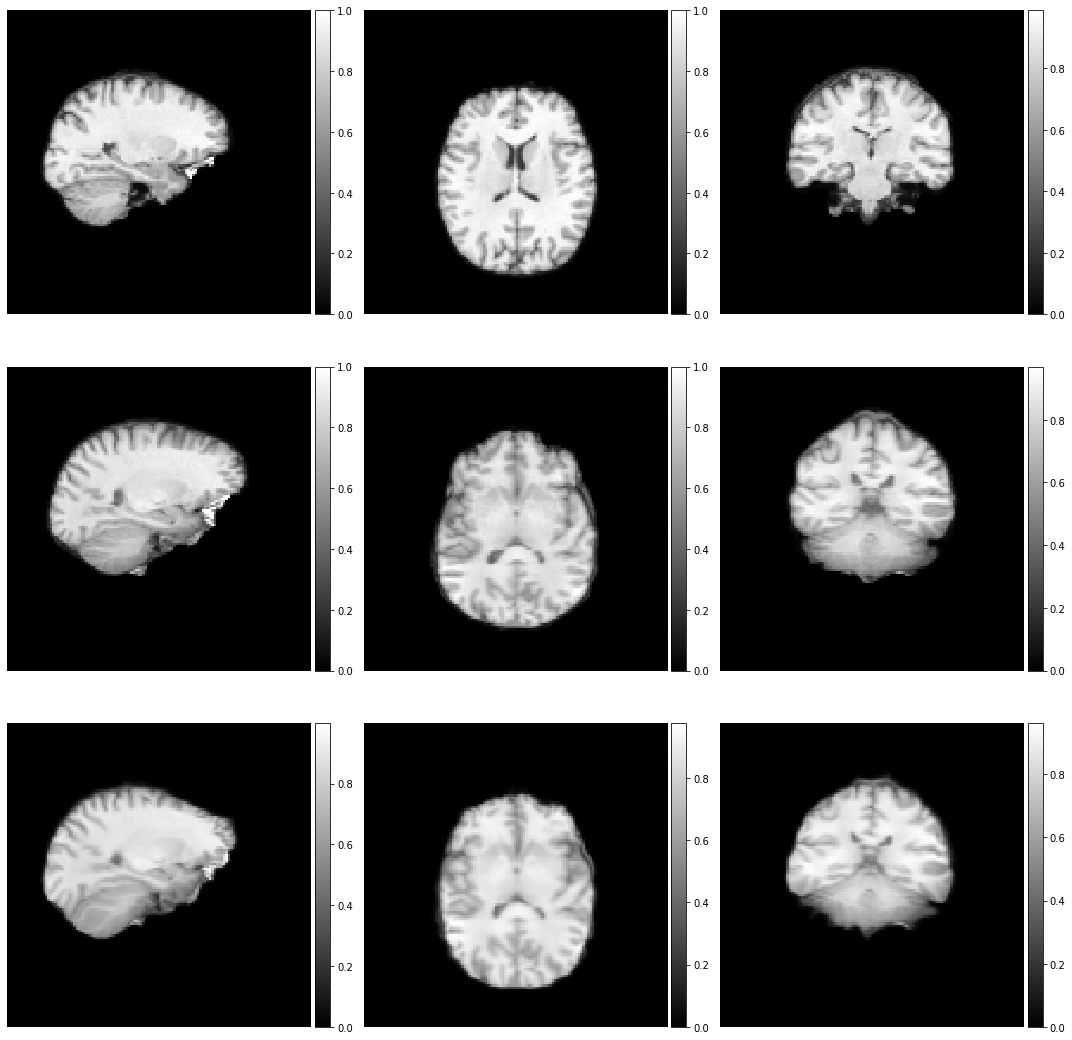

In [ ]:
mid_slices_fixed = [np.take(mynb_np1, 52, axis=d) for d in range(3)]
mid_slices_fixed[1] = np.rot90(mid_slices_fixed[1], 1)
mid_slices_fixed[2] = np.rot90(mid_slices_fixed[2], -1)

mid_slices_moving = [np.take(mynb_np2, 52, axis=d) for d in range(3)]
mid_slices_moving[1] = np.rot90(mid_slices_moving[1], 1)
mid_slices_moving[2] = np.rot90(mid_slices_moving[2], -1)

mid_slices_pred = [np.take(warped_img_np, 52, axis=d) for d in range(3)]
mid_slices_pred[1] = np.rot90(mid_slices_pred[1], 1)
mid_slices_pred[2] = np.rot90(mid_slices_pred[2], -1)
ne.plot.slices(mid_slices_fixed + mid_slices_moving + mid_slices_pred, cmaps=['gray'], do_colorbars=True, grid=[3,3]);

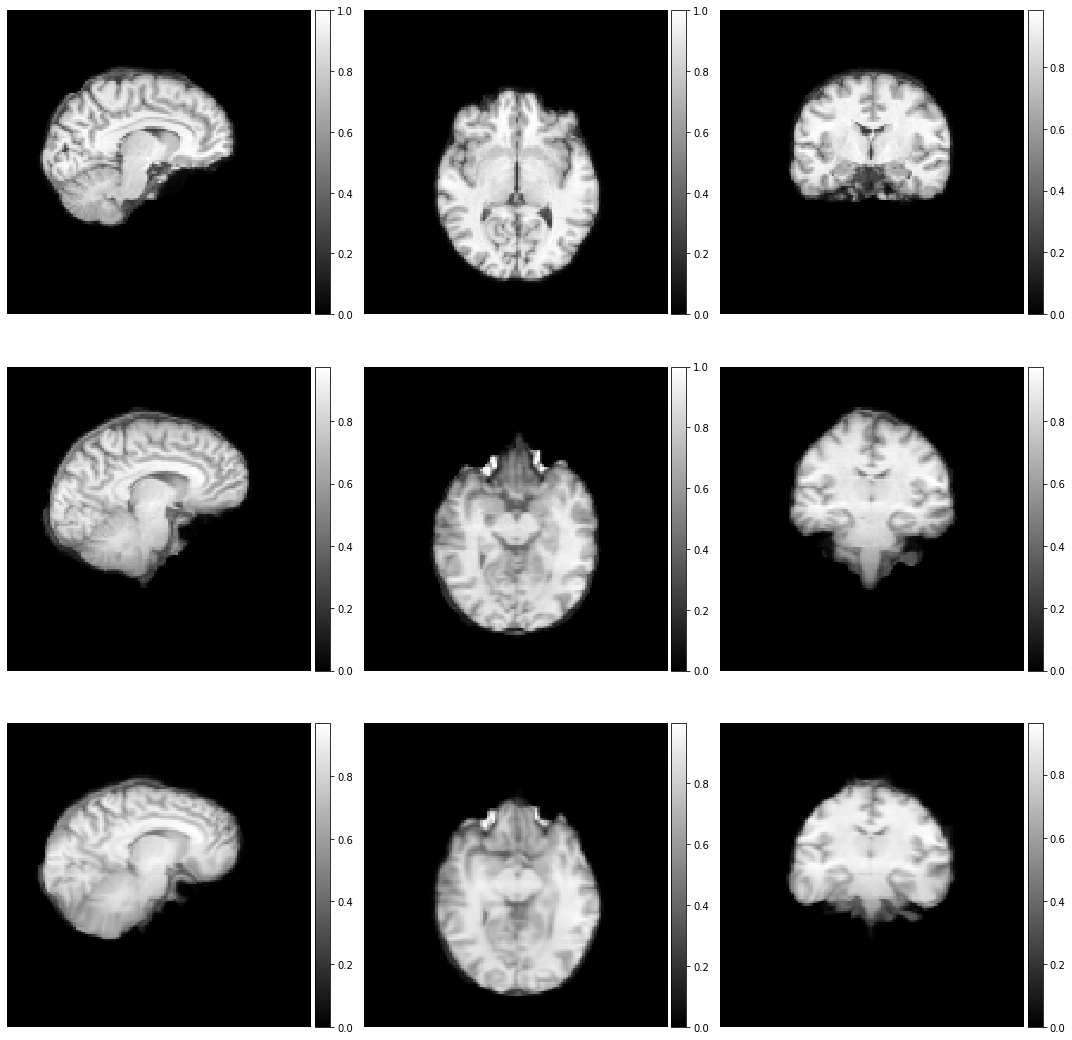

In [ ]:
mid_slices_fixed = [np.take(mynb_np1, 60, axis=d) for d in range(3)]
mid_slices_fixed[1] = np.rot90(mid_slices_fixed[1], 1)
mid_slices_fixed[2] = np.rot90(mid_slices_fixed[2], -1)

mid_slices_moving = [np.take(mynb_np2, 60, axis=d) for d in range(3)]
mid_slices_moving[1] = np.rot90(mid_slices_moving[1], 1)
mid_slices_moving[2] = np.rot90(mid_slices_moving[2], -1)

mid_slices_pred = [np.take(warped_img_np, 60, axis=d) for d in range(3)]
mid_slices_pred[1] = np.rot90(mid_slices_pred[1], 1)
mid_slices_pred[2] = np.rot90(mid_slices_pred[2], -1)
ne.plot.slices(mid_slices_fixed + mid_slices_moving + mid_slices_pred, cmaps=['gray'], do_colorbars=True, grid=[3,3]);

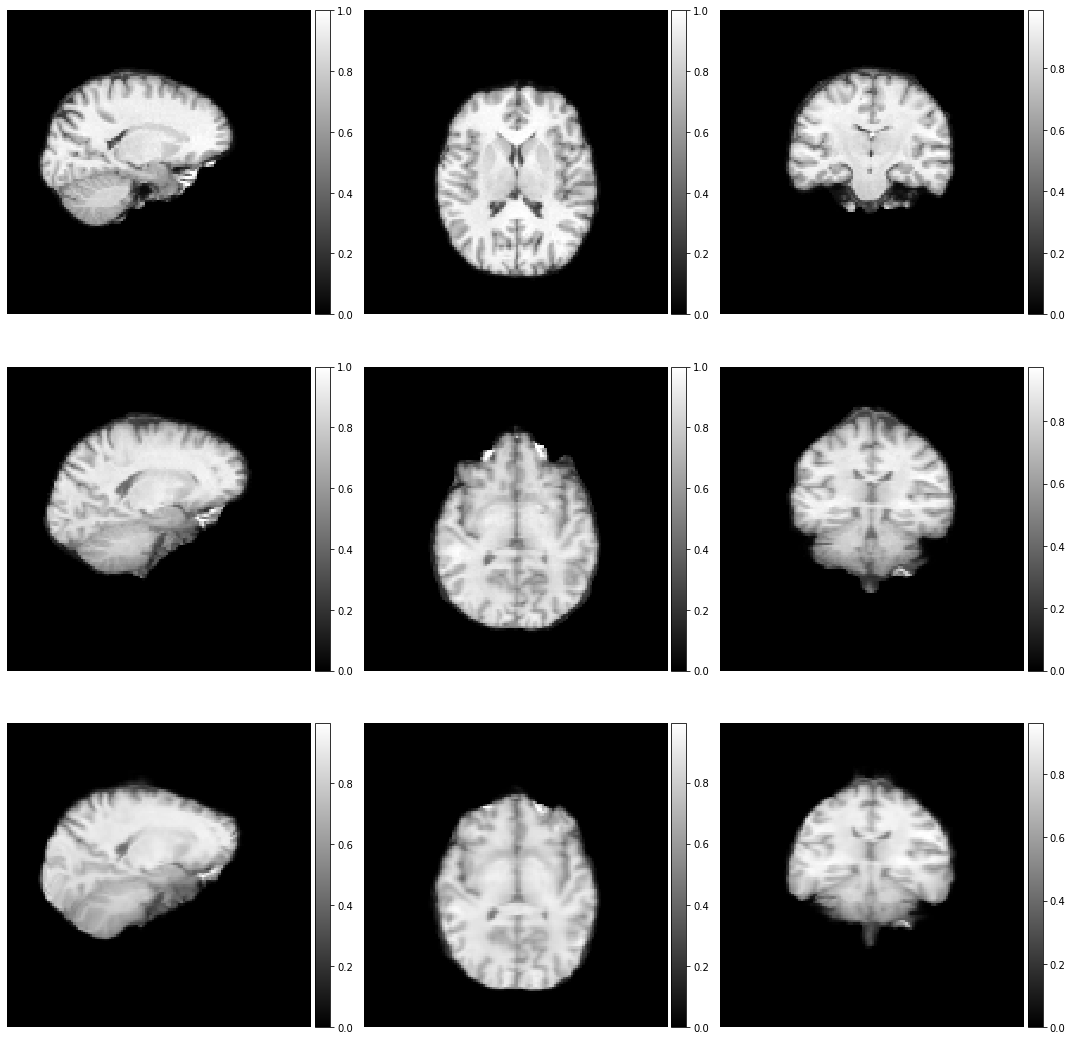

In [ ]:
mid_slices_fixed = [np.take(mynb_np1, 55, axis=d) for d in range(3)]
mid_slices_fixed[1] = np.rot90(mid_slices_fixed[1], 1)
mid_slices_fixed[2] = np.rot90(mid_slices_fixed[2], -1)

mid_slices_moving = [np.take(mynb_np2, 55, axis=d) for d in range(3)]
mid_slices_moving[1] = np.rot90(mid_slices_moving[1], 1)
mid_slices_moving[2] = np.rot90(mid_slices_moving[2], -1)

mid_slices_pred = [np.take(warped_img_np, 55, axis=d) for d in range(3)]
mid_slices_pred[1] = np.rot90(mid_slices_pred[1], 1)
mid_slices_pred[2] = np.rot90(mid_slices_pred[2], -1)
ne.plot.slices(mid_slices_fixed + mid_slices_moving + mid_slices_pred, cmaps=['gray'], do_colorbars=True, grid=[3,3]);

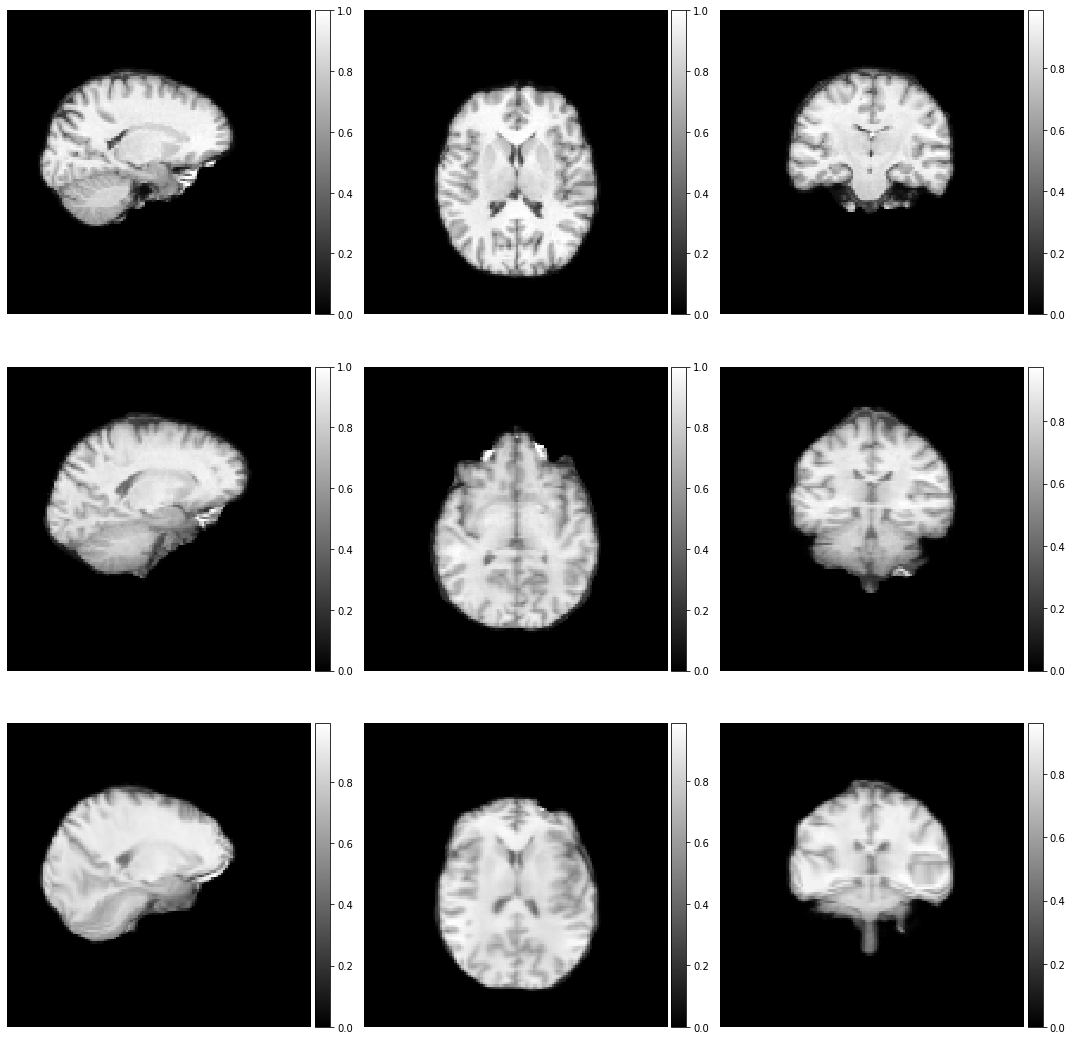

In [ ]:
mid_slices_fixed = [np.take(mynb_np1, 55, axis=d) for d in range(3)]
mid_slices_fixed[1] = np.rot90(mid_slices_fixed[1], 1)
mid_slices_fixed[2] = np.rot90(mid_slices_fixed[2], -1)

mid_slices_moving = [np.take(mynb_np2, 55, axis=d) for d in range(3)]
mid_slices_moving[1] = np.rot90(mid_slices_moving[1], 1)
mid_slices_moving[2] = np.rot90(mid_slices_moving[2], -1)

mid_slices_pred = [np.take(warped_img_np, 55, axis=d) for d in range(3)]
mid_slices_pred[1] = np.rot90(mid_slices_pred[1], 1)
mid_slices_pred[2] = np.rot90(mid_slices_pred[2], -1)
ne.plot.slices(mid_slices_fixed + mid_slices_moving + mid_slices_pred, cmaps=['gray'], do_colorbars=True, grid=[3,3]);

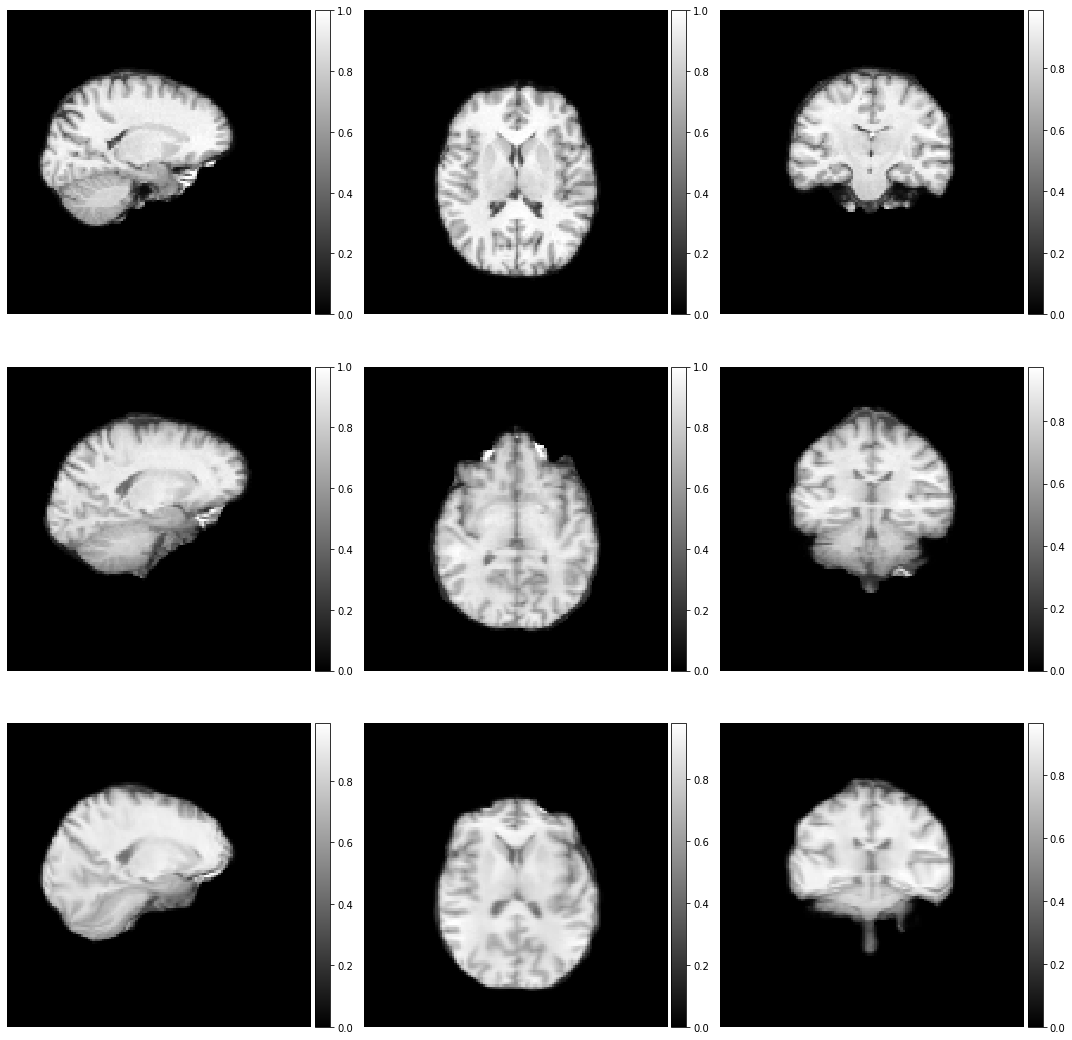

In [ ]:
mid_slices_fixed = [np.take(mynb_np1, 55, axis=d) for d in range(3)]
mid_slices_fixed[1] = np.rot90(mid_slices_fixed[1], 1)
mid_slices_fixed[2] = np.rot90(mid_slices_fixed[2], -1)

mid_slices_moving = [np.take(mynb_np2, 55, axis=d) for d in range(3)]
mid_slices_moving[1] = np.rot90(mid_slices_moving[1], 1)
mid_slices_moving[2] = np.rot90(mid_slices_moving[2], -1)

mid_slices_pred = [np.take(warped_img_np, 55, axis=d) for d in range(3)]
mid_slices_pred[1] = np.rot90(mid_slices_pred[1], 1)
mid_slices_pred[2] = np.rot90(mid_slices_pred[2], -1)
ne.plot.slices(mid_slices_fixed + mid_slices_moving + mid_slices_pred, cmaps=['gray'], do_colorbars=True, grid=[3,3]);

At 26 epochs - 4096 nodes - 16, 16, 16 feature map

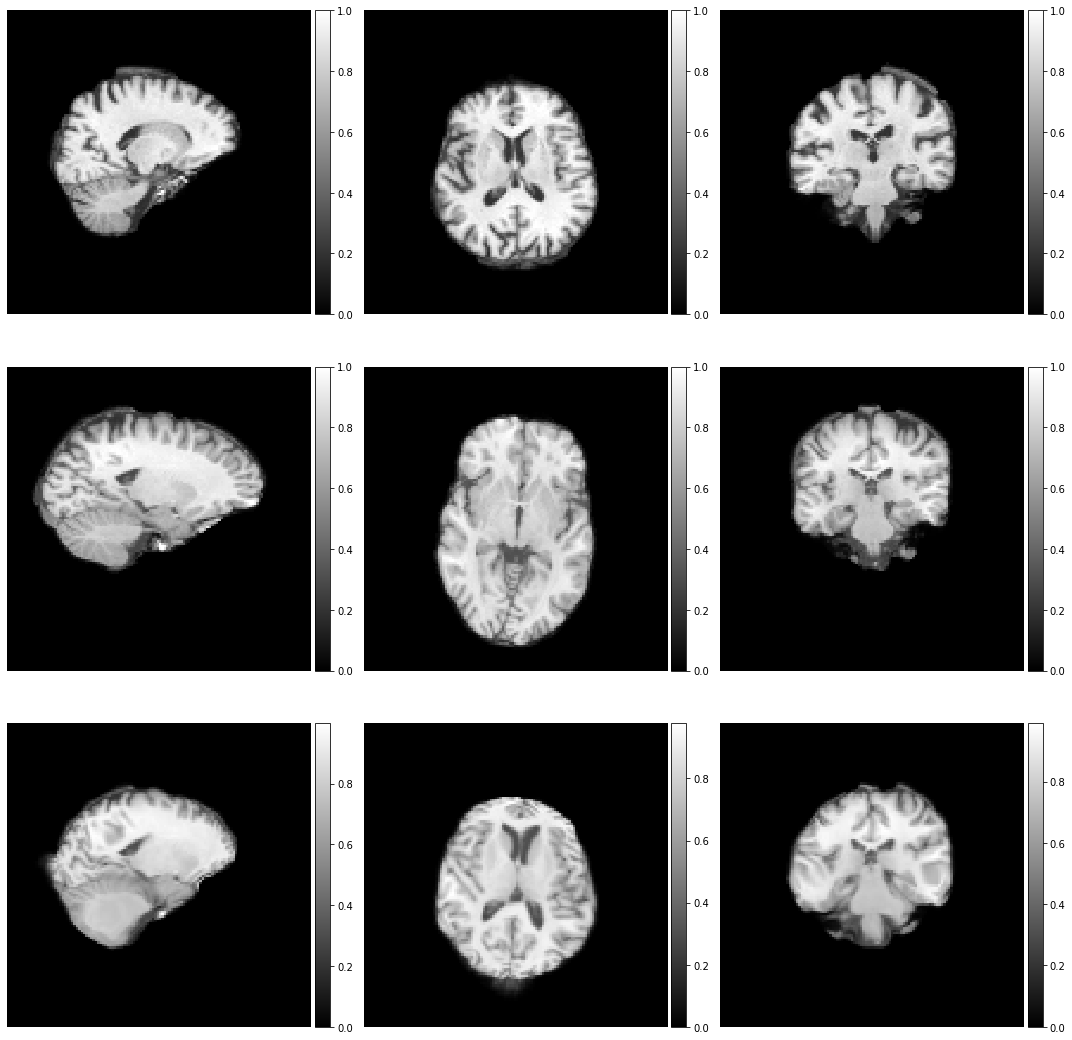

In [ ]:
mid_slices_fixed = [np.take(mynb_np1, 55, axis=d) for d in range(3)]
mid_slices_fixed[1] = np.rot90(mid_slices_fixed[1], 1)
mid_slices_fixed[2] = np.rot90(mid_slices_fixed[2], -1)

mid_slices_moving = [np.take(mynb_np2, 55, axis=d) for d in range(3)]
mid_slices_moving[1] = np.rot90(mid_slices_moving[1], 1)
mid_slices_moving[2] = np.rot90(mid_slices_moving[2], -1)

mid_slices_pred = [np.take(warped_img_np, 55, axis=d) for d in range(3)]
mid_slices_pred[1] = np.rot90(mid_slices_pred[1], 1)
mid_slices_pred[2] = np.rot90(mid_slices_pred[2], -1)
ne.plot.slices(mid_slices_fixed + mid_slices_moving + mid_slices_pred, cmaps=['gray'], do_colorbars=True, grid=[3,3]);

At 20 epochs - 4096 nodes - 16, 16, 16 feature map

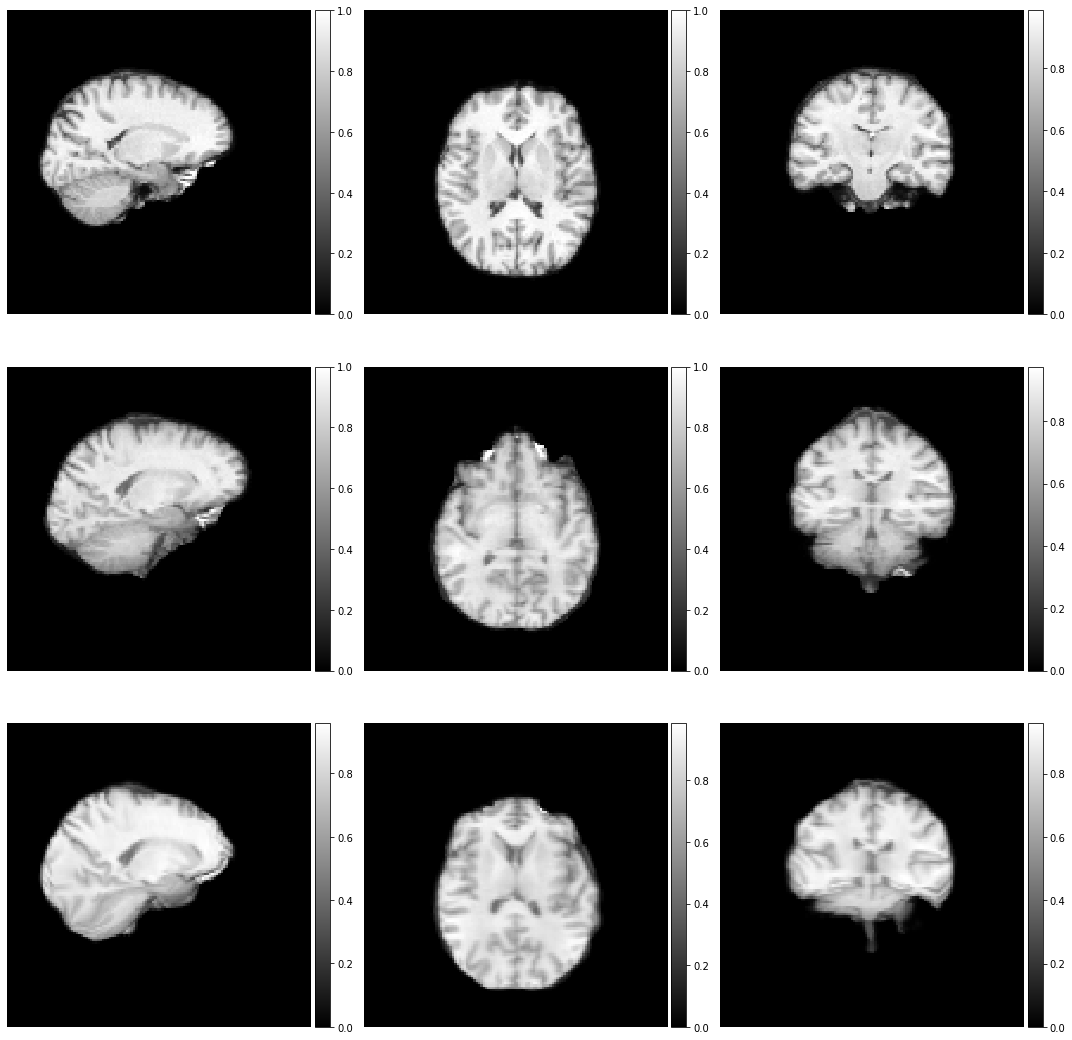

In [ ]:
mid_slices_fixed = [np.take(mynb_np1, 55, axis=d) for d in range(3)]
mid_slices_fixed[1] = np.rot90(mid_slices_fixed[1], 1)
mid_slices_fixed[2] = np.rot90(mid_slices_fixed[2], -1)

mid_slices_moving = [np.take(mynb_np2, 55, axis=d) for d in range(3)]
mid_slices_moving[1] = np.rot90(mid_slices_moving[1], 1)
mid_slices_moving[2] = np.rot90(mid_slices_moving[2], -1)

mid_slices_pred = [np.take(warped_img_np, 55, axis=d) for d in range(3)]
mid_slices_pred[1] = np.rot90(mid_slices_pred[1], 1)
mid_slices_pred[2] = np.rot90(mid_slices_pred[2], -1)
ne.plot.slices(mid_slices_fixed + mid_slices_moving + mid_slices_pred, cmaps=['gray'], do_colorbars=True, grid=[3,3]);

At 10 epochs - 4096 nodes - 16, 16, 16 feature map

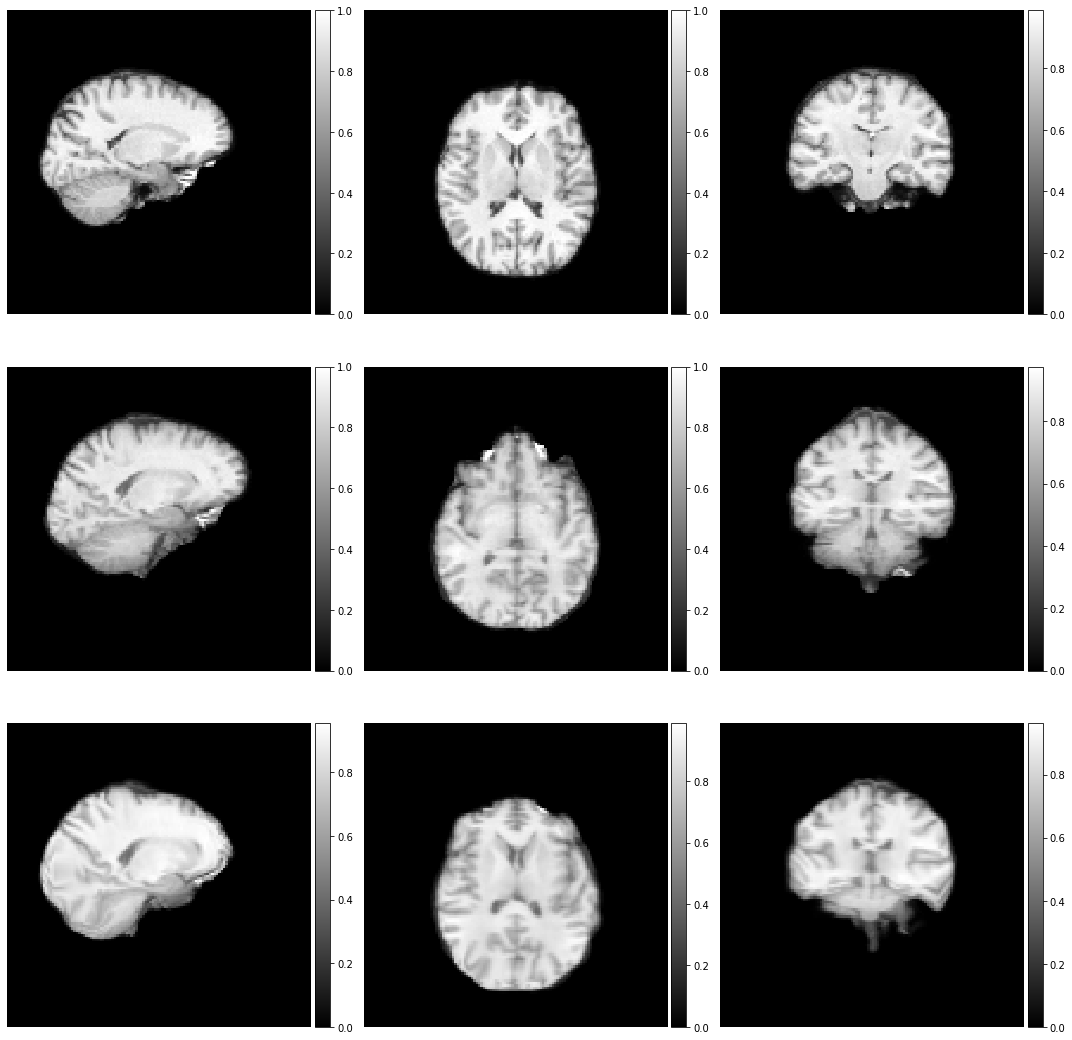

In [ ]:
mid_slices_fixed = [np.take(mynb_np1, 55, axis=d) for d in range(3)]
mid_slices_fixed[1] = np.rot90(mid_slices_fixed[1], 1)
mid_slices_fixed[2] = np.rot90(mid_slices_fixed[2], -1)

mid_slices_moving = [np.take(mynb_np2, 55, axis=d) for d in range(3)]
mid_slices_moving[1] = np.rot90(mid_slices_moving[1], 1)
mid_slices_moving[2] = np.rot90(mid_slices_moving[2], -1)

mid_slices_pred = [np.take(warped_img_np, 55, axis=d) for d in range(3)]
mid_slices_pred[1] = np.rot90(mid_slices_pred[1], 1)
mid_slices_pred[2] = np.rot90(mid_slices_pred[2], -1)
ne.plot.slices(mid_slices_fixed + mid_slices_moving + mid_slices_pred, cmaps=['gray'], do_colorbars=True, grid=[3,3]);

At 40 epochs - 512 nodes - 8,8,8 feature map


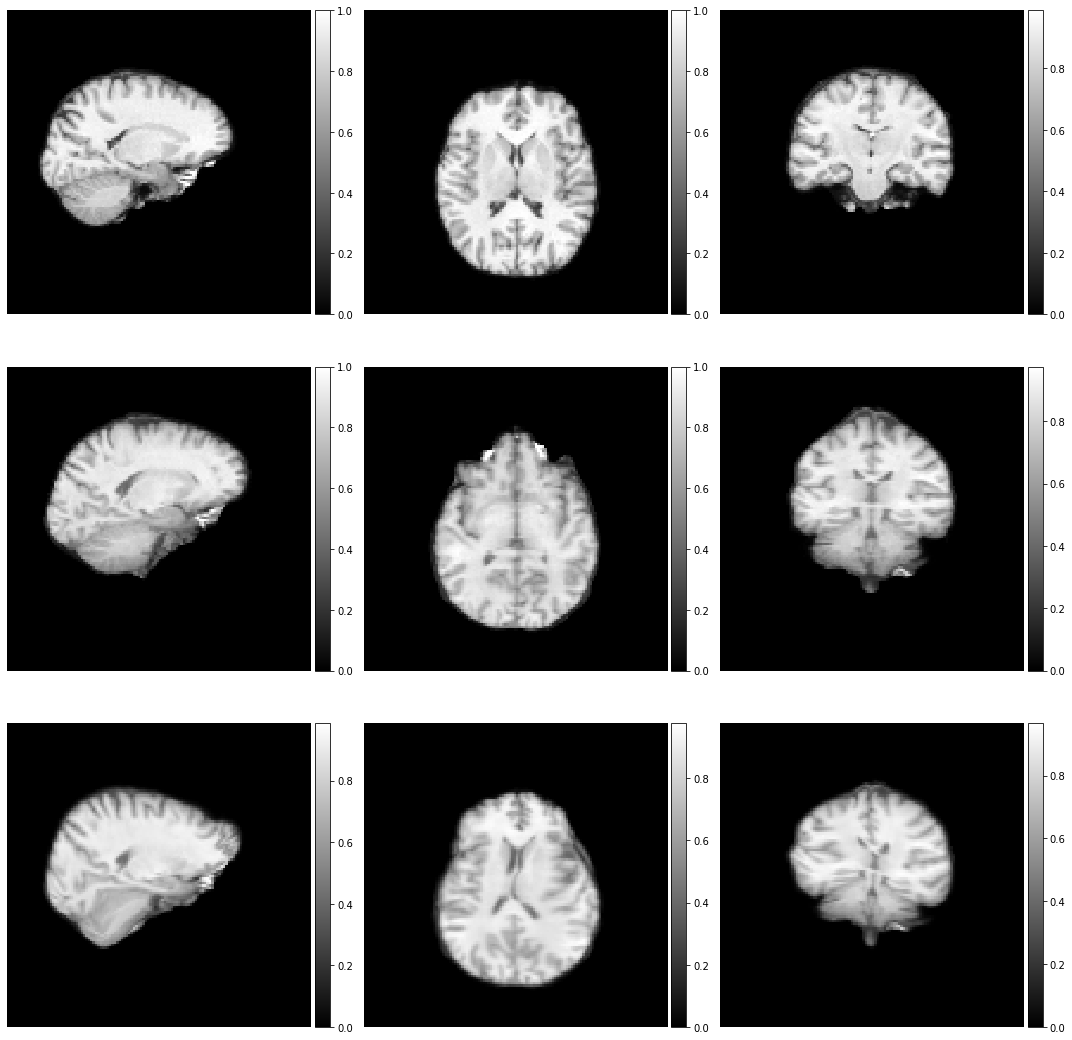

In [ ]:
mid_slices_fixed = [np.take(mynb_np1, 55, axis=d) for d in range(3)]
mid_slices_fixed[1] = np.rot90(mid_slices_fixed[1], 1)
mid_slices_fixed[2] = np.rot90(mid_slices_fixed[2], -1)

mid_slices_moving = [np.take(mynb_np2, 55, axis=d) for d in range(3)]
mid_slices_moving[1] = np.rot90(mid_slices_moving[1], 1)
mid_slices_moving[2] = np.rot90(mid_slices_moving[2], -1)

mid_slices_pred = [np.take(warped_img_np, 55, axis=d) for d in range(3)]
mid_slices_pred[1] = np.rot90(mid_slices_pred[1], 1)
mid_slices_pred[2] = np.rot90(mid_slices_pred[2], -1)
ne.plot.slices(mid_slices_fixed + mid_slices_moving + mid_slices_pred, cmaps=['gray'], do_colorbars=True, grid=[3,3]);

At 70 epochs - 512 nodes - 8,8,8 feature map

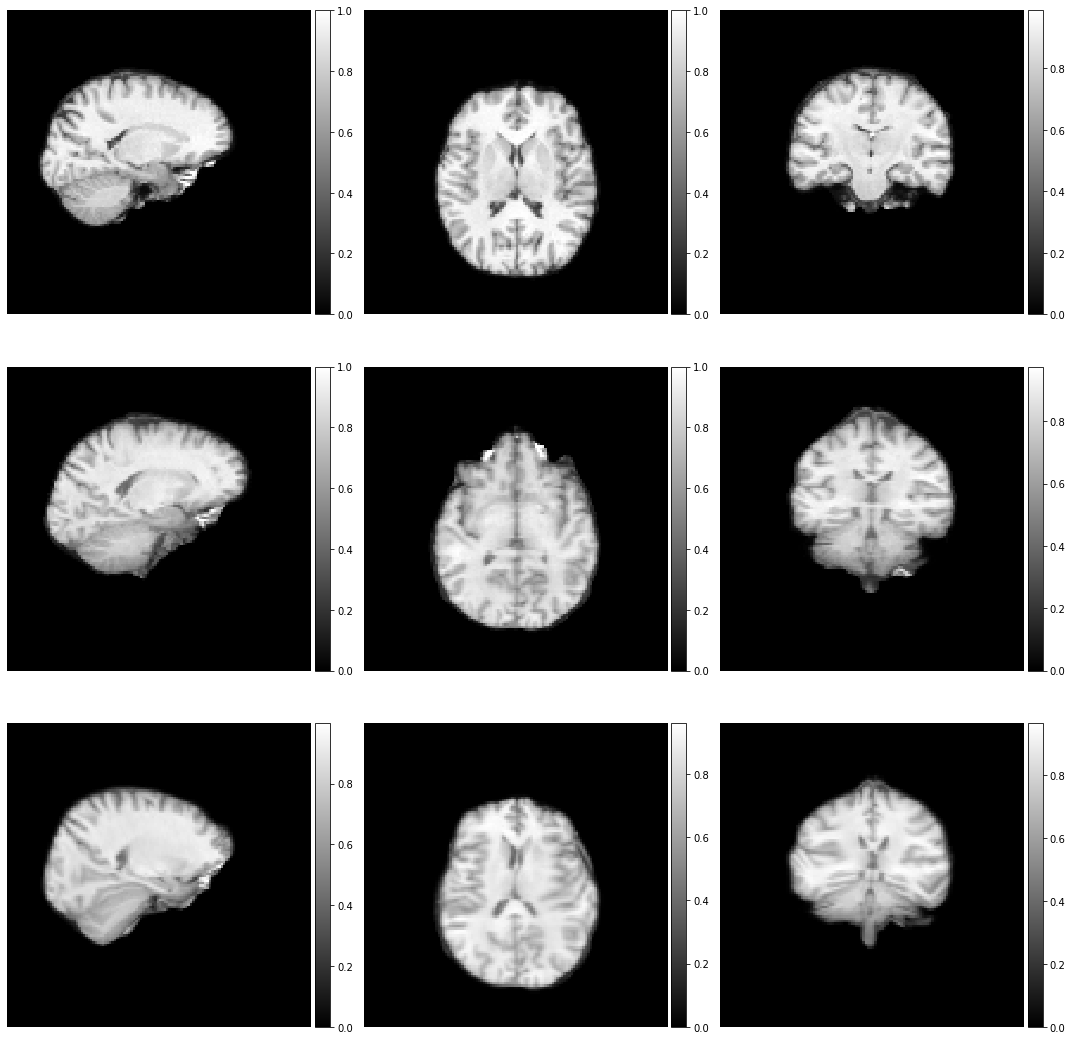

In [ ]:
mid_slices_fixed = [np.take(mynb_np1, 55, axis=d) for d in range(3)]
mid_slices_fixed[1] = np.rot90(mid_slices_fixed[1], 1)
mid_slices_fixed[2] = np.rot90(mid_slices_fixed[2], -1)

mid_slices_moving = [np.take(mynb_np2, 55, axis=d) for d in range(3)]
mid_slices_moving[1] = np.rot90(mid_slices_moving[1], 1)
mid_slices_moving[2] = np.rot90(mid_slices_moving[2], -1)

mid_slices_pred = [np.take(warped_img_np, 55, axis=d) for d in range(3)]
mid_slices_pred[1] = np.rot90(mid_slices_pred[1], 1)
mid_slices_pred[2] = np.rot90(mid_slices_pred[2], -1)
ne.plot.slices(mid_slices_fixed + mid_slices_moving + mid_slices_pred, cmaps=['gray'], do_colorbars=True, grid=[3,3]);

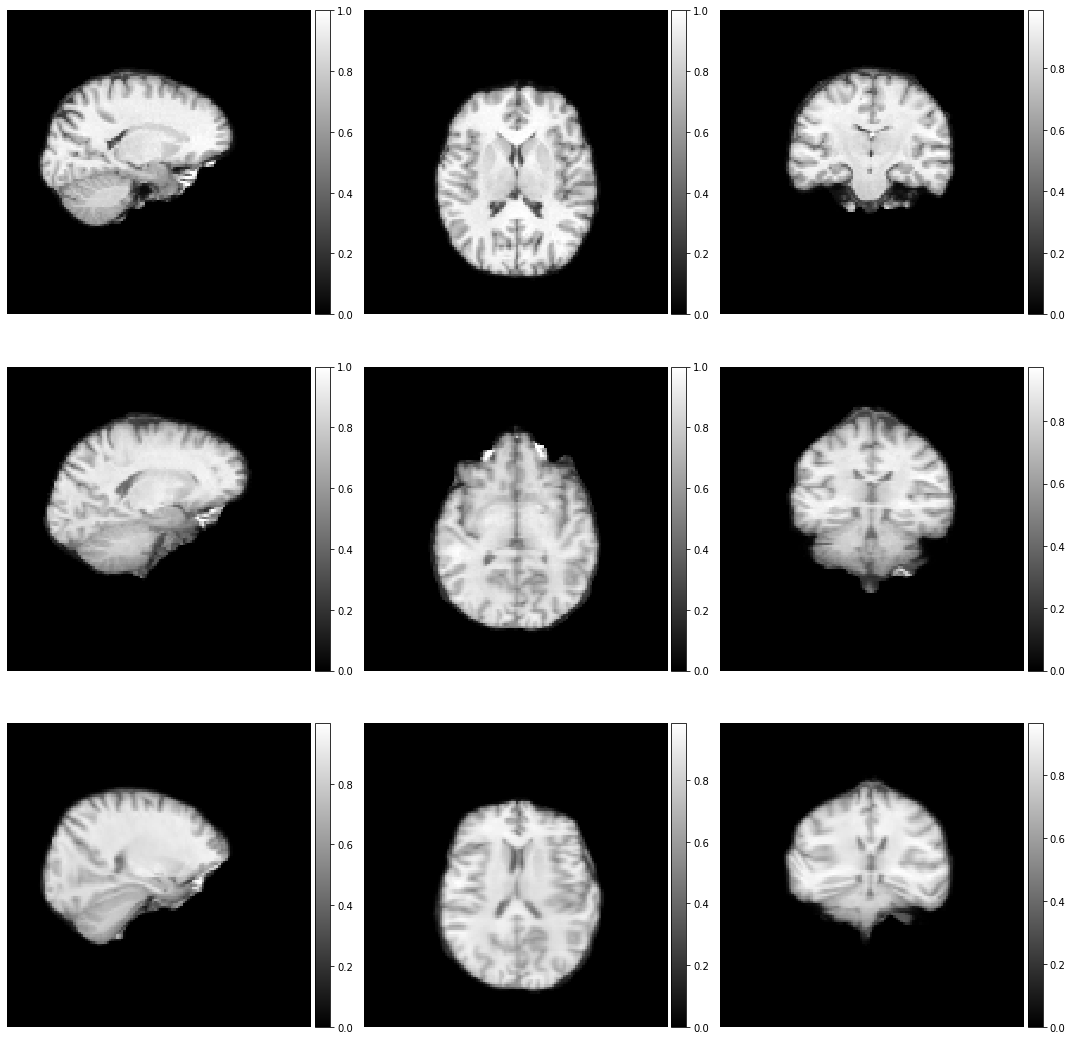

In [ ]:
mid_slices_fixed = [np.take(mynb_np1, 55, axis=d) for d in range(3)]
mid_slices_fixed[1] = np.rot90(mid_slices_fixed[1], 1)
mid_slices_fixed[2] = np.rot90(mid_slices_fixed[2], -1)

mid_slices_moving = [np.take(mynb_np2, 55, axis=d) for d in range(3)]
mid_slices_moving[1] = np.rot90(mid_slices_moving[1], 1)
mid_slices_moving[2] = np.rot90(mid_slices_moving[2], -1)

mid_slices_pred = [np.take(warped_img_np, 55, axis=d) for d in range(3)]
mid_slices_pred[1] = np.rot90(mid_slices_pred[1], 1)
mid_slices_pred[2] = np.rot90(mid_slices_pred[2], -1)
ne.plot.slices(mid_slices_fixed + mid_slices_moving + mid_slices_pred, cmaps=['gray'], do_colorbars=True, grid=[3,3]);

# Graph difference network - Two separate netqworks for fixed and moving, and leakyrelu, larger batch size, with/without upconv

In [ ]:
del feature_extractor_fixed_training, feature_extractor_moving_training, scg_fixed_training, scg_moving_training
del graph_layers1_fixed_training, graph_layers1_moving_training, graph_layers2_fixed_training, graph_layers2_moving_training
del graph_layers3_fixed_training, graph_layers3_moving_training
torch.cuda.empty_cache()

In [ ]:
feature_extractor_fixed_training = Feature_Extractor2(1,8).to("cuda")
feature_extractor_moving_training = Feature_Extractor2(1,8).to("cuda")

scg_fixed_training = SCG_block(in_ch=32, hidden_ch=3, node_size=(16, 16, 16)).to("cuda")
scg_moving_training = SCG_block(in_ch=32, hidden_ch=3, node_size=(16, 16, 16)).to("cuda")

#upsampler_fixed_training = Upsampler_net(8).to("cuda")

graph_layers1_fixed_training = GCN_Layer(32, 16, bnorm=True, activation=nn.ReLU(True), dropout=0.1).to("cuda")
graph_layers1_moving_training = GCN_Layer(32, 16, bnorm=True, activation=nn.ReLU(True), dropout=0.1).to("cuda")

graph_layers2_fixed_training = GCN_Layer(16, 8, bnorm=True, activation=nn.ReLU(True), dropout=0.1).to("cuda")
graph_layers2_moving_training = GCN_Layer(16, 8, bnorm=True, activation=nn.ReLU(True), dropout=0.1).to("cuda")

graph_layers3_fixed_training = GCN_Layer(8, 3, bnorm=False, activation=None).to("cuda")
graph_layers3_moving_training = GCN_Layer(8, 3, bnorm=False, activation=None).to("cuda")

stn_deformable = SpatialTransformer(size=(128, 128, 128), is_affine=False).to("cuda")

weight_xavier_init(scg_fixed_training, graph_layers1_fixed_training, graph_layers2_fixed_training, graph_layers3_fixed_training,
                   graph_layers1_moving_training, graph_layers2_moving_training, graph_layers3_moving_training)

for param in stn_deformable.parameters():
  param.requires_grad = False
  param.volatile=True


In [ ]:
checkpoint = torch.load('/content/drive/My Drive/Image_Registration_Project/dual_scgnet/scgnet_dualarm_16_220.pth')

feature_extractor_fixed_training.load_state_dict(checkpoint['feature_extractor_fixed_training'])

scg_fixed_training.load_state_dict(checkpoint['scg_fixed_training'])

graph_layers1_fixed_training.load_state_dict(checkpoint['graph_layers1_fixed_training'])

graph_layers2_fixed_training.load_state_dict(checkpoint['graph_layers2_fixed_training'])

graph_layers3_fixed_training.load_state_dict(checkpoint['graph_layers3_fixed_training'])

feature_extractor_moving_training.load_state_dict(checkpoint['feature_extractor_moving_training'])

scg_moving_training.load_state_dict(checkpoint['scg_moving_training'])

graph_layers1_moving_training.load_state_dict(checkpoint['graph_layers1_moving_training'])

graph_layers2_moving_training.load_state_dict(checkpoint['graph_layers2_moving_training'])

graph_layers3_moving_training.load_state_dict(checkpoint['graph_layers3_moving_training'])


<All keys matched successfully>

In [ ]:
similarity_loss = NormalizedCrossCorrelation().to("cuda")
smoothness_loss = Smoothnessloss().to("cuda")
lr=1e-4

In [ ]:
optimizer = torch.optim.Adam( list( feature_extractor_fixed_training.parameters()) + list( feature_extractor_moving_training.parameters()) + 
                             list( scg_fixed_training.parameters() ) + list( scg_moving_training.parameters() ) + 
                             list( graph_layers1_fixed_training.parameters()) + list( graph_layers1_moving_training.parameters()) +
                             list( graph_layers2_fixed_training.parameters()) + list( graph_layers2_moving_training.parameters()) + 
                             list( graph_layers3_fixed_training.parameters()) + list( graph_layers3_moving_training.parameters()), lr=lr ) 
model_dir = '/content/drive/My Drive/Image_Registration_Project/dual_scgnet'

if not os.path.isdir(model_dir):
  os.mkdir(model_dir)


In [ ]:
def dualarm_fullmodel_one_epoch_run(epoch=1):
  example_number = 0
  for X,Y in training_generator:

    X = X.float().to("cuda")
    Y = Y.float().to("cuda")

    x_size = X.size()
    y_size = Y.size()

    feature_extractor_fixed_op = feature_extractor_fixed_training(X)
    feature_extractor_moving_op = feature_extractor_moving_training(Y)

    A_fixed, gx_fixed, scg_loss_fixed, z_hat_fixed = scg_fixed_training(feature_extractor_fixed_op)
    A_moving, gx_moving, scg_loss_moving, z_hat_moving = scg_moving_training(feature_extractor_moving_op)
    
    B_fixed, C_fixed, H_fixed, W_fixed, D_fixed = feature_extractor_fixed_op.size()
    B_moving, C_moving, H_moving, W_moving, D_moving = feature_extractor_moving_op.size()

    gop_layers1_fixed, A_layers1_fixed = graph_layers1_fixed_training((gx_fixed.reshape(B_fixed, -1, C_fixed), A_fixed))
    gop_layers1_moving, A_layers1_moving = graph_layers1_moving_training((gx_moving.reshape(B_moving, -1, C_moving), A_moving))

    
    gop_layers2_fixed, A_layers2_fixed = graph_layers2_fixed_training((gop_layers1_fixed, A_layers1_fixed))
    gop_layers2_moving, A_layers2_moving = graph_layers2_moving_training((gop_layers1_moving, A_layers1_moving))

    gop_layers3_fixed, A_layers3_fixed = graph_layers3_fixed_training((gop_layers2_fixed, A_layers2_fixed))
    gop_layers3_moving, A_layers3_moving = graph_layers3_moving_training((gop_layers2_moving, A_layers2_moving))


    gop_layers3_fixed = gop_layers3_fixed + z_hat_fixed
    gop_layers3_moving = gop_layers3_moving + z_hat_moving

    #Find difference between fixed and mving graphs
    graph_difference = torch.subtract(gop_layers3_fixed, gop_layers3_moving)

    #From here onwards it would be normal only onestream would be present as we have the difference
    gx_difference = graph_difference.reshape(B_fixed, 3, 16, 16, 16)

    gx_difference = F.interpolate(gx_difference, (H_fixed, W_fixed, D_fixed), mode='trilinear', align_corners=False)

    # Adding information from feature extractor directly to latent space info, this could provide a path for gradients to move faster
    # gx = upsampler_training(gx, feature_extractor_op_p)

    dvf = F.interpolate(gx_difference, x_size[2:], mode='trilinear', align_corners=False)

    fully_warped_image =  stn_deformable(Y, dvf)

    cc_loss = similarity_loss(X, fully_warped_image)
    sm_loss = smoothness_loss(dvf)

    total_loss = -10.0 * cc_loss + 10.0 * scg_loss_fixed + 10.0 * scg_loss_moving + 0.005 * sm_loss

    optimizer.zero_grad()          
    total_loss.backward() 
    optimizer.step()


    #print("============= =============== ===========")

    np.save(os.path.join(model_dir, "scgnet_dualarm_16_plot_loss_9.npy"), np.array( [scg_loss_fixed.detach().to("cpu").numpy(), scg_loss_moving.detach().to("cpu").numpy(), cc_loss.detach().to("cpu").numpy(), 
                                                                                     total_loss.detach().to("cpu").numpy(),  sm_loss.detach().to("cpu").numpy(), epoch, example_number] ))

    del X, Y, gx_difference, dvf, fully_warped_image
    del feature_extractor_fixed_op,  A_fixed, gx_fixed, z_hat_fixed
    del feature_extractor_moving_op, A_moving, gx_moving, z_hat_moving
    del B_fixed, C_fixed, H_fixed, W_fixed, D_fixed
    del B_moving, C_moving, H_moving, W_moving, D_moving
    del gop_layers1_fixed, A_layers1_fixed,  gop_layers2_fixed, A_layers2_fixed, gop_layers3_fixed, A_layers3_fixed
    del gop_layers1_moving, A_layers1_moving, gop_layers2_moving, A_layers2_moving, gop_layers3_moving, A_layers3_moving
     
    torch.cuda.empty_cache() 
   
    example_number = example_number + 1
    


  if (epoch%2 == 0):
    modelname = model_dir + '/' + "scgnet_dualarm_16_" + str(epoch + 242) + '.pth'
    torch.save({"feature_extractor_fixed_training": feature_extractor_fixed_training.state_dict(), "feature_extractor_moving_training": feature_extractor_moving_training.state_dict(),
                "scg_fixed_training": scg_fixed_training.state_dict(), "scg_moving_training": scg_moving_training.state_dict(), 
                "graph_layers1_fixed_training": graph_layers1_fixed_training.state_dict(), "graph_layers2_fixed_training": graph_layers2_fixed_training.state_dict(), 
                "graph_layers3_fixed_training": graph_layers3_fixed_training.state_dict(), "graph_layers1_moving_training": graph_layers1_moving_training.state_dict(), 
                "graph_layers2_moving_training": graph_layers2_moving_training.state_dict(), "graph_layers3_moving_training": graph_layers3_moving_training.state_dict()}, modelname)
    print("epoch: {}".format(epoch))
    print("Losses: {}, {} {}, {} and {}".format(cc_loss * -10.0, scg_loss_fixed * 10.0, scg_loss_moving * 10.0, 0.005 * sm_loss, total_loss))
    print("Saving model checkpoints")
    print("======= =============== ===========")
    print()

In [ ]:
epochs = 41
for e in range(epochs):
  dualarm_fullmodel_one_epoch_run(epoch=e)

epoch: 0
Losses: -8.990867614746094, 0.0007445896044373512 0.0016421877080574632, 0.08472547680139542 and -8.903755187988281
Saving model checkpoints
======= =============== ===========

epoch: 2
Losses: -8.592826843261719, 0.0007366533391177654 0.0016768021741881967, 0.08291928470134735 and -8.507494926452637
Saving model checkpoints
======= =============== ===========



KeyboardInterrupt: ignored

# Inference and Visualization

In [ ]:
del feature_extractor_fixed_inference, feature_extractor_moving_inference, scg_fixed_inference, scg_moving_inference
del graph_layers1_fixed_inference, graph_layers1_moving_inference, graph_layers2_fixed_inference, graph_layers2_moving_inference
del graph_layers3_moving_inference, graph_layers3_fixed_inference
torch.cuda.empty_cache()

In [ ]:
feature_extractor_fixed_inference = Feature_Extractor2(1,8).to("cuda")
feature_extractor_moving_inference = Feature_Extractor2(1,8).to("cuda")

scg_fixed_inference = SCG_block(in_ch=32, hidden_ch=3, node_size=(16, 16, 16)).to("cuda")
scg_moving_inference = SCG_block(in_ch=32, hidden_ch=3, node_size=(16, 16, 16)).to("cuda")

#upsampler_fixed_inference = Upsampler_net(8).to("cuda")

graph_layers1_fixed_inference = GCN_Layer(32, 16, bnorm=True, activation=nn.ReLU(True), dropout=0.1).to("cuda")
graph_layers1_moving_inference = GCN_Layer(32, 16, bnorm=True, activation=nn.ReLU(True), dropout=0.1).to("cuda")

graph_layers2_fixed_inference = GCN_Layer(16, 8, bnorm=True, activation=nn.ReLU(True), dropout=0.1).to("cuda")
graph_layers2_moving_inference = GCN_Layer(16, 8, bnorm=True, activation=nn.ReLU(True), dropout=0.1).to("cuda")

graph_layers3_fixed_inference = GCN_Layer(8, 3, bnorm=False, activation=None).to("cuda")
graph_layers3_moving_inference = GCN_Layer(8, 3, bnorm=False, activation=None).to("cuda")

stn_deformable = SpatialTransformer(size=(128, 128, 128), is_affine=False).to("cuda")

weight_xavier_init(scg_fixed_inference, graph_layers1_fixed_inference, graph_layers2_fixed_inference, graph_layers3_fixed_inference,
                   graph_layers1_moving_inference, graph_layers2_moving_inference, graph_layers3_moving_inference)

for param in stn_deformable.parameters():
  param.requires_grad = False
  param.volatile=True


In [ ]:
checkpoint = torch.load('/content/drive/My Drive/Image_Registration_Project/dual_scgnet/scgnet_dualarm_16_240.pth')


feature_extractor_fixed_inference.load_state_dict(checkpoint['feature_extractor_fixed_training'])


scg_fixed_inference.load_state_dict(checkpoint['scg_fixed_training'])


graph_layers1_fixed_inference.load_state_dict(checkpoint['graph_layers1_fixed_training'])


graph_layers2_fixed_inference.load_state_dict(checkpoint['graph_layers2_fixed_training'])


graph_layers3_fixed_inference.load_state_dict(checkpoint['graph_layers3_fixed_training'])


feature_extractor_fixed_inference.eval()
##upsampler_fixed_inference.eval()
scg_fixed_inference.eval()
graph_layers1_fixed_inference.eval()
graph_layers2_fixed_inference.eval()
graph_layers3_fixed_inference.eval()

feature_extractor_moving_inference.load_state_dict(checkpoint['feature_extractor_moving_training'])


scg_moving_inference.load_state_dict(checkpoint['scg_moving_training'])


graph_layers1_moving_inference.load_state_dict(checkpoint['graph_layers1_moving_training'])


graph_layers2_moving_inference.load_state_dict(checkpoint['graph_layers2_moving_training'])


graph_layers3_moving_inference.load_state_dict(checkpoint['graph_layers3_moving_training'])


feature_extractor_moving_inference.eval()
#upsampler_moving_inference.eval()
scg_moving_inference.eval()
graph_layers1_moving_inference.eval()
graph_layers2_moving_inference.eval()
graph_layers3_moving_inference.eval()


GCN_Layer(
  (fc): Sequential(
    (0): Linear(in_features=8, out_features=3, bias=True)
  )
)

In [ ]:
def validation_dualarm_fullmodel_one_epoch_run(epoch=1):
  example_number = 0
  counter = 0
  for X,Y in validation_generator:

    X = X.float().to("cuda")
    Y = Y.float().to("cuda")

    x_size = X.size()
    y_size = Y.size()

    feature_extractor_fixed_op = feature_extractor_fixed_inference(X)
    feature_extractor_moving_op = feature_extractor_moving_inference(Y)

    A_fixed, gx_fixed, scg_loss_fixed, z_hat_fixed = scg_fixed_inference(feature_extractor_fixed_op)
    A_moving, gx_moving, scg_loss_moving, z_hat_moving = scg_moving_inference(feature_extractor_moving_op)
    
    B_fixed, C_fixed, H_fixed, W_fixed, D_fixed = feature_extractor_fixed_op.size()
    B_moving, C_moving, H_moving, W_moving, D_moving = feature_extractor_moving_op.size()

    gop_layers1_fixed, A_layers1_fixed = graph_layers1_fixed_inference((gx_fixed.reshape(B_fixed, -1, C_fixed), A_fixed))
    gop_layers1_moving, A_layers1_moving = graph_layers1_moving_inference((gx_moving.reshape(B_moving, -1, C_moving), A_moving))

    
    gop_layers2_fixed, A_layers2_fixed = graph_layers2_fixed_inference((gop_layers1_fixed, A_layers1_fixed))
    gop_layers2_moving, A_layers2_moving = graph_layers2_moving_inference((gop_layers1_moving, A_layers1_moving))


    gop_layers3_fixed, A_layers3_fixed = graph_layers3_fixed_inference((gop_layers2_fixed, A_layers2_fixed))
    gop_layers3_moving, A_layers3_moving = graph_layers3_moving_inference((gop_layers2_moving, A_layers2_moving))


    gop_layers3_fixed = gop_layers3_fixed + z_hat_fixed
    gop_layers3_moving = gop_layers3_moving + z_hat_moving

    #Find difference between fixed and mving graphs
    graph_difference = torch.subtract(gop_layers3_fixed, gop_layers3_moving)

    #From here onwards it would be normal only onestream would be present as we have the difference
    gx_difference = graph_difference.reshape(B_fixed, 3, 16, 16, 16)

    gx_difference = F.interpolate(gx_difference, (H_fixed, W_fixed, D_fixed), mode='trilinear', align_corners=False)

    # Adding information from feature extractor directly to latent space info, this could provide a path for gradients to move faster
    # gx = upsampler_inference(gx, feature_extractor_op_p)

    dvf = F.interpolate(gx_difference, x_size[2:], mode='trilinear', align_corners=False)

    fully_warped_image =  stn_deformable(Y, dvf)
   
    example_number = example_number + 1

    full_warped_np = fully_warped_image.detach().to("cpu").numpy()
    full_warped_nb = nb.Nifti1Image(full_warped_np[0,0,:,:,:], np.eye(4)) 
    nb.save(full_warped_nb, '/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/warped_images/' +  'scgnet_dualarm_full_warped_nb_' + str(counter) + '.nii.gz')
    del X, Y, gx_difference, dvf, fully_warped_image
    del feature_extractor_fixed_op,  A_fixed, gx_fixed, z_hat_fixed
    del feature_extractor_moving_op, A_moving, gx_moving, z_hat_moving
    del B_fixed, C_fixed, H_fixed, W_fixed, D_fixed
    del B_moving, C_moving, H_moving, W_moving, D_moving
    del gop_layers1_fixed, A_layers1_fixed,  gop_layers2_fixed, A_layers2_fixed, gop_layers3_fixed, A_layers3_fixed
    del gop_layers1_moving, A_layers1_moving, gop_layers2_moving, A_layers2_moving, gop_layers3_moving, A_layers3_moving
     
    torch.cuda.empty_cache() 

    counter = counter + 1
    print(counter)
       
    if(counter > 3):
      break;


In [ ]:
validation_dualarm_fullmodel_one_epoch_run()

1
2
3
4


In [ ]:
fully_warped_img = nb.load("/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/warped_images/scgnet_dualarm_full_warped_nb_1.nii.gz")
warped_img_np = fully_warped_img.dataobj

mynb_np1 = imgnorm(load_4D_200(file_names_t1[1]))
mynb_np1 = mynb_np1[0,:,:,:]
mynb_np2 = load_4D_200(file_names_t1[5])
mynb_np2 = imgnorm(mynb_np2[0,:,:,:])
vol_shape = (128, 128, 128)

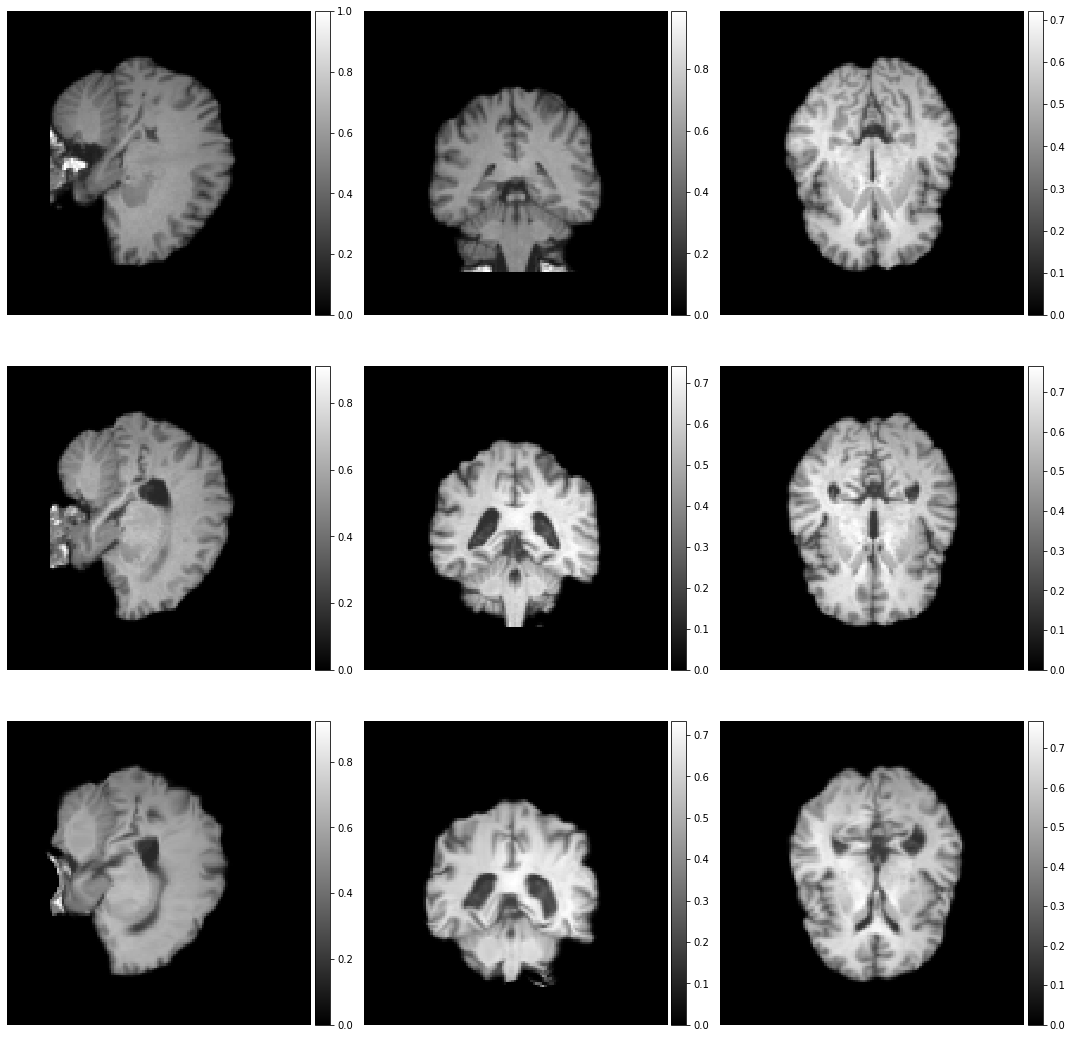

In [ ]:
mid_slices_fixed = [np.take(mynb_np1, 52, axis=d) for d in range(3)]
mid_slices_fixed[1] = np.rot90(mid_slices_fixed[1], 1)
mid_slices_fixed[2] = np.rot90(mid_slices_fixed[2], -1)

mid_slices_moving = [np.take(mynb_np2, 52, axis=d) for d in range(3)]
mid_slices_moving[1] = np.rot90(mid_slices_moving[1], 1)
mid_slices_moving[2] = np.rot90(mid_slices_moving[2], -1)

mid_slices_pred = [np.take(warped_img_np, 52, axis=d) for d in range(3)]
mid_slices_pred[1] = np.rot90(mid_slices_pred[1], 1)
mid_slices_pred[2] = np.rot90(mid_slices_pred[2], -1)
ne.plot.slices(mid_slices_fixed + mid_slices_moving + mid_slices_pred, cmaps=['gray'], do_colorbars=True, grid=[3,3]);

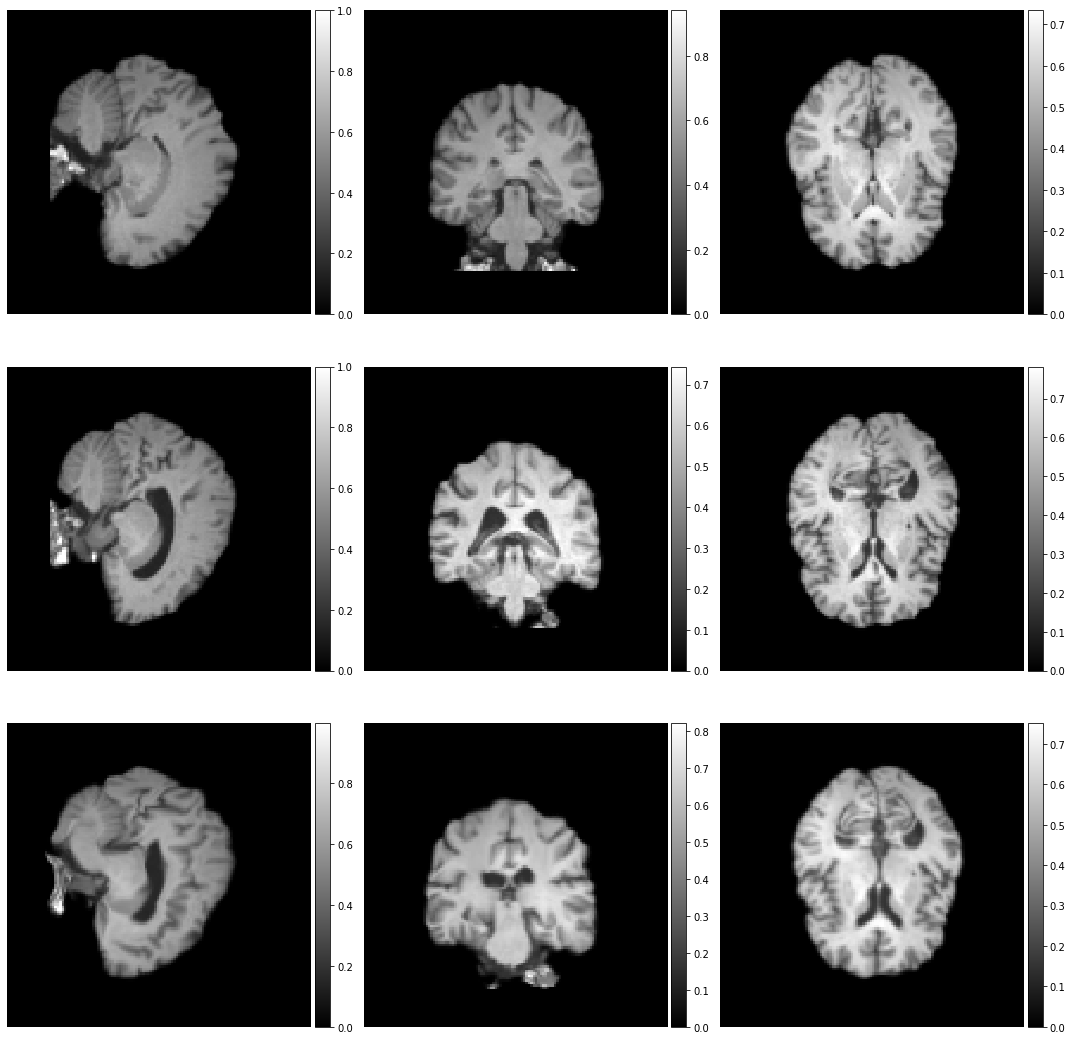

In [ ]:
mid_slices_fixed = [np.take(mynb_np1, 55, axis=d) for d in range(3)]
mid_slices_fixed[1] = np.rot90(mid_slices_fixed[1], 1)
mid_slices_fixed[2] = np.rot90(mid_slices_fixed[2], -1)

mid_slices_moving = [np.take(mynb_np2, 55, axis=d) for d in range(3)]
mid_slices_moving[1] = np.rot90(mid_slices_moving[1], 1)
mid_slices_moving[2] = np.rot90(mid_slices_moving[2], -1)

mid_slices_pred = [np.take(warped_img_np, 55, axis=d) for d in range(3)]
mid_slices_pred[1] = np.rot90(mid_slices_pred[1], 1)
mid_slices_pred[2] = np.rot90(mid_slices_pred[2], -1)
ne.plot.slices(mid_slices_fixed + mid_slices_moving + mid_slices_pred, cmaps=['gray'], do_colorbars=True, grid=[3,3]);

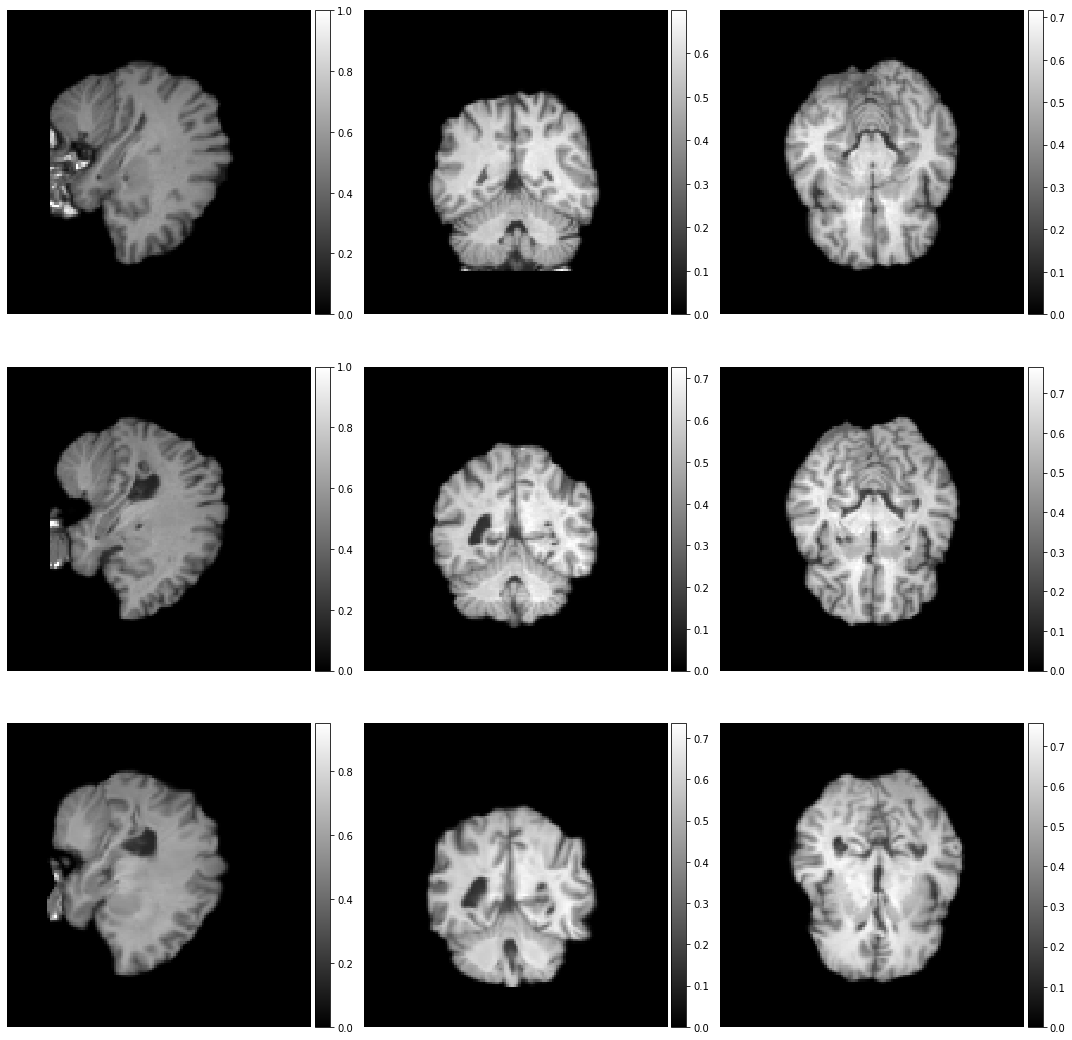

In [ ]:
mid_slices_fixed = [np.take(mynb_np1, 48, axis=d) for d in range(3)]
mid_slices_fixed[1] = np.rot90(mid_slices_fixed[1], 1)
mid_slices_fixed[2] = np.rot90(mid_slices_fixed[2], -1)

mid_slices_moving = [np.take(mynb_np2, 48, axis=d) for d in range(3)]
mid_slices_moving[1] = np.rot90(mid_slices_moving[1], 1)
mid_slices_moving[2] = np.rot90(mid_slices_moving[2], -1)

mid_slices_pred = [np.take(warped_img_np, 48, axis=d) for d in range(3)]
mid_slices_pred[1] = np.rot90(mid_slices_pred[1], 1)
mid_slices_pred[2] = np.rot90(mid_slices_pred[2], -1)
ne.plot.slices(mid_slices_fixed + mid_slices_moving + mid_slices_pred, cmaps=['gray'], do_colorbars=True, grid=[3,3]);

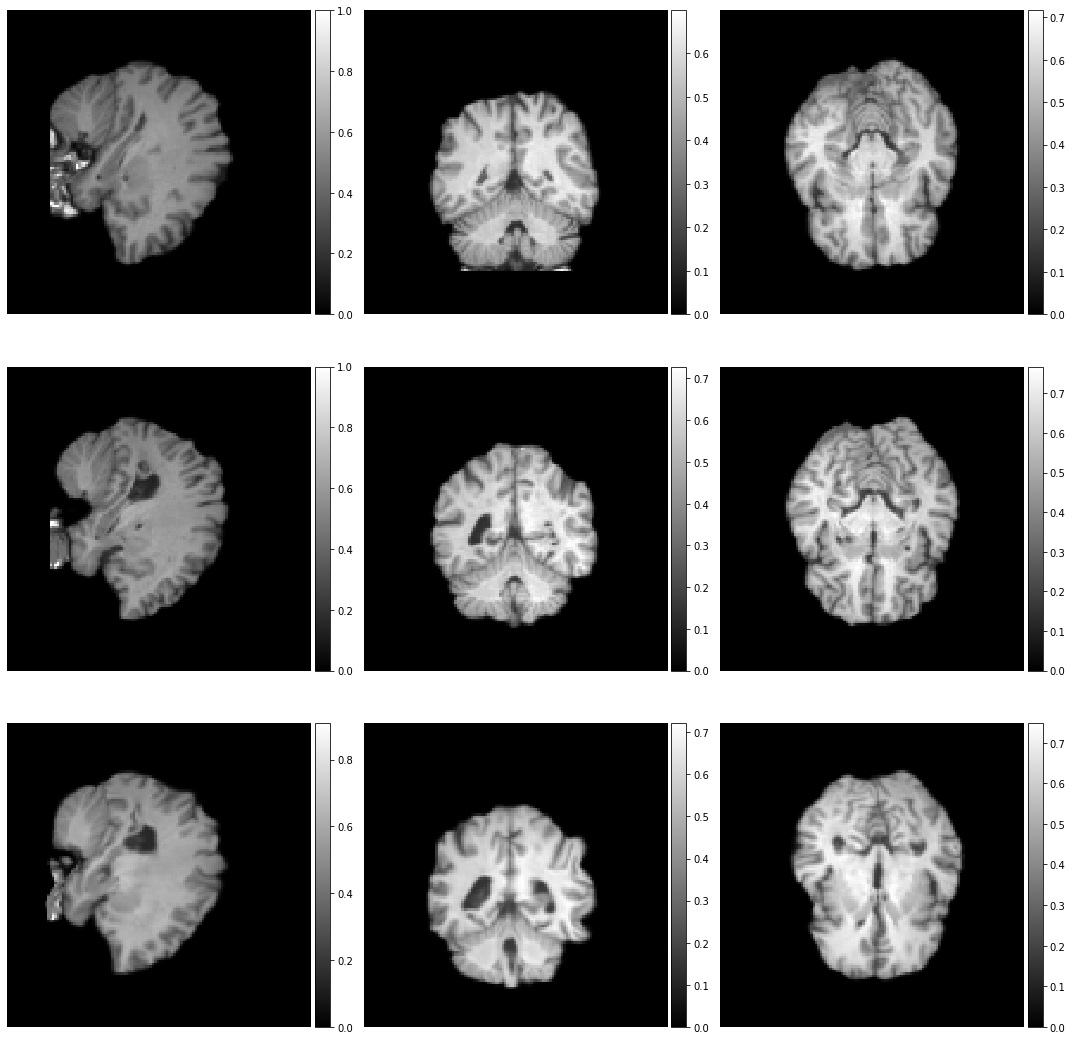

In [ ]:
mid_slices_fixed = [np.take(mynb_np1, 48, axis=d) for d in range(3)]
mid_slices_fixed[1] = np.rot90(mid_slices_fixed[1], 1)
mid_slices_fixed[2] = np.rot90(mid_slices_fixed[2], -1)

mid_slices_moving = [np.take(mynb_np2, 48, axis=d) for d in range(3)]
mid_slices_moving[1] = np.rot90(mid_slices_moving[1], 1)
mid_slices_moving[2] = np.rot90(mid_slices_moving[2], -1)

mid_slices_pred = [np.take(warped_img_np, 48, axis=d) for d in range(3)]
mid_slices_pred[1] = np.rot90(mid_slices_pred[1], 1)
mid_slices_pred[2] = np.rot90(mid_slices_pred[2], -1)
ne.plot.slices(mid_slices_fixed + mid_slices_moving + mid_slices_pred, cmaps=['gray'], do_colorbars=True, grid=[3,3]);

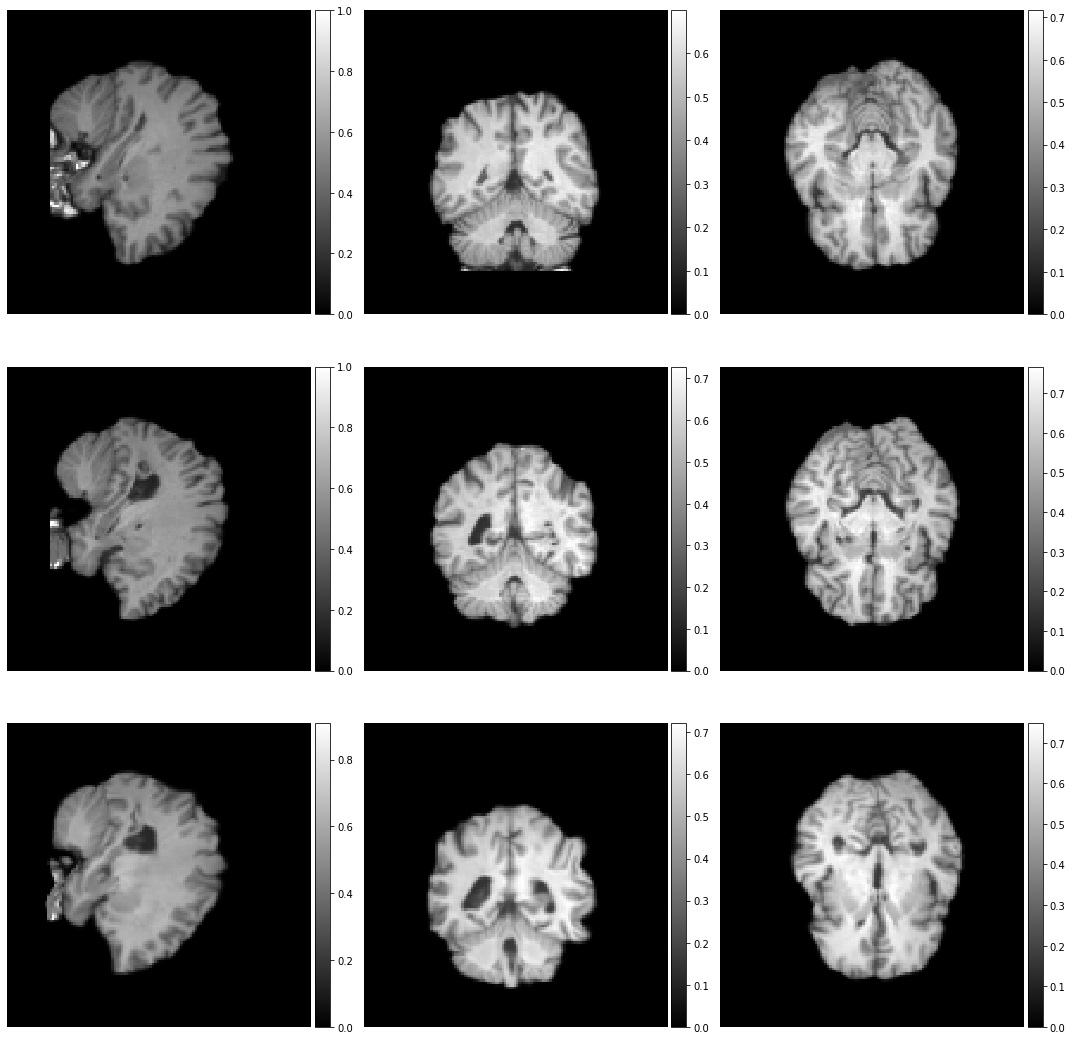

In [ ]:
mid_slices_fixed = [np.take(mynb_np1, 48, axis=d) for d in range(3)]
mid_slices_fixed[1] = np.rot90(mid_slices_fixed[1], 1)
mid_slices_fixed[2] = np.rot90(mid_slices_fixed[2], -1)

mid_slices_moving = [np.take(mynb_np2, 48, axis=d) for d in range(3)]
mid_slices_moving[1] = np.rot90(mid_slices_moving[1], 1)
mid_slices_moving[2] = np.rot90(mid_slices_moving[2], -1)

mid_slices_pred = [np.take(warped_img_np, 48, axis=d) for d in range(3)]
mid_slices_pred[1] = np.rot90(mid_slices_pred[1], 1)
mid_slices_pred[2] = np.rot90(mid_slices_pred[2], -1)
ne.plot.slices(mid_slices_fixed + mid_slices_moving + mid_slices_pred, cmaps=['gray'], do_colorbars=True, grid=[3,3]);

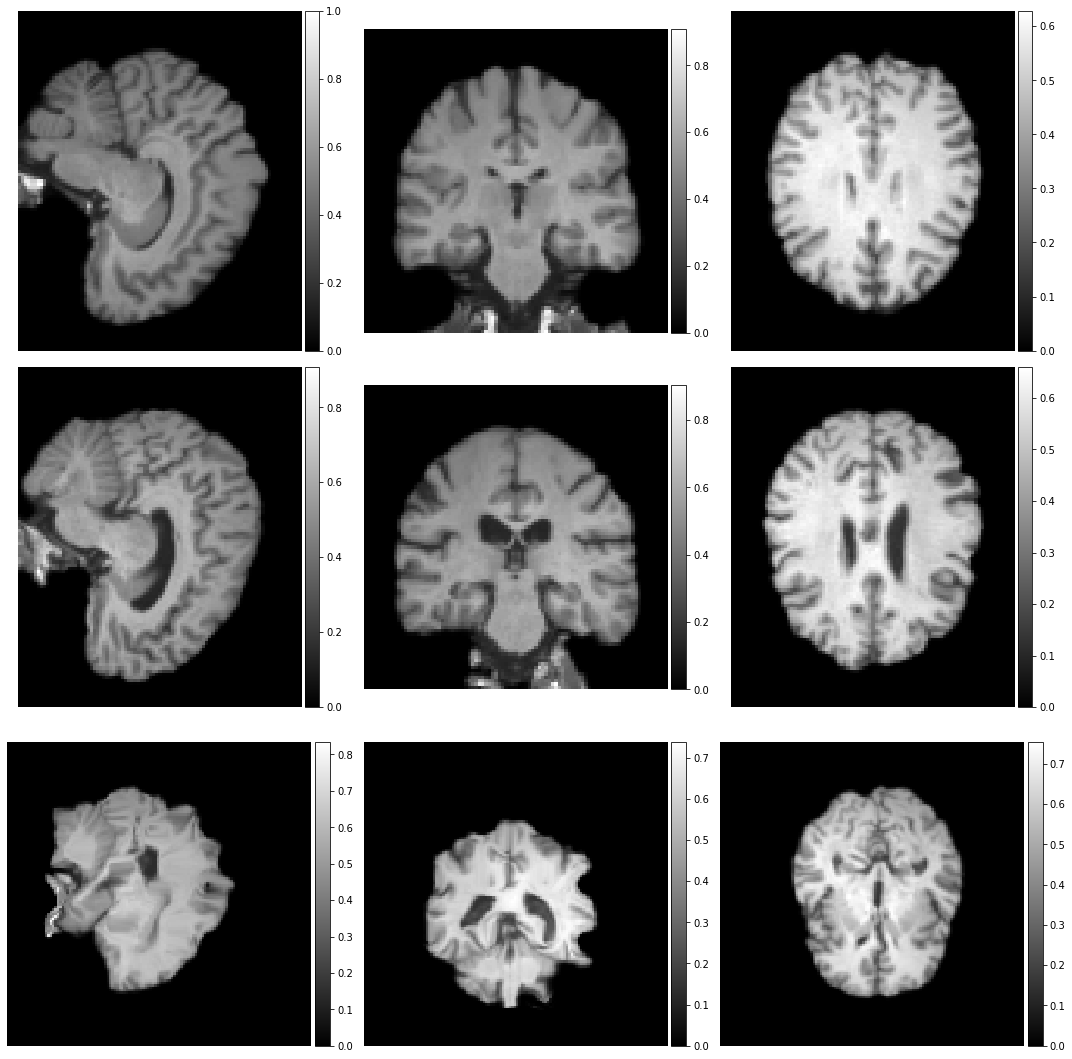

In [ ]:
mid_slices_fixed = [np.take(mynb_np1, 50, axis=d) for d in range(3)]
mid_slices_fixed[1] = np.rot90(mid_slices_fixed[1], 1)
mid_slices_fixed[2] = np.rot90(mid_slices_fixed[2], -1)

mid_slices_moving = [np.take(mynb_np2, 50, axis=d) for d in range(3)]
mid_slices_moving[1] = np.rot90(mid_slices_moving[1], 1)
mid_slices_moving[2] = np.rot90(mid_slices_moving[2], -1)

mid_slices_pred = [np.take(warped_img_np, 50, axis=d) for d in range(3)]
mid_slices_pred[1] = np.rot90(mid_slices_pred[1], 1)
mid_slices_pred[2] = np.rot90(mid_slices_pred[2], -1)
ne.plot.slices(mid_slices_fixed + mid_slices_moving + mid_slices_pred, cmaps=['gray'], do_colorbars=True, grid=[3,3]);

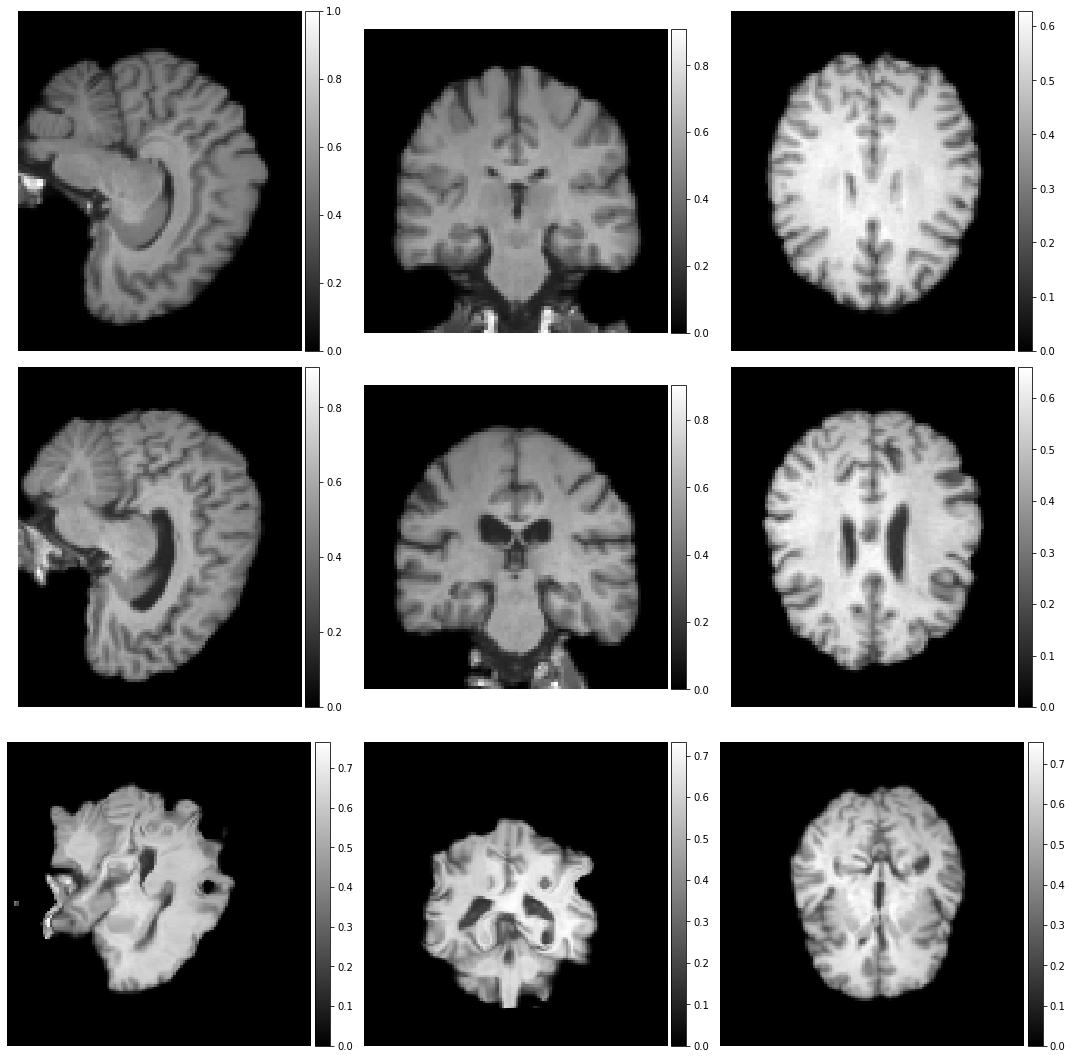

In [ ]:
mid_slices_fixed = [np.take(mynb_np1, 50, axis=d) for d in range(3)]
mid_slices_fixed[1] = np.rot90(mid_slices_fixed[1], 1)
mid_slices_fixed[2] = np.rot90(mid_slices_fixed[2], -1)

mid_slices_moving = [np.take(mynb_np2, 50, axis=d) for d in range(3)]
mid_slices_moving[1] = np.rot90(mid_slices_moving[1], 1)
mid_slices_moving[2] = np.rot90(mid_slices_moving[2], -1)

mid_slices_pred = [np.take(warped_img_np, 50, axis=d) for d in range(3)]
mid_slices_pred[1] = np.rot90(mid_slices_pred[1], 1)
mid_slices_pred[2] = np.rot90(mid_slices_pred[2], -1)
ne.plot.slices(mid_slices_fixed + mid_slices_moving + mid_slices_pred, cmaps=['gray'], do_colorbars=True, grid=[3,3]);

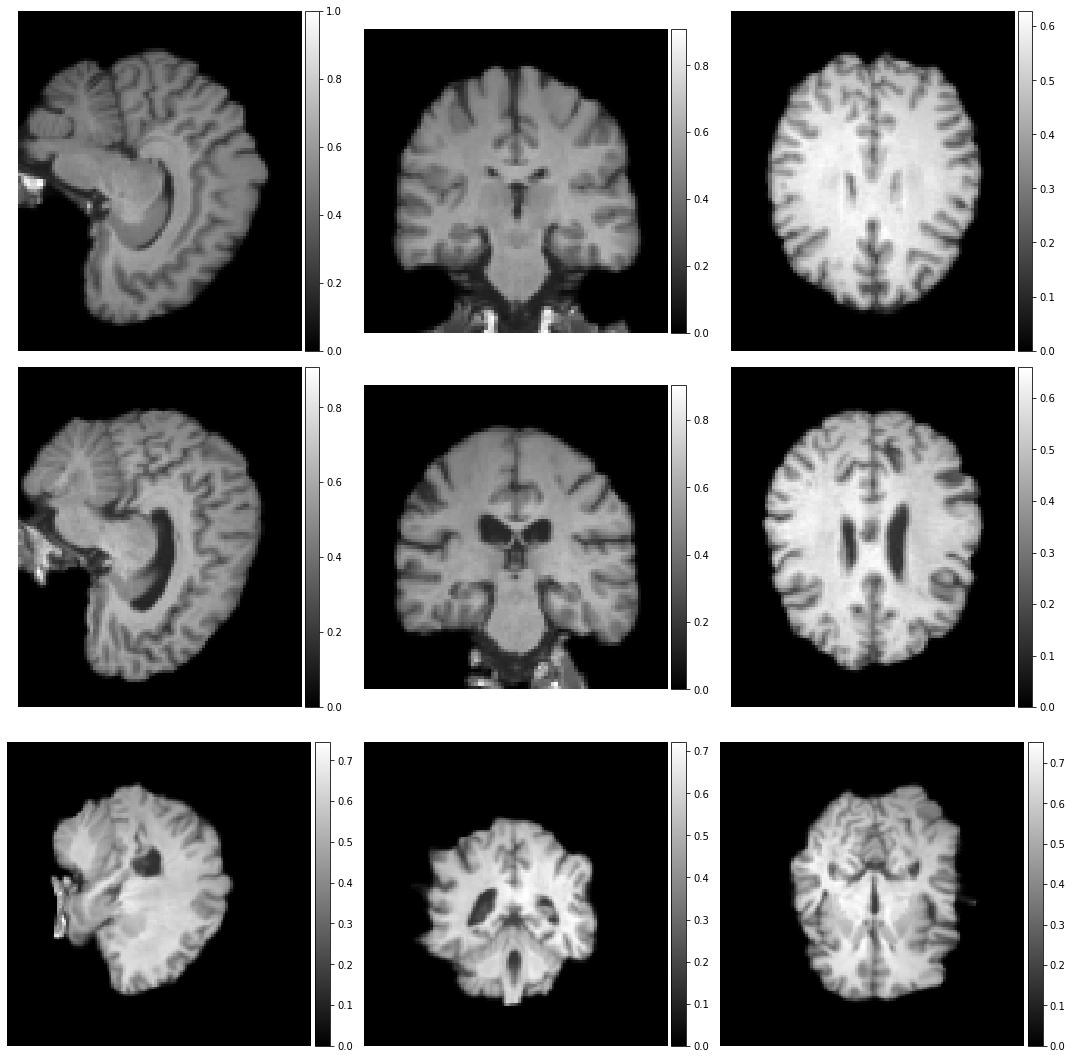

In [ ]:
mid_slices_fixed = [np.take(mynb_np1, 50, axis=d) for d in range(3)]
mid_slices_fixed[1] = np.rot90(mid_slices_fixed[1], 1)
mid_slices_fixed[2] = np.rot90(mid_slices_fixed[2], -1)

mid_slices_moving = [np.take(mynb_np2, 50, axis=d) for d in range(3)]
mid_slices_moving[1] = np.rot90(mid_slices_moving[1], 1)
mid_slices_moving[2] = np.rot90(mid_slices_moving[2], -1)

mid_slices_pred = [np.take(warped_img_np, 50, axis=d) for d in range(3)]
mid_slices_pred[1] = np.rot90(mid_slices_pred[1], 1)
mid_slices_pred[2] = np.rot90(mid_slices_pred[2], -1)
ne.plot.slices(mid_slices_fixed + mid_slices_moving + mid_slices_pred, cmaps=['gray'], do_colorbars=True, grid=[3,3]);

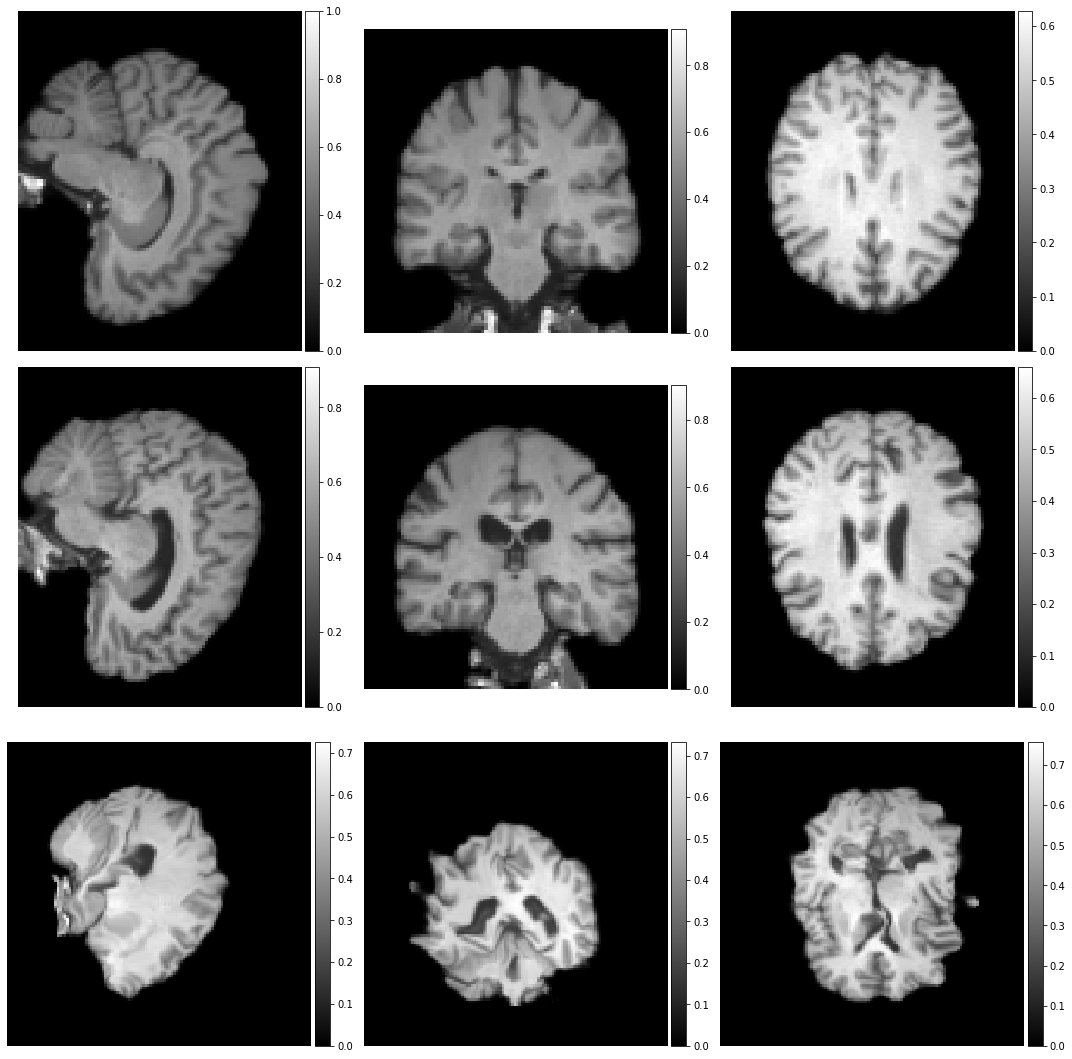

In [ ]:
mid_slices_fixed = [np.take(mynb_np1, 50, axis=d) for d in range(3)]
mid_slices_fixed[1] = np.rot90(mid_slices_fixed[1], 1)
mid_slices_fixed[2] = np.rot90(mid_slices_fixed[2], -1)

mid_slices_moving = [np.take(mynb_np2, 50, axis=d) for d in range(3)]
mid_slices_moving[1] = np.rot90(mid_slices_moving[1], 1)
mid_slices_moving[2] = np.rot90(mid_slices_moving[2], -1)

mid_slices_pred = [np.take(warped_img_np, 50, axis=d) for d in range(3)]
mid_slices_pred[1] = np.rot90(mid_slices_pred[1], 1)
mid_slices_pred[2] = np.rot90(mid_slices_pred[2], -1)
ne.plot.slices(mid_slices_fixed + mid_slices_moving + mid_slices_pred, cmaps=['gray'], do_colorbars=True, grid=[3,3]);

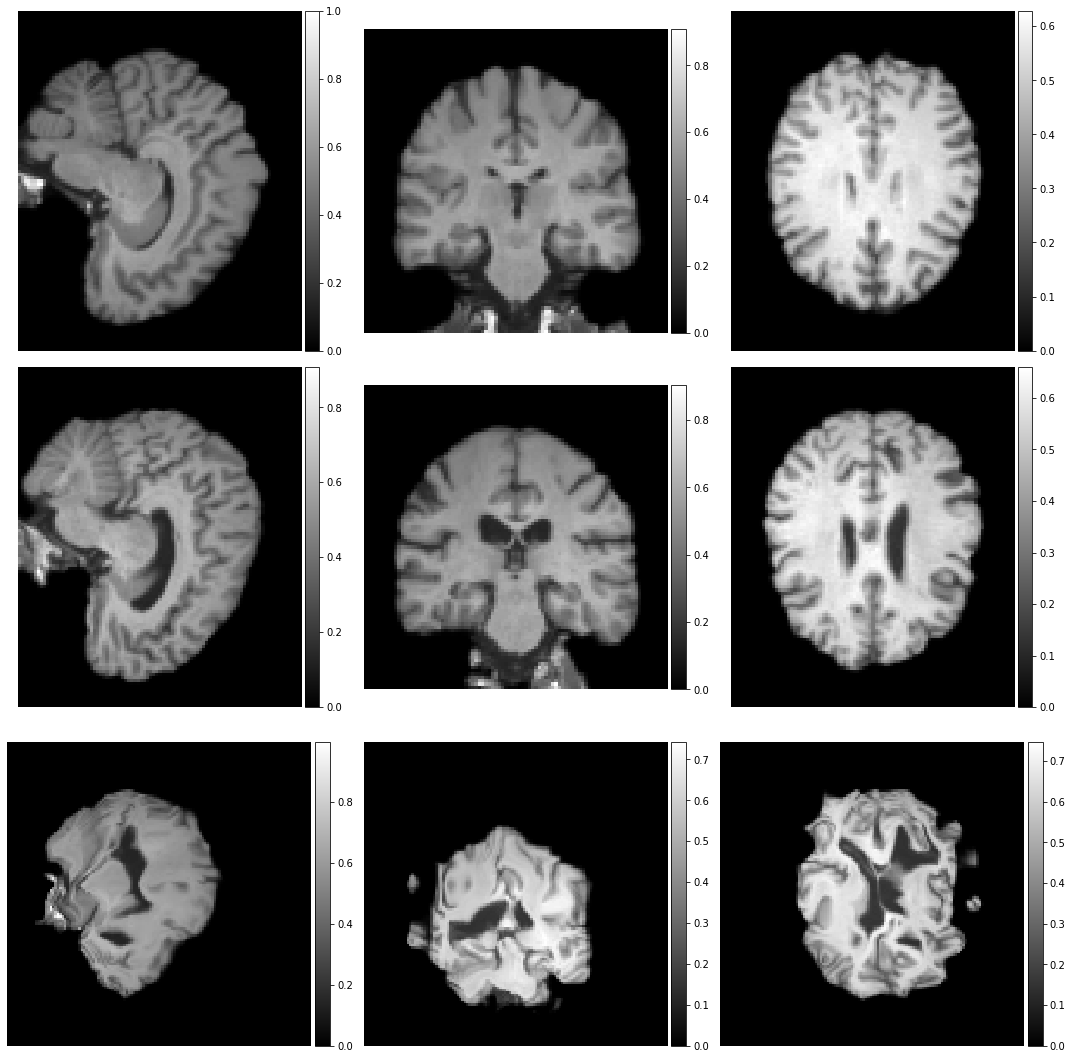

In [ ]:
mid_slices_fixed = [np.take(mynb_np1, 50, axis=d) for d in range(3)]
mid_slices_fixed[1] = np.rot90(mid_slices_fixed[1], 1)
mid_slices_fixed[2] = np.rot90(mid_slices_fixed[2], -1)

mid_slices_moving = [np.take(mynb_np2, 50, axis=d) for d in range(3)]
mid_slices_moving[1] = np.rot90(mid_slices_moving[1], 1)
mid_slices_moving[2] = np.rot90(mid_slices_moving[2], -1)

mid_slices_pred = [np.take(warped_img_np, 50, axis=d) for d in range(3)]
mid_slices_pred[1] = np.rot90(mid_slices_pred[1], 1)
mid_slices_pred[2] = np.rot90(mid_slices_pred[2], -1)
ne.plot.slices(mid_slices_fixed + mid_slices_moving + mid_slices_pred, cmaps=['gray'], do_colorbars=True, grid=[3,3]);